#1. Inisialisasi & Setup

###Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import Library yang Dibutuhkan

In [ ]:
import pandas as pd
import glob
import os


###Membaca Semua CSV dari Tiap Folder

In [ ]:

path_produksi = '/content/drive/MyDrive/Project_Wrangling_10/produksi/'
path_beras = '/content/drive/MyDrive/Project_Wrangling_10/beras/'
path_gabah = '/content/drive/MyDrive/Project_Wrangling_10/gabah/'
visualisasi_path = '/content/drive/MyDrive/Project_Wrangling_10/Visualisasi/'
dataset_path = '/content/drive/MyDrive/Project_Wrangling_10/data_publishing/'


In [ ]:
# Membaca semua file CSV per kategori
files_produksi = sorted(glob.glob(os.path.join(path_produksi, '*.csv')))
files_beras = sorted(glob.glob(os.path.join(path_beras, '*.xlsx')))
files_gabah = sorted(glob.glob(os.path.join(path_gabah, '*.csv')))

print("File produksi:", files_produksi)
print("File beras:", files_beras)
print("File gabah:", files_gabah)


File produksi: ['/content/drive/MyDrive/Project_Wrangling_10/produksi/Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2021.csv', '/content/drive/MyDrive/Project_Wrangling_10/produksi/Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2022.csv', '/content/drive/MyDrive/Project_Wrangling_10/produksi/Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2023.csv', '/content/drive/MyDrive/Project_Wrangling_10/produksi/Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2024.csv']
File beras: ['/content/drive/MyDrive/Project_Wrangling_10/beras/Tabel Harga Berdasarkan Daerah.xlsx']
File gabah: ['/content/drive/MyDrive/Project_Wrangling_10/gabah/harga_gabah.csv']


###Gabungkan Semua File Produksi

In [ ]:
data_produksi = []

for file in files_produksi:
    year = os.path.basename(file).split('_')[-1].replace('.csv', '')

    # Extract only the 4-digit year from the string
    year = year[-4:]

    # Read the data, skipping the first 3 rows which contain metadata/header
    df = pd.read_csv(file, skiprows=3, header=None)

    # Assign generic column names so they can be concatenated properly
    df.columns = ['Provinsi', 'Luas Panen (ha)', 'Produktivitas (ku/ha)', 'Produksi (ton)']

    # Add the 'Tahun' column explicitly from the filename for consistency
    df['Tahun'] = year

    data_produksi.append(df)

produksi_all = pd.concat(data_produksi, ignore_index=True)

# Fill any remaining NaN values in the concatenated DataFrame with 0, as requested
produksi_all = produksi_all.fillna(0)

# Remove the row at index 0
produksi_all = produksi_all.drop(index=0).reset_index(drop=True)

produksi_all

Provinsi Luas Panen (ha) Produktivitas (ku/ha) Produksi (ton)  \
0                ACEH       297058.38                 55.03      1634639.6   
1      SUMATERA UTARA          385405                    52     2004142.51   
2      SUMATERA BARAT       272391.95                 48.36     1317209.38   
3                RIAU        53062.35                 40.98      217458.87   
4               JAMBI        64412.26                 46.29      298149.25   
..                ...             ...                   ...            ...   
154             PAPUA         1068.57                 43.14        4609.95   
155     PAPUA SELATAN        47168.57                 46.17      217789.62   
156      PAPUA TENGAH         1436.12                 42.28        6072.38   
157  PAPUA PEGUNUNGAN            9.66                 43.87          42.38   
158         INDONESIA     10046135.36                 52.90    53142726.65   

    Tahun  
0    2021  
1    2021  
2    2021  
3    2021  
4    2021  
..    ...  
154  2024  
155  2024  
156  2024  
157  2024  
158  2024  

[159 rows x 5 columns]

###Gabungkan Semua File Harga Beras

In [ ]:
import pandas as pd
import glob
import os

path_beras = '/content/drive/MyDrive/Project_Wrangling_10/beras/'
files_beras = sorted(glob.glob(os.path.join(path_beras, '*.xlsx')))

data_beras = []

for file_path in files_beras:
    try:
        # Read the entire Excel file (first sheet) without headers to inspect its raw structure.
        temp_df = pd.read_excel(file_path, sheet_name=0, header=None)
    except Exception as e:
        print(f"Error reading Excel file {file_path}: {e}")
        continue # Skip to the next file if there's an issue

    # The actual column headers are in the first row (index 0).
    # The first column is 'No', the second is 'Komoditas (Rp)', and subsequent columns are dates.
    raw_headers = temp_df.iloc[0].tolist()

    # Rename the second header to 'Kategori' for clarity.
    if len(raw_headers) > 1:
        raw_headers[1] = 'Kategori'

    # Extract the actual data rows. Assuming data for specific beras qualities starts from row index 2.
    # (Row 0 is headers, Row 1 is 'Beras' aggregate, Row 2 onwards are specific qualities).
    df = temp_df.iloc[2:].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Assign headers, trimming raw_headers if df has fewer columns
    if len(df.columns) > len(raw_headers):
        df.columns = raw_headers + list(df.columns[len(raw_headers):]) # Keep original names for extra columns
    else:
        df.columns = raw_headers[:len(df.columns)]

    # Drop the 'No' column as it's not needed for analysis
    if 'No' in df.columns:
        df = df.drop(columns=['No'])

    # Filter to keep only rows where the 'Kategori' column is for specific rice qualities.
    # We should exclude rows where 'Kategori' is NaN or contains 'Total' or is empty.
    df = df[df['Kategori'].notna() & ~df['Kategori'].astype(str).str.contains('Total', na=False) & (df['Kategori'].astype(str).str.strip() != '')].copy()

    # Extract year from date columns (e.g., '01/ 01/ 2021' -> '2021')
    # Assign a 'Tahun' column based on the year found in the first valid date column.
    year_found = "Unknown"
    date_cols_for_year_detection = [col for col in df.columns if isinstance(col, (pd.Timestamp, str)) and '/' in str(col)]
    if date_cols_for_year_detection:
        first_date_col = date_cols_for_year_detection[0]
        try:
            year_found = str(pd.to_datetime(first_date_col).year)
        except ValueError:
            pass # year_found remains "Unknown"
    df['Tahun'] = year_found

    # Identify month columns for melting. These will be the date columns from the original raw_headers.
    # Exclude 'Kategori' and 'Tahun' from melting.
    month_columns_to_melt = [col for col in df.columns if col not in ['Kategori', 'Tahun']]

    if not month_columns_to_melt:
        print(f"Warning: No date/month columns found in {file_path}. Skipping.")
        continue # Skip if no date columns to melt

    id_vars = ['Kategori', 'Tahun']

    # Melt the DataFrame to transform monthly columns into 'Bulan' and 'Harga' columns.
    df_melted = df.melt(id_vars=id_vars,
                        value_vars=month_columns_to_melt,
                        var_name='Tanggal_Bulan', # Rename to indicate it's a date
                        value_name='Harga')

    # Convert 'Tanggal_Bulan' to datetime and then extract month/year
    df_melted['Tanggal_Bulan'] = pd.to_datetime(df_melted['Tanggal_Bulan'], errors='coerce')
    df_melted = df_melted.dropna(subset=['Tanggal_Bulan']) # Drop rows where date conversion failed

    # Update 'Tahun' based on actual date and extract 'Bulan'
    df_melted['Tahun'] = df_melted['Tanggal_Bulan'].dt.year.astype(str)
    df_melted['Bulan'] = df_melted['Tanggal_Bulan'].dt.strftime('%B') # Full month name

    # Convert 'Harga' to numeric, handling potential Indonesian formatting (e.g., '11.800' is 11800).
    df_melted['Harga'] = df_melted['Harga'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df_melted['Harga'] = pd.to_numeric(df_melted['Harga'], errors='coerce')

    # Fill any NaN prices with 0.
    df_melted = df_melted.fillna(0)
    data_beras.append(df_melted)

# Concatenate all processed DataFrames into beras_all.
beras_all = pd.concat(data_beras, ignore_index=True) if data_beras else pd.DataFrame(columns=['Kategori', 'Tahun', 'Bulan', 'Harga'])

# Calculate the annual total price by grouping by 'Kategori' and 'Tahun' and summing 'Harga'.
if not beras_all.empty:
    beras_tahunan = (
        beras_all
        .groupby(['Kategori', 'Tahun'], as_index=False)['Harga']
        .mean() # Changed sum() to mean() to get average annual price
        .rename(columns={'Harga': 'Total_Harga_Tahunan'}) # Renamed column for clarity
    )
else:
    beras_tahunan = pd.DataFrame(columns=['Kategori', 'Tahun', 'Total_Harga_Tahunan'])
    print("DataFrame 'beras_all' is empty, so 'beras_tahunan' could not be calculated.")

print("DataFrame beras_tahunan:")
beras_tahunan

DataFrame beras_tahunan:


Kategori Tahun  Total_Harga_Tahunan
0     Beras Kualitas Bawah I  2021                 9.94
1     Beras Kualitas Bawah I  2022                 8.99
2     Beras Kualitas Bawah I  2023                12.48
3     Beras Kualitas Bawah I  2024                14.12
4    Beras Kualitas Bawah II  2021                 9.56
5    Beras Kualitas Bawah II  2022                 7.93
6    Beras Kualitas Bawah II  2023                12.21
7    Beras Kualitas Bawah II  2024                13.87
8    Beras Kualitas Medium I  2021                10.89
9    Beras Kualitas Medium I  2022                 9.88
10   Beras Kualitas Medium I  2023                13.64
11   Beras Kualitas Medium I  2024                15.40
12  Beras Kualitas Medium II  2021                10.62
13  Beras Kualitas Medium II  2022                 8.82
14  Beras Kualitas Medium II  2023                13.39
15  Beras Kualitas Medium II  2024                15.25
16    Beras Kualitas Super I  2021                12.11
17    Beras Kualitas Super I  2022                10.93
18    Beras Kualitas Super I  2023                14.92
19    Beras Kualitas Super I  2024                16.74
20   Beras Kualitas Super II  2021                11.65
21   Beras Kualitas Super II  2022                 9.63
22   Beras Kualitas Super II  2023                14.42
23   Beras Kualitas Super II  2024                16.25

Data Gabah

In [ ]:
path_gabah_cleaned = '/content/drive/MyDrive/Project_Wrangling_10/gabah/harga_gabah.csv'

# Baca file CSV yang sudah dibersihkan
gabah_all = pd.read_csv(path_gabah_cleaned)

print("Data Gabah (dari file cleaned):")
print(gabah_all)
print("\nKolom yang tersedia:", gabah_all.columns.tolist())
print("\nInfo DataFrame:")
print(gabah_all.info())

Data Gabah (dari file cleaned):
        Tingkat                 Kualitas    2020    2021    2022    2023  \
0        Petani   Gabah Kering Panen GKP 4844.88 4551.77 4895.67 5968.14   
1        Petani  Gabah Kering Giling GKG 5567.25 5061.87 5491.54 6761.92   
2        Petani      Gabah Luar Kualitas 4485.97 4226.52 4570.00 5661.50   
3  Penggilingan   Gabah Kering Panen GKP 4943.35 4655.52 5014.14 6111.04   
4  Penggilingan  Gabah Kering Giling GKG 5691.18 5175.14 5608.11 6877.56   
5  Penggilingan      Gabah Luar Kualitas 4583.76 4325.92 4673.11 5782.48   

    2024*  
0 6431.11  
1 7346.53  
2 6072.12  
3 6577.77  
4 7465.91  
5 6211.54  

Kolom yang tersedia: ['Tingkat', 'Kualitas', '2020', '2021', '2022', '2023', '2024*']

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tingkat   6 non-null      object 
 1   Kualitas  6 non-null     

#Pre-Processing Data

Ambil Kolom yang Relevan dari Tiap Dataset

In [ ]:

produksi_all['Produksi (ton)'] = pd.to_numeric(produksi_all['Produksi (ton)'], errors='coerce')

produksi_use = (
    produksi_all[produksi_all['Provinsi'] != 'INDONESIA']
    .groupby('Tahun')['Produksi (ton)']
    .mean()
    .reset_index()
)

beras_use = beras_tahunan[['Kategori', 'Tahun', 'Total_Harga_Tahunan']].rename(columns={'Total_Harga_Tahunan': 'Harga Beras (Rp/Kg)'})

gabah_gkg = gabah_all[gabah_all['Kualitas'] == 'Gabah Kering Giling GKG'].copy()

gabah_gkg_melted = gabah_gkg.melt(
    id_vars=['Tingkat', 'Kualitas'],
    value_vars=['2021', '2022', '2023', '2024*'],
    var_name='Tahun',
    value_name='Harga'
)

gabah_gkg_melted['Tahun'] = gabah_gkg_melted['Tahun'].str.replace('*', '', regex=False)

gabah_gkg_melted['Harga'] = pd.to_numeric(gabah_gkg_melted['Harga'], errors='coerce')

gabah_use = (
    gabah_gkg_melted
    .groupby('Tahun')['Harga']
    .mean()
    .reset_index()
    .rename(columns={'Harga': 'Harga Gabah (Rp/Kg)'})
)

print("Data Produksi (Akumulasi per Tahun):")
print(produksi_use)
print("\nData Beras:")
print(beras_use)
print("\nData Gabah (GKG - Rata-rata Petani & Penggilingan):")
print(gabah_use)

Data Produksi (Akumulasi per Tahun):
  Tahun  Produksi (ton)
0  2021      1600449.83
1  2022      1564314.22
2  2023      1384179.90
3  2024      1362685.91

Data Beras:
                    Kategori Tahun  Harga Beras (Rp/Kg)
0     Beras Kualitas Bawah I  2021                 9.94
1     Beras Kualitas Bawah I  2022                 8.99
2     Beras Kualitas Bawah I  2023                12.48
3     Beras Kualitas Bawah I  2024                14.12
4    Beras Kualitas Bawah II  2021                 9.56
5    Beras Kualitas Bawah II  2022                 7.93
6    Beras Kualitas Bawah II  2023                12.21
7    Beras Kualitas Bawah II  2024                13.87
8    Beras Kualitas Medium I  2021                10.89
9    Beras Kualitas Medium I  2022                 9.88
10   Beras Kualitas Medium I  2023                13.64
11   Beras Kualitas Medium I  2024                15.40
12  Beras Kualitas Medium II  2021                10.62
13  Beras Kualitas Medium II  2022            

In [ ]:
merged_df = (
    produksi_use
    .merge(beras_use, on='Tahun', how='inner')
    .merge(gabah_use, on='Tahun', how='inner')
)

merged_df


Tahun  Produksi (ton)                  Kategori  Harga Beras (Rp/Kg)  \
0   2021      1600449.83    Beras Kualitas Bawah I                 9.94   
1   2021      1600449.83   Beras Kualitas Bawah II                 9.56   
2   2021      1600449.83   Beras Kualitas Medium I                10.89   
3   2021      1600449.83  Beras Kualitas Medium II                10.62   
4   2021      1600449.83    Beras Kualitas Super I                12.11   
5   2021      1600449.83   Beras Kualitas Super II                11.65   
6   2022      1564314.22    Beras Kualitas Bawah I                 8.99   
7   2022      1564314.22   Beras Kualitas Bawah II                 7.93   
8   2022      1564314.22   Beras Kualitas Medium I                 9.88   
9   2022      1564314.22  Beras Kualitas Medium II                 8.82   
10  2022      1564314.22    Beras Kualitas Super I                10.93   
11  2022      1564314.22   Beras Kualitas Super II                 9.63   
12  2023      1384179.90    Beras Kualitas Bawah I                12.48   
13  2023      1384179.90   Beras Kualitas Bawah II                12.21   
14  2023      1384179.90   Beras Kualitas Medium I                13.64   
15  2023      1384179.90  Beras Kualitas Medium II                13.39   
16  2023      1384179.90    Beras Kualitas Super I                14.92   
17  2023      1384179.90   Beras Kualitas Super II                14.42   
18  2024      1362685.91    Beras Kualitas Bawah I                14.12   
19  2024      1362685.91   Beras Kualitas Bawah II                13.87   
20  2024      1362685.91   Beras Kualitas Medium I                15.40   
21  2024      1362685.91  Beras Kualitas Medium II                15.25   
22  2024      1362685.91    Beras Kualitas Super I                16.74   
23  2024      1362685.91   Beras Kualitas Super II                16.25   

    Harga Gabah (Rp/Kg)  
0               5118.51  
1               5118.51  
2               5118.51  
3               5118.51  
4               5118.51  
5               5118.51  
6               5549.82  
7               5549.82  
8               5549.82  
9               5549.82  
10              5549.82  
11              5549.82  
12              6819.74  
13              6819.74  
14              6819.74  
15              6819.74  
16              6819.74  
17              6819.74  
18              7406.22  
19              7406.22  
20              7406.22  
21              7406.22  
22              7406.22  
23              7406.22

In [ ]:
output_path = 'merged_raw_data.csv'
merged_df.to_csv(output_path, index=False)

print("Data gabungan awal berhasil disimpan di:", output_path)


Data gabungan awal berhasil disimpan di: merged_raw_data.csv


#2. Data Cleaning

###Import Library untuk Data Cleaning

In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

###Load Data yang Sudah Di-merge

In [ ]:
# Load data yang sudah di-merge sebelumnya
merged_df = pd.read_csv('merged_raw_data.csv')

print("=" * 80)
print("DATA YANG AKAN DIBERSIHKAN")
print("=" * 80)
print(f"\nJumlah baris: {len(merged_df)}")
print(f"Jumlah kolom: {len(merged_df.columns)}")
print("\n5 Baris Pertama:")
print(merged_df.head())

DATA YANG AKAN DIBERSIHKAN

Jumlah baris: 24
Jumlah kolom: 5

5 Baris Pertama:
   Tahun  Produksi (ton)                  Kategori  Harga Beras (Rp/Kg)  \
0   2021      1600449.83    Beras Kualitas Bawah I                 9.94   
1   2021      1600449.83   Beras Kualitas Bawah II                 9.56   
2   2021      1600449.83   Beras Kualitas Medium I                10.89   
3   2021      1600449.83  Beras Kualitas Medium II                10.62   
4   2021      1600449.83    Beras Kualitas Super I                12.11   

   Harga Gabah (Rp/Kg)  
0              5118.51  
1              5118.51  
2              5118.51  
3              5118.51  
4              5118.51  


## 2.1 Inspeksi dan Validasi Data

###A. Cek Info Dasar & Tipe Data

In [ ]:
print("=" * 80)
print("STEP 1: INSPEKSI DAN VALIDASI DATA")
print("=" * 80)

print("\nINFORMASI DATASET:")
print(merged_df.info())

print("\n" + "=" * 80)
print("TIPE DATA SETIAP KOLOM:")
print("=" * 80)
for col in merged_df.columns:
    print(f"{col:30s} : {merged_df[col].dtype}")

STEP 1: INSPEKSI DAN VALIDASI DATA

INFORMASI DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tahun                24 non-null     int64  
 1   Produksi (ton)       24 non-null     float64
 2   Kategori             24 non-null     object 
 3   Harga Beras (Rp/Kg)  24 non-null     float64
 4   Harga Gabah (Rp/Kg)  24 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.1+ KB
None

TIPE DATA SETIAP KOLOM:
Tahun                          : int64
Produksi (ton)                 : float64
Kategori                       : object
Harga Beras (Rp/Kg)            : float64
Harga Gabah (Rp/Kg)            : float64


###B. Cek Missing **Values**

In [ ]:

missing_summary = pd.DataFrame({
    'Kolom': merged_df.columns,
    'Missing Count': merged_df.isnull().sum(),
    'Missing %': (merged_df.isnull().sum() / len(merged_df) * 100).round(2)
})

print(missing_summary)

# Visualisasi Missing Values
if merged_df.isnull().sum().sum() > 0:
    plt.figure(figsize=(10, 5))
    missing_summary[missing_summary['Missing Count'] > 0].plot(
        x='Kolom',
        y='Missing Count',
        kind='bar',
        color='salmon',
        legend=False
    )
    plt.title('Missing Values per Kolom', fontsize=14, fontweight='bold')
    plt.xlabel('Kolom')
    plt.ylabel('Jumlah Missing')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nTIDAK ADA MISSING VALUES!")

                                   Kolom  Missing Count  Missing %
Tahun                              Tahun              0       0.00
Produksi (ton)            Produksi (ton)              0       0.00
Kategori                        Kategori              0       0.00
Harga Beras (Rp/Kg)  Harga Beras (Rp/Kg)              0       0.00
Harga Gabah (Rp/Kg)  Harga Gabah (Rp/Kg)              0       0.00

TIDAK ADA MISSING VALUES!


###C. Cek Duplikasi Data

In [ ]:

# Cek duplikasi penuh
duplicates_full = merged_df.duplicated().sum()
print(f"Jumlah baris duplikat (semua kolom): {duplicates_full}")

# Cek duplikasi berdasarkan key columns
duplicates_key = merged_df.duplicated(subset=['Tahun', 'Kategori']).sum()
print(f"Jumlah duplikasi berdasarkan Tahun & Kategori: {duplicates_key}")

if duplicates_key > 0:
    print("\n⚠️ DITEMUKAN DUPLIKASI! Berikut data duplikat:")
    duplicated_rows = merged_df[merged_df.duplicated(subset=['Tahun', 'Kategori'], keep=False)]
    print(duplicated_rows.sort_values(['Tahun', 'Kategori']))
else:
    print("\n✅ TIDAK ADA DUPLIKASI!")

Jumlah baris duplikat (semua kolom): 0
Jumlah duplikasi berdasarkan Tahun & Kategori: 0

✅ TIDAK ADA DUPLIKASI!


###D. Statistik Deskriptif & Identifikasi Outliers

In [ ]:


print("\nStatistik untuk kolom numerik:")
print(merged_df.describe())

print("\n" + "=" * 80)
print("IDENTIFIKASI OUTLIERS & NILAI TIDAK MASUK AKAL")
print("=" * 80)

# Cek Harga Beras
print("\n HARGA BERAS:")
print(f"   Min  : Rp {merged_df['Harga Beras (Rp/Kg)'].min():.2f}")
print(f"   Max  : Rp {merged_df['Harga Beras (Rp/Kg)'].max():.2f}")
print(f"   Mean : Rp {merged_df['Harga Beras (Rp/Kg)'].mean():.2f}")
print(f"   Median: Rp {merged_df['Harga Beras (Rp/Kg)'].median():.2f}")

# Cek Harga Gabah
print("\n HARGA GABAH:")
print(f"   Min  : Rp {merged_df['Harga Gabah (Rp/Kg)'].min():.2f}")
print(f"   Max  : Rp {merged_df['Harga Gabah (Rp/Kg)'].max():.2f}")
print(f"   Mean : Rp {merged_df['Harga Gabah (Rp/Kg)'].mean():.2f}")
print("   Harga gabah sudah dalam format yang benar (Rp/Kg)")

# Cek Produksi
print("\n PRODUKSI PADI:")
print(f"   Min  : {merged_df['Produksi (ton)'].min():,.2f} ton")
print(f"   Max  : {merged_df['Produksi (ton)'].max():,.2f} ton")
print(f"   Mean : {merged_df['Produksi (ton)'].mean():,.2f} ton")
print("   Produksi sudah dalam format yang benar (ton)")


Statistik untuk kolom numerik:
        Tahun  Produksi (ton)  Harga Beras (Rp/Kg)  Harga Gabah (Rp/Kg)
count   24.00           24.00                24.00                24.00
mean  2022.50      1477907.47                12.23              6223.57
std      1.14       107796.45                 2.54               945.82
min   2021.00      1362685.91                 7.93              5118.51
25%   2021.75      1378806.41                 9.92              5441.99
50%   2022.50      1474247.06                12.16              6184.78
75%   2023.25      1573348.13                14.20              6966.36
max   2024.00      1600449.83                16.74              7406.22

IDENTIFIKASI OUTLIERS & NILAI TIDAK MASUK AKAL

 HARGA BERAS:
   Min  : Rp 7.93
   Max  : Rp 16.74
   Mean : Rp 12.23
   Median: Rp 12.16

 HARGA GABAH:
   Min  : Rp 5118.51
   Max  : Rp 7406.22
   Mean : Rp 6223.57
   Harga gabah sudah dalam format yang benar (Rp/Kg)

 PRODUKSI PADI:
   Min  : 1,362,685.91 ton
   Max

###E. Visualisasi Distribusi Data

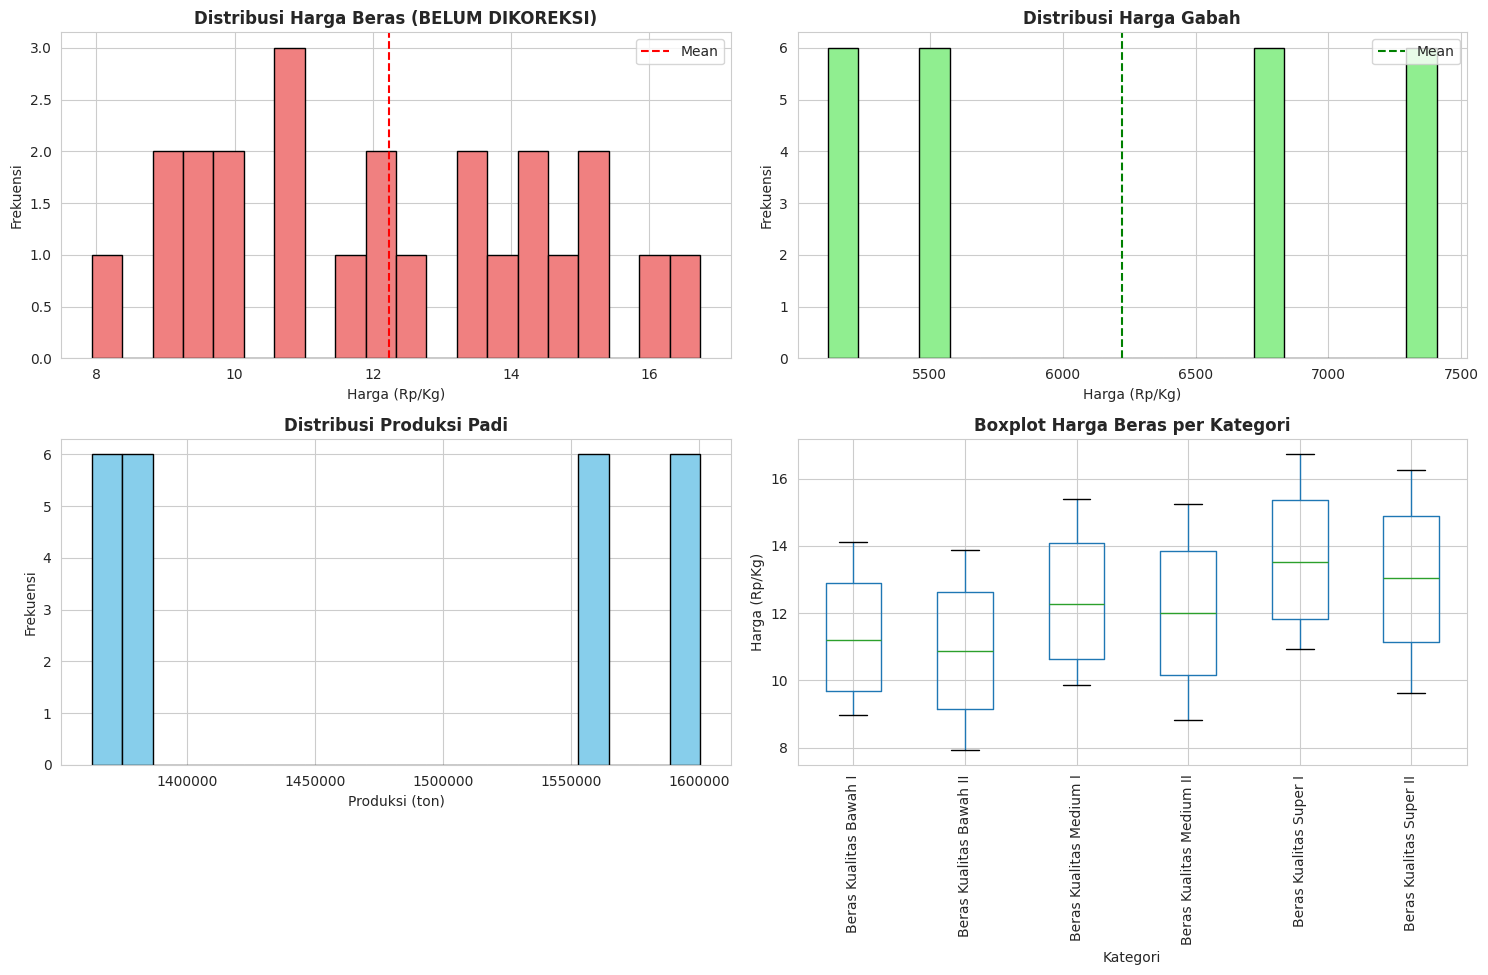

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribusi Harga Beras (SEBELUM koreksi)
axes[0, 0].hist(merged_df['Harga Beras (Rp/Kg)'], bins=20, color='lightcoral', edgecolor='black')
axes[0, 0].set_title('Distribusi Harga Beras (BELUM DIKOREKSI)', fontweight='bold')
axes[0, 0].set_xlabel('Harga (Rp/Kg)')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].axvline(merged_df['Harga Beras (Rp/Kg)'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# 2. Distribusi Harga Gabah
axes[0, 1].hist(merged_df['Harga Gabah (Rp/Kg)'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribusi Harga Gabah', fontweight='bold')
axes[0, 1].set_xlabel('Harga (Rp/Kg)')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].axvline(merged_df['Harga Gabah (Rp/Kg)'].mean(), color='green', linestyle='--', label='Mean')
axes[0, 1].legend()

# 3. Distribusi Produksi
axes[1, 0].hist(merged_df['Produksi (ton)'], bins=20, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Distribusi Produksi Padi', fontweight='bold')
axes[1, 0].set_xlabel('Produksi (ton)')
axes[1, 0].set_ylabel('Frekuensi')
axes[1, 0].ticklabel_format(style='plain', axis='x')

# 4. Boxplot Harga Beras per Kategori
merged_df.boxplot(column='Harga Beras (Rp/Kg)', by='Kategori', ax=axes[1, 1], rot=90)
axes[1, 1].set_title('Boxplot Harga Beras per Kategori', fontweight='bold')
axes[1, 1].set_xlabel('Kategori')
axes[1, 1].set_ylabel('Harga (Rp/Kg)')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

##2.2 Data Type Correction

###A. Koreksi Tipe Data

In [ ]:

# Buat copy untuk cleaning
df_cleaned = merged_df.copy()

# 1. Konversi Tahun ke integer
df_cleaned['Tahun'] = df_cleaned['Tahun'].astype(int)

# 2. Pastikan Harga Beras numeric (sudah numeric, tapi kita tetap pastikan)
df_cleaned['Harga Beras (Rp/Kg)'] = pd.to_numeric(df_cleaned['Harga Beras (Rp/Kg)'], errors='coerce')

#  Harga Gabah numeric
df_cleaned['Harga Gabah (Rp/Kg)'] = pd.to_numeric(df_cleaned['Harga Gabah (Rp/Kg)'], errors='coerce')

#  Produksi numeric
df_cleaned['Produksi (ton)'] = pd.to_numeric(df_cleaned['Produksi (ton)'], errors='coerce')

# Kategori sebagai string dan trim whitespace
df_cleaned['Kategori'] = df_cleaned['Kategori'].astype(str).str.strip()


print("\n TIPE DATA SETELAH KOREKSI:")
print(df_cleaned.dtypes)


 TIPE DATA SETELAH KOREKSI:
Tahun                    int64
Produksi (ton)         float64
Kategori                object
Harga Beras (Rp/Kg)    float64
Harga Gabah (Rp/Kg)    float64
dtype: object


#2.3 Unit Standardization & Correction

###A. CRITICAL - Perbaiki Unit Harga Beras

In [ ]:

# Simpan nilai lama untuk perbandingan
harga_beras_old = df_cleaned['Harga Beras (Rp/Kg)'].copy()

# KOREKSI: Kalikan harga beras dengan 1000
df_cleaned['Harga Beras (Rp/Kg)'] = df_cleaned['Harga Beras (Rp/Kg)'] * 1000

comparison_df = pd.DataFrame({
    'Kategori': df_cleaned['Kategori'].unique(),
    'Sebelum (Rp/Kg)': [harga_beras_old[df_cleaned['Kategori'] == kat].iloc[0]
                        for kat in df_cleaned['Kategori'].unique()],
    'Sesudah (Rp/Kg)': [df_cleaned['Harga Beras (Rp/Kg)'][df_cleaned['Kategori'] == kat].iloc[0]
                        for kat in df_cleaned['Kategori'].unique()]
})

print(comparison_df.to_string(index=False))

                Kategori  Sebelum (Rp/Kg)  Sesudah (Rp/Kg)
  Beras Kualitas Bawah I             9.94          9937.50
 Beras Kualitas Bawah II             9.56          9562.50
 Beras Kualitas Medium I            10.89         10891.67
Beras Kualitas Medium II            10.62         10620.83
  Beras Kualitas Super I            12.11         12108.33
 Beras Kualitas Super II            11.65         11654.17


###B. Validasi Unit Semua Kolom

In [ ]:

print("\n HARGA BERAS:")
print(f"   Min  : Rp {df_cleaned['Harga Beras (Rp/Kg)'].min():,.2f}/Kg")
print(f"   Max  : Rp {df_cleaned['Harga Beras (Rp/Kg)'].max():,.2f}/Kg")
print(f"   Mean : Rp {df_cleaned['Harga Beras (Rp/Kg)'].mean():,.2f}/Kg")

print("\n HARGA GABAH:")
print(f"   Min  : Rp {df_cleaned['Harga Gabah (Rp/Kg)'].min():,.2f}/Kg")
print(f"   Max  : Rp {df_cleaned['Harga Gabah (Rp/Kg)'].max():,.2f}/Kg")
print(f"   Mean : Rp {df_cleaned['Harga Gabah (Rp/Kg)'].mean():,.2f}/Kg")

print("\n PRODUKSI PADI:")
print(f"   Min  : {df_cleaned['Produksi (ton)'].min():,.2f} ton")
print(f"   Max  : {df_cleaned['Produksi (ton)'].max():,.2f} ton")
print(f"   Mean : {df_cleaned['Produksi (ton)'].mean():,.2f} ton")


 HARGA BERAS:
   Min  : Rp 7,933.33/Kg
   Max  : Rp 16,737.50/Kg
   Mean : Rp 12,234.38/Kg

 HARGA GABAH:
   Min  : Rp 5,118.51/Kg
   Max  : Rp 7,406.22/Kg
   Mean : Rp 6,223.57/Kg

 PRODUKSI PADI:
   Min  : 1,362,685.91 ton
   Max  : 1,600,449.83 ton
   Mean : 1,477,907.47 ton


###C. Standarisasi Format Kategori Beras

In [ ]:
print("\nKategori unik sebelum standarisasi:")
print(df_cleaned['Kategori'].unique())

print(f"\nJumlah kategori unik: {df_cleaned['Kategori'].nunique()}")

df_cleaned['Kategori'] = df_cleaned['Kategori'].str.strip().str.title()

print("\nKategori setelah standarisasi:")
for i, kat in enumerate(sorted(df_cleaned['Kategori'].unique()), 1):
    print(f"   {i}. {kat}")

print(f"\nTotal kategori beras: {df_cleaned['Kategori'].nunique()}")


Kategori unik sebelum standarisasi:
['Beras Kualitas Bawah I' 'Beras Kualitas Bawah II'
 'Beras Kualitas Medium I' 'Beras Kualitas Medium II'
 'Beras Kualitas Super I' 'Beras Kualitas Super II']

Jumlah kategori unik: 6

Kategori setelah standarisasi:
   1. Beras Kualitas Bawah I
   2. Beras Kualitas Bawah Ii
   3. Beras Kualitas Medium I
   4. Beras Kualitas Medium Ii
   5. Beras Kualitas Super I
   6. Beras Kualitas Super Ii

Total kategori beras: 6


##2.4 Data Consistency Check

###A. Validasi Kelengkapan Data per Tahun

In [ ]:


# Cek data per tahun
years_expected = [2021, 2022, 2023, 2024]
years_actual = sorted(df_cleaned['Tahun'].unique())

print("\nCEK TAHUN:")
print(f"   Tahun yang diharapkan: {years_expected}")
print(f"   Tahun yang tersedia  : {years_actual}")


# Cek jumlah kategori per tahun
print("\nUMLAH KATEGORI BERAS PER TAHUN:")
categories_per_year = df_cleaned.groupby('Tahun')['Kategori'].nunique()
print(categories_per_year)

expected_categories = df_cleaned['Kategori'].nunique()
print(f"\n   Jumlah kategori yang diharapkan: {expected_categories}")



CEK TAHUN:
   Tahun yang diharapkan: [2021, 2022, 2023, 2024]
   Tahun yang tersedia  : [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

UMLAH KATEGORI BERAS PER TAHUN:
Tahun
2021    6
2022    6
2023    6
2024    6
Name: Kategori, dtype: int64

   Jumlah kategori yang diharapkan: 6


###B. Cek Duplikasi Setelah Cleaning

In [ ]:

duplicates_final = df_cleaned.duplicated(subset=['Tahun', 'Kategori']).sum()
print(f"Jumlah duplikasi (Tahun & Kategori): {duplicates_final}")

if duplicates_final > 0:
    print("\ MASIH ADA DUPLIKASI! Akan dihapus...")
    df_cleaned = df_cleaned.drop_duplicates(subset=['Tahun', 'Kategori'], keep='first')
    print(f" Duplikasi telah dihapus. Jumlah baris: {len(df_cleaned)}")
else:
    print(" TIDAK ADA DUPLIKASI!")

Jumlah duplikasi (Tahun & Kategori): 0
 TIDAK ADA DUPLIKASI!


###C. Summary Data Setelah Cleaning

In [ ]:

print(df_cleaned.head(10))

   Tahun  Produksi (ton)                  Kategori  Harga Beras (Rp/Kg)  \
0   2021      1600449.83    Beras Kualitas Bawah I              9937.50   
1   2021      1600449.83   Beras Kualitas Bawah Ii              9562.50   
2   2021      1600449.83   Beras Kualitas Medium I             10891.67   
3   2021      1600449.83  Beras Kualitas Medium Ii             10620.83   
4   2021      1600449.83    Beras Kualitas Super I             12108.33   
5   2021      1600449.83   Beras Kualitas Super Ii             11654.17   
6   2022      1564314.22    Beras Kualitas Bawah I              8987.50   
7   2022      1564314.22   Beras Kualitas Bawah Ii              7933.33   
8   2022      1564314.22   Beras Kualitas Medium I              9879.17   
9   2022      1564314.22  Beras Kualitas Medium Ii              8816.67   

   Harga Gabah (Rp/Kg)  
0              5118.51  
1              5118.51  
2              5118.51  
3              5118.51  
4              5118.51  
5              5118.51  

###D. Visualisasi Setelah Cleaning

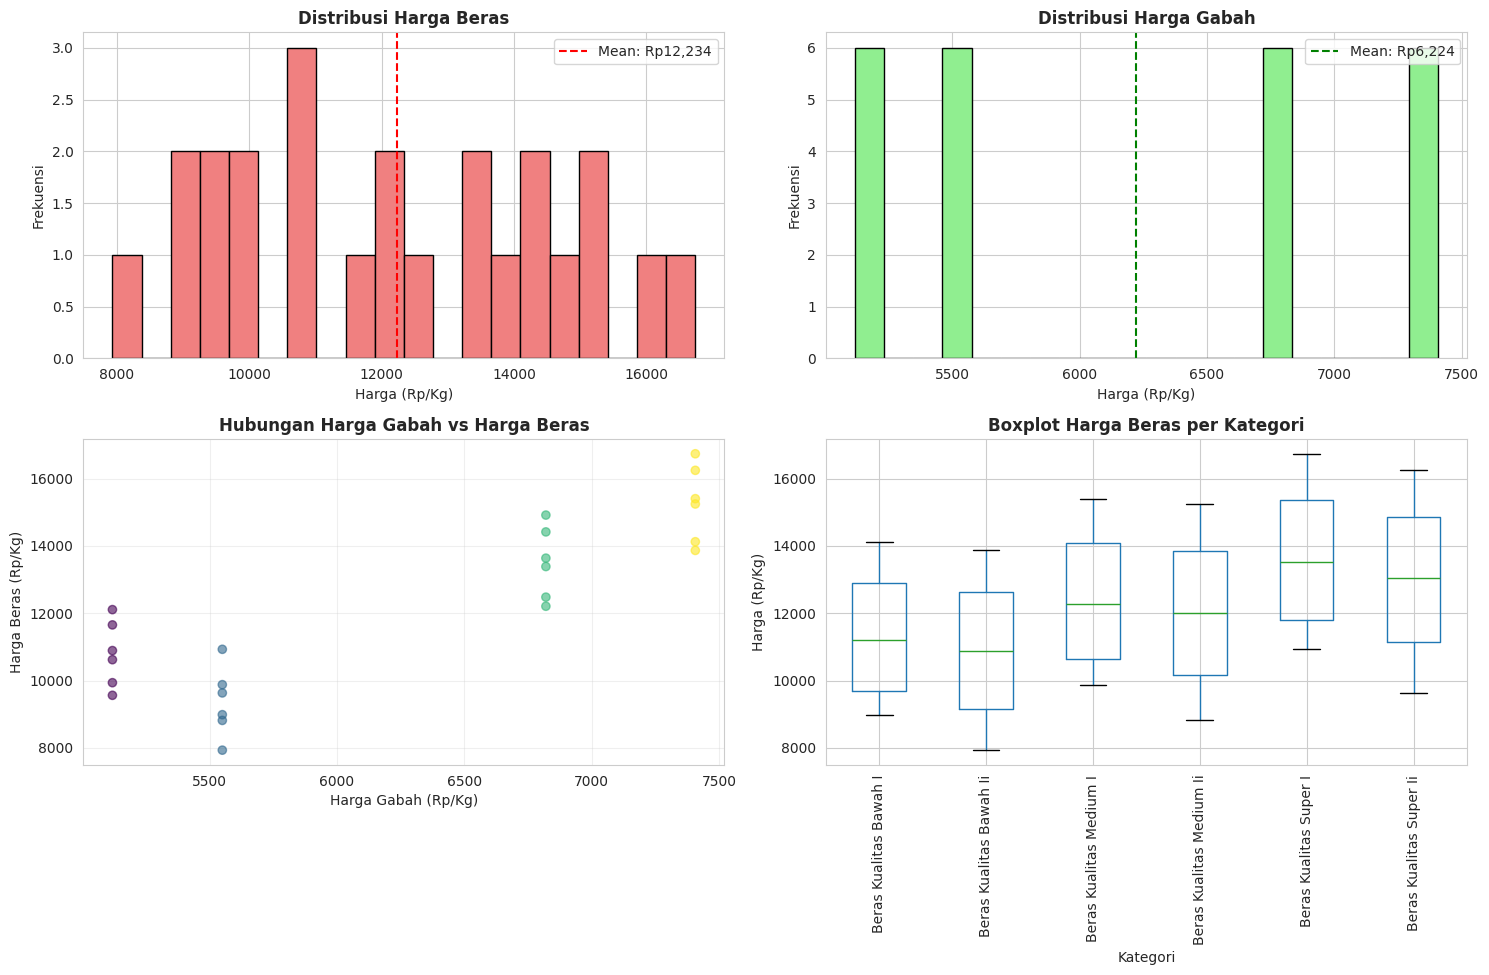

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribusi Harga Beras
axes[0, 0].hist(df_cleaned['Harga Beras (Rp/Kg)'], bins=20, color='lightcoral', edgecolor='black')
axes[0, 0].set_title('Distribusi Harga Beras', fontweight='bold')
axes[0, 0].set_xlabel('Harga (Rp/Kg)')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].axvline(df_cleaned['Harga Beras (Rp/Kg)'].mean(), color='red', linestyle='--', label=f'Mean: Rp{df_cleaned["Harga Beras (Rp/Kg)"].mean():,.0f}')
axes[0, 0].legend()

#Distribusi Harga Gabah
axes[0, 1].hist(df_cleaned['Harga Gabah (Rp/Kg)'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribusi Harga Gabah', fontweight='bold')
axes[0, 1].set_xlabel('Harga (Rp/Kg)')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].axvline(df_cleaned['Harga Gabah (Rp/Kg)'].mean(), color='green', linestyle='--', label=f'Mean: Rp{df_cleaned["Harga Gabah (Rp/Kg)"].mean():,.0f}')
axes[0, 1].legend()

#Harga Beras vs Harga Gabah
axes[1, 0].scatter(df_cleaned['Harga Gabah (Rp/Kg)'], df_cleaned['Harga Beras (Rp/Kg)'],
                   alpha=0.6, c=df_cleaned['Tahun'], cmap='viridis')
axes[1, 0].set_title('Hubungan Harga Gabah vs Harga Beras', fontweight='bold')
axes[1, 0].set_xlabel('Harga Gabah (Rp/Kg)')
axes[1, 0].set_ylabel('Harga Beras (Rp/Kg)')
axes[1, 0].grid(True, alpha=0.3)

#Boxplot Harga Beras per Kategori
df_cleaned.boxplot(column='Harga Beras (Rp/Kg)', by='Kategori', ax=axes[1, 1], rot=90)
axes[1, 1].set_title('Boxplot Harga Beras per Kategori', fontweight='bold')
axes[1, 1].set_xlabel('Kategori')
axes[1, 1].set_ylabel('Harga (Rp/Kg)')
plt.suptitle('')

plt.tight_layout()
plt.show()

###Export Data Cleaned

In [ ]:

# Export ke CSV
output_cleaned = f'{dataset_path}data_cleaned.csv'
df_cleaned.to_csv(output_cleaned, index=False)


#3. Feature Engineering & Calculation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load data cleaned dari fase sebelumnya
df_cleaned = pd.read_csv(f'{dataset_path}data_cleaned.csv')

##3.1 Perhitungan Margin Harga

###A. Hitung Margin Absolut dan Persentase

In [ ]:
df_with_margin = df_cleaned.copy()

print("\nMenghitung Margin Harga")
print("=" * 80)

#MARGIN ABSOLUT (Rp/Kg)
df_with_margin['Margin Absolut (Rp/Kg)'] = (
    df_with_margin['Harga Beras (Rp/Kg)'] - df_with_margin['Harga Gabah (Rp/Kg)']
)

print("Margin Absolut:")
print(f"   Formula: Harga Beras - Harga Gabah")
print(f"   Range: Rp {df_with_margin['Margin Absolut (Rp/Kg)'].min():,.2f} - Rp {df_with_margin['Margin Absolut (Rp/Kg)'].max():,.2f}")

# MARGIN PERSENTASE (%)
df_with_margin['Margin Persentase (%)'] = (
    (df_with_margin['Harga Beras (Rp/Kg)'] - df_with_margin['Harga Gabah (Rp/Kg)']) /
    df_with_margin['Harga Gabah (Rp/Kg)']
) * 100

print("\nMargin Persentase dihitung!")
print(f"   Formula: ((Harga Beras - Harga Gabah) / Harga Gabah) × 100")
print(f"   Range: {df_with_margin['Margin Persentase (%)'].min():.2f}% - {df_with_margin['Margin Persentase (%)'].max():.2f}%")

#Hitung Konversi Rate (untuk informasi tambahan)
df_with_margin['Konversi GKG-Beras'] = 0.65

#Margin per Konversi (biaya konversi per kg)
df_with_margin['Biaya Konversi Per Kg (Rp)'] = (
    df_with_margin['Margin Absolut (Rp/Kg)'] / df_with_margin['Konversi GKG-Beras']
)

print("\nSTATISTIK MARGIN:")
print("=" * 80)
print(f"Margin Absolut:")
print(f"  Mean   : Rp {df_with_margin['Margin Absolut (Rp/Kg)'].mean():,.2f}/Kg")
print(f"  Median : Rp {df_with_margin['Margin Absolut (Rp/Kg)'].median():,.2f}/Kg")
print(f"  Std Dev: Rp {df_with_margin['Margin Absolut (Rp/Kg)'].std():,.2f}/Kg")

print(f"\nMargin Persentase:")
print(f"  Mean   : {df_with_margin['Margin Persentase (%)'].mean():.2f}%")
print(f"  Median : {df_with_margin['Margin Persentase (%)'].median():.2f}%")
print(f"  Std Dev: {df_with_margin['Margin Persentase (%)'].std():.2f}%")


Menghitung Margin Harga
Margin Absolut:
   Formula: Harga Beras - Harga Gabah
   Range: Rp 2,383.51 - Rp 9,331.28

Margin Persentase dihitung!
   Formula: ((Harga Beras - Harga Gabah) / Harga Gabah) × 100
   Range: 42.95% - 136.56%

STATISTIK MARGIN:
Margin Absolut:
  Mean   : Rp 6,010.80/Kg
  Median : Rp 6,116.80/Kg
  Std Dev: Rp 1,806.23/Kg

Margin Persentase:
  Mean   : 95.97%
  Median : 96.62%
  Std Dev: 23.17%


###B. Analisis Margin per Kategori dan Tahun

Margin per kategori

In [ ]:

print("\nMARGIN RATA-RATA PER KATEGORI BERAS:")
print("=" * 80)

margin_by_category = df_with_margin.groupby('Kategori').agg({
    'Margin Absolut (Rp/Kg)': ['mean', 'min', 'max'],
    'Margin Persentase (%)': ['mean', 'min', 'max']
}).round(2)

margin_by_category.columns = ['Margin Abs Mean', 'Margin Abs Min', 'Margin Abs Max',
                                'Margin % Mean', 'Margin % Min', 'Margin % Max']
print(margin_by_category)



MARGIN RATA-RATA PER KATEGORI BERAS:
                          Margin Abs Mean  Margin Abs Min  Margin Abs Max  \
Kategori                                                                    
Beras Kualitas Bawah I            5158.72         3437.67         6718.78   
Beras Kualitas Bawah Ii           4669.14         2383.51         6460.45   
Beras Kualitas Medium I           6229.55         4329.34         7997.95   
Beras Kualitas Medium Ii          5794.14         3266.84         7839.61   
Beras Kualitas Super I            7449.34         5379.34         9331.28   
Beras Kualitas Super Ii           6763.93         4083.51         8839.61   

                          Margin % Mean  Margin % Min  Margin % Max  
Kategori                                                             
Beras Kualitas Bawah I            82.45         61.94         94.15  
Beras Kualitas Bawah Ii           74.00         42.95         87.23  
Beras Kualitas Medium I           99.69         78.01        112.

Margin per Tahun

In [ ]:
margin_by_year = df_with_margin.groupby('Tahun').agg({
    'Margin Absolut (Rp/Kg)': ['mean', 'min', 'max'],
    'Margin Persentase (%)': ['mean', 'min', 'max'],
    'Produksi (ton)': 'mean'
}).round(2)

margin_by_year.columns = ['Margin Abs Mean', 'Margin Abs Min', 'Margin Abs Max',
                          'Margin % Mean', 'Margin % Min', 'Margin % Max', 'Produksi']
print(margin_by_year)

       Margin Abs Mean  Margin Abs Min  Margin Abs Max  Margin % Mean  \
Tahun                                                                   
2021           5677.33         4444.00         6989.83         110.92   
2022           3813.37         2383.51         5379.34          68.71   
2023           6687.90         5388.59         8096.93          98.07   
2024           7864.61         6460.45         9331.28         106.19   

       Margin % Min  Margin % Max   Produksi  
Tahun                                         
2021          86.82        136.56 1600449.83  
2022          42.95         96.93 1564314.22  
2023          79.01        118.73 1384179.90  
2024          87.23        125.99 1362685.91  


Margin per kategori dan tahun

In [ ]:


margin_detail = df_with_margin.pivot_table(
    values=['Margin Absolut (Rp/Kg)', 'Margin Persentase (%)'],
    index='Kategori',
    columns='Tahun',
    aggfunc='mean'
).round(2)

print(margin_detail)

                         Margin Absolut (Rp/Kg)                          \
Tahun                                      2021    2022    2023    2024   
Kategori                                                                  
Beras Kualitas Bawah I                  4819.00 3437.67 5659.43 6718.78   
Beras Kualitas Bawah Ii                 4444.00 2383.51 5388.59 6460.45   
Beras Kualitas Medium I                 5773.16 4329.34 6817.76 7997.95   
Beras Kualitas Medium Ii                5502.33 3266.84 6567.76 7839.61   
Beras Kualitas Super I                  6989.83 5379.34 8096.93 9331.28   
Beras Kualitas Super Ii                 6535.66 4083.51 7596.93 8839.61   

                         Margin Persentase (%)                      
Tahun                                     2021  2022   2023   2024  
Kategori                                                            
Beras Kualitas Bawah I                   94.15 61.94  82.99  90.72  
Beras Kualitas Bawah Ii                  86.82 4

###C. Visualisasi Margin Harga

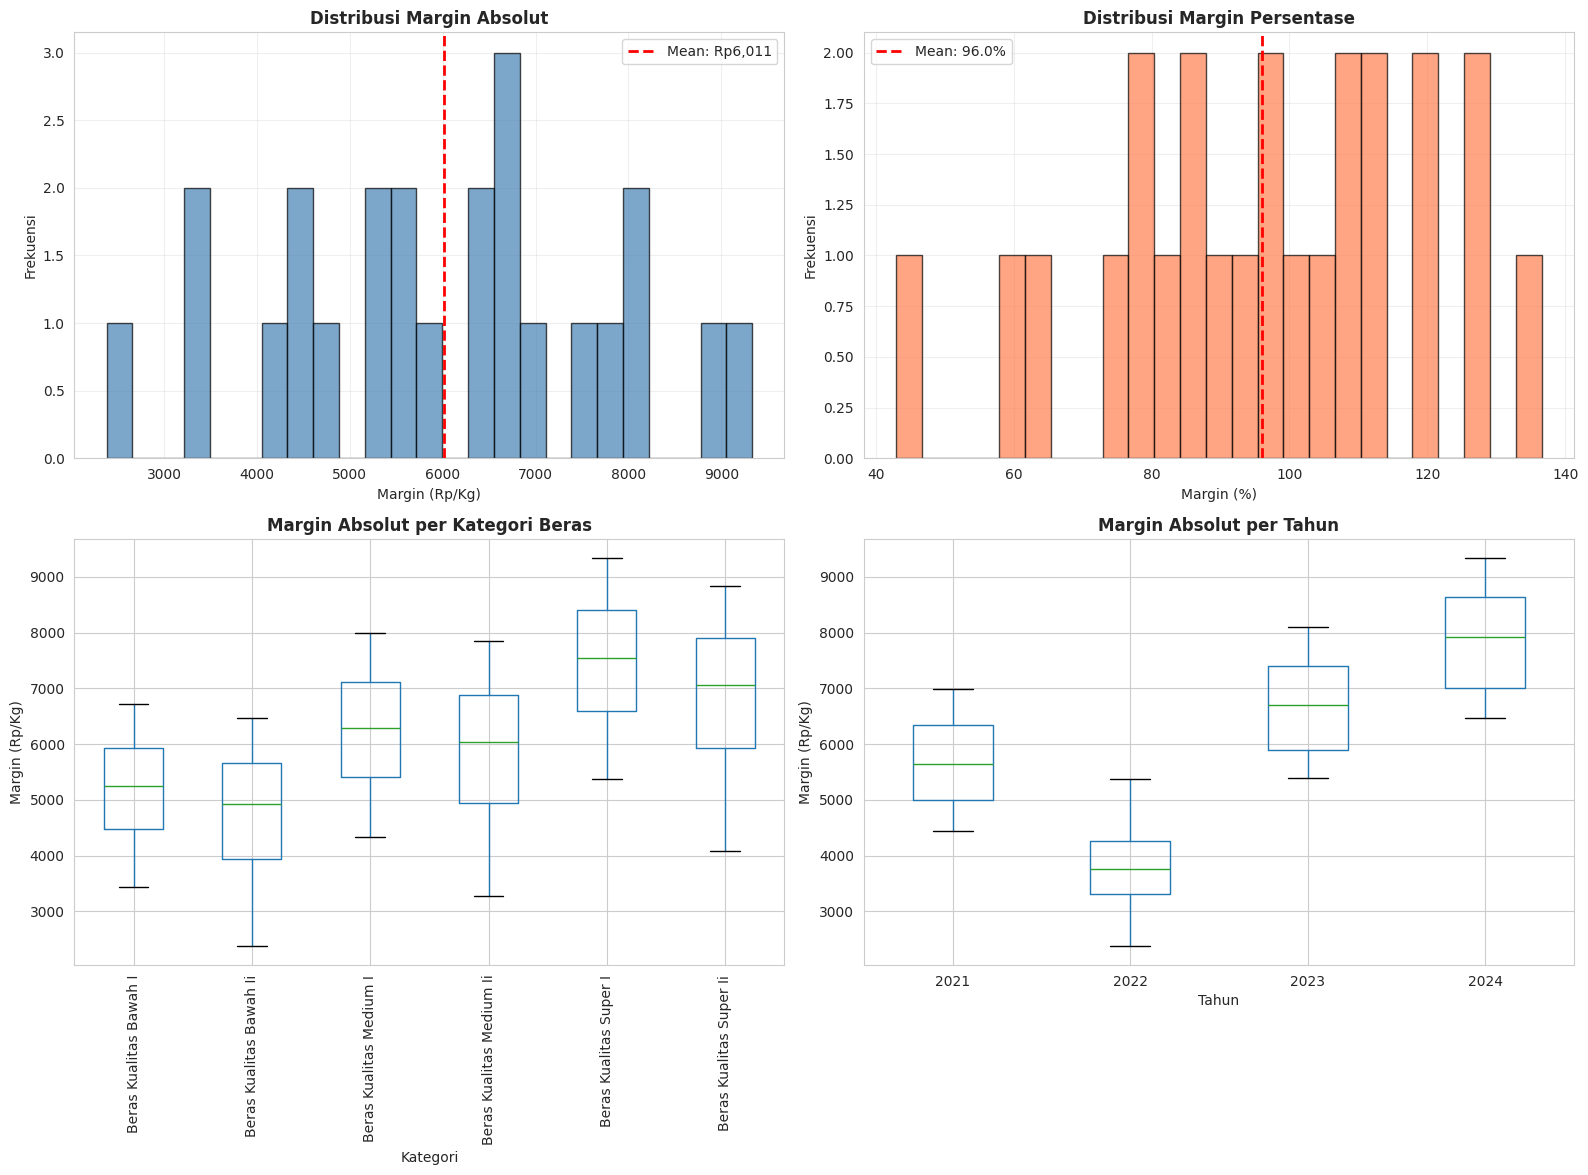

Gambar Visualisasi disimpan


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Distribusi Margin Absolut
axes[0, 0].hist(df_with_margin['Margin Absolut (Rp/Kg)'], bins=25,
                color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_with_margin['Margin Absolut (Rp/Kg)'].mean(),
                   color='red', linestyle='--', linewidth=2,
                   label=f'Mean: Rp{df_with_margin["Margin Absolut (Rp/Kg)"].mean():,.0f}')
axes[0, 0].set_title('Distribusi Margin Absolut', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Margin (Rp/Kg)')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

#Distribusi Margin Persentase
axes[0, 1].hist(df_with_margin['Margin Persentase (%)'], bins=25,
                color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df_with_margin['Margin Persentase (%)'].mean(),
                   color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {df_with_margin["Margin Persentase (%)"].mean():.1f}%')
axes[0, 1].set_title('Distribusi Margin Persentase', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Margin (%)')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

#Boxplot Margin Absolut per Kategori
df_with_margin.boxplot(column='Margin Absolut (Rp/Kg)', by='Kategori',
                        ax=axes[1, 0], rot=90)
axes[1, 0].set_title('Margin Absolut per Kategori Beras', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Kategori')
axes[1, 0].set_ylabel('Margin (Rp/Kg)')
plt.suptitle('')

#Boxplot Margin Absolut per Tahun
df_with_margin.boxplot(column='Margin Absolut (Rp/Kg)', by='Tahun',
                        ax=axes[1, 1])
axes[1, 1].set_title('Margin Absolut per Tahun', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tahun')
axes[1, 1].set_ylabel('Margin (Rp/Kg)')
plt.suptitle('')

plt.tight_layout()
plt.savefig(f'{visualisasi_path}margin_analysis_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gambar Visualisasi disimpan")

###D. Identifikasi Outliers Margin

Menggunakan metode IQR (Interquartile Range)

In [ ]:
Q1_abs = df_with_margin['Margin Absolut (Rp/Kg)'].quantile(0.25)
Q3_abs = df_with_margin['Margin Absolut (Rp/Kg)'].quantile(0.75)
IQR_abs = Q3_abs - Q1_abs

Q1_pct = df_with_margin['Margin Persentase (%)'].quantile(0.25)
Q3_pct = df_with_margin['Margin Persentase (%)'].quantile(0.75)
IQR_pct = Q3_pct - Q1_pct

Define outliers

In [ ]:
lower_bound_abs = Q1_abs - 1.5 * IQR_abs
upper_bound_abs = Q3_abs + 1.5 * IQR_abs

lower_bound_pct = Q1_pct - 1.5 * IQR_pct
upper_bound_pct = Q3_pct + 1.5 * IQR_pct

outliers_abs = df_with_margin[
    (df_with_margin['Margin Absolut (Rp/Kg)'] < lower_bound_abs) |
    (df_with_margin['Margin Absolut (Rp/Kg)'] > upper_bound_abs)
]

print(f"Margin Absolut Outliers:")
print(f"  Lower Bound: Rp {lower_bound_abs:,.2f}")
print(f"  Upper Bound: Rp {upper_bound_abs:,.2f}")
print(f"  Jumlah Outliers: {len(outliers_abs)}")

if len(outliers_abs) > 0:
    print("\n  Data Outliers:")
    print(outliers_abs[['Tahun', 'Kategori', 'Margin Absolut (Rp/Kg)', 'Margin Persentase (%)']].to_string(index=False))
else:
    print("  ✅ Tidak ada outliers signifikan")

Margin Absolut Outliers:
  Lower Bound: Rp 1,100.71
  Upper Bound: Rp 10,766.14
  Jumlah Outliers: 0
  ✅ Tidak ada outliers signifikan


##3.2 Agregasi Data per Tahun

###A. Agregasi Margin per Tahun

In [ ]:

# Agregasi per tahun
yearly_aggregation = df_with_margin.groupby('Tahun').agg({
    'Margin Absolut (Rp/Kg)': ['mean', 'median', 'std', 'min', 'max'],
    'Margin Persentase (%)': ['mean', 'median', 'std', 'min', 'max'],
    'Produksi (ton)': ['mean', 'min', 'max'],
    'Harga Beras (Rp/Kg)': 'mean',
    'Harga Gabah (Rp/Kg)': 'mean',
    'Kategori': 'count'
}).round(2)

# Rename kolom untuk clarity
yearly_aggregation.columns = [
    'Margin Abs Mean', 'Margin Abs Median', 'Margin Abs Std', 'Margin Abs Min', 'Margin Abs Max',
    'Margin % Mean', 'Margin % Median', 'Margin % Std', 'Margin % Min', 'Margin % Max',
    'Produksi Mean', 'Produksi Min', 'Produksi Max',
    'Harga Beras Mean', 'Harga Gabah Mean', 'Jumlah Data'
]

print("\nAGREGASI LENGKAP PER TAHUN:")
print("=" * 80)
print(yearly_aggregation)

yearly_aggregation.to_csv(f'{dataset_path}yearly_aggregation.csv')
print("\nsave yearly_aggregation.csv")


AGREGASI LENGKAP PER TAHUN:
       Margin Abs Mean  Margin Abs Median  Margin Abs Std  Margin Abs Min  \
Tahun                                                                       
2021           5677.33            5637.74          975.40         4444.00   
2022           3813.37            3760.59         1027.21         2383.51   
2023           6687.90            6692.76         1057.25         5388.59   
2024           7864.61            7918.78         1131.79         6460.45   

       Margin Abs Max  Margin % Mean  Margin % Median  Margin % Std  \
Tahun                                                                 
2021          6989.83         110.92           110.14         19.06   
2022          5379.34          68.71            67.76         18.51   
2023          8096.93          98.07            98.14         15.50   
2024          9331.28         106.19           106.92         15.28   

       Margin % Min  Margin % Max  Produksi Mean  Produksi Min  Produksi Max  \
T

###B. Analisis Trend Tahunan

In [ ]:
yearly_summary = df_with_margin.groupby('Tahun').agg({
    'Margin Absolut (Rp/Kg)': 'mean',
   'Margin Persentase (%)': 'mean',
    'Produksi (ton)': 'mean',
    'Harga Beras (Rp/Kg)': 'mean',
    'Harga Gabah (Rp/Kg)': 'mean'
}).round(2)

# Hitung perubahan year-over-year
yearly_summary['Δ Margin Abs (%)'] = yearly_summary['Margin Absolut (Rp/Kg)'].pct_change() * 100
yearly_summary['Δ Produksi (%)'] = yearly_summary['Produksi (ton)'].pct_change() * 100
yearly_summary['Δ Harga Beras (%)'] = yearly_summary['Harga Beras (Rp/Kg)'].pct_change() * 100
yearly_summary['Δ Harga Gabah (%)'] = yearly_summary['Harga Gabah (Rp/Kg)'].pct_change() * 100

print("\nSUMMARY TAHUNAN DENGAN PERUBAHAN YoY:")
print("=" * 80)
print(yearly_summary)

# Interpretasi trend
print("\n" + "=" * 80)
print("INTERPRETASI TREND:")
print("=" * 80)

for year in yearly_summary.index[1:]:
    margin_change = yearly_summary.loc[year, 'Δ Margin Abs (%)']
    prod_change = yearly_summary.loc[year, 'Δ Produksi (%)']

    print(f"\nTahun {year}:")
    print(f"   Margin: {'↑' if margin_change > 0 else '↓'} {abs(margin_change):.2f}%")
    print(f"   Produksi: {'↑' if prod_change > 0 else '↓'} {abs(prod_change):.2f}%")

    # Analisis hubungan
    if (margin_change > 0 and prod_change < 0):
        print(f"   Margin NAIK saat produksi TURUN → Potensi inefisiensi distribusi!")
    elif (margin_change < 0 and prod_change > 0):
        print(f"   Margin TURUN saat produksi NAIK → Efisiensi meningkat")
    elif (margin_change > 0 and prod_change > 0):
        print(f"   Margin & produksi NAIK → Peningkatan permintaan/biaya")
    else:
        print(f"   Margin & produksi TURUN → Kondisi pasar menurun")


SUMMARY TAHUNAN DENGAN PERUBAHAN YoY:
       Margin Absolut (Rp/Kg)  Margin Persentase (%)  Produksi (ton)  \
Tahun                                                                  
2021                  5677.33                 110.92      1600449.83   
2022                  3813.37                  68.71      1564314.22   
2023                  6687.90                  98.07      1384179.90   
2024                  7864.61                 106.19      1362685.91   

       Harga Beras (Rp/Kg)  Harga Gabah (Rp/Kg)  Δ Margin Abs (%)  \
Tahun                                                               
2021              10795.83              5118.50               NaN   
2022               9363.19              5549.82            -32.83   
2023              13507.64              6819.74             75.38   
2024              15270.83              7406.22             17.59   

       Δ Produksi (%)  Δ Harga Beras (%)  Δ Harga Gabah (%)  
Tahun                                              

###C. Visualisasi Trend Tahunan

VISUALISASI TREND TAHUNAN


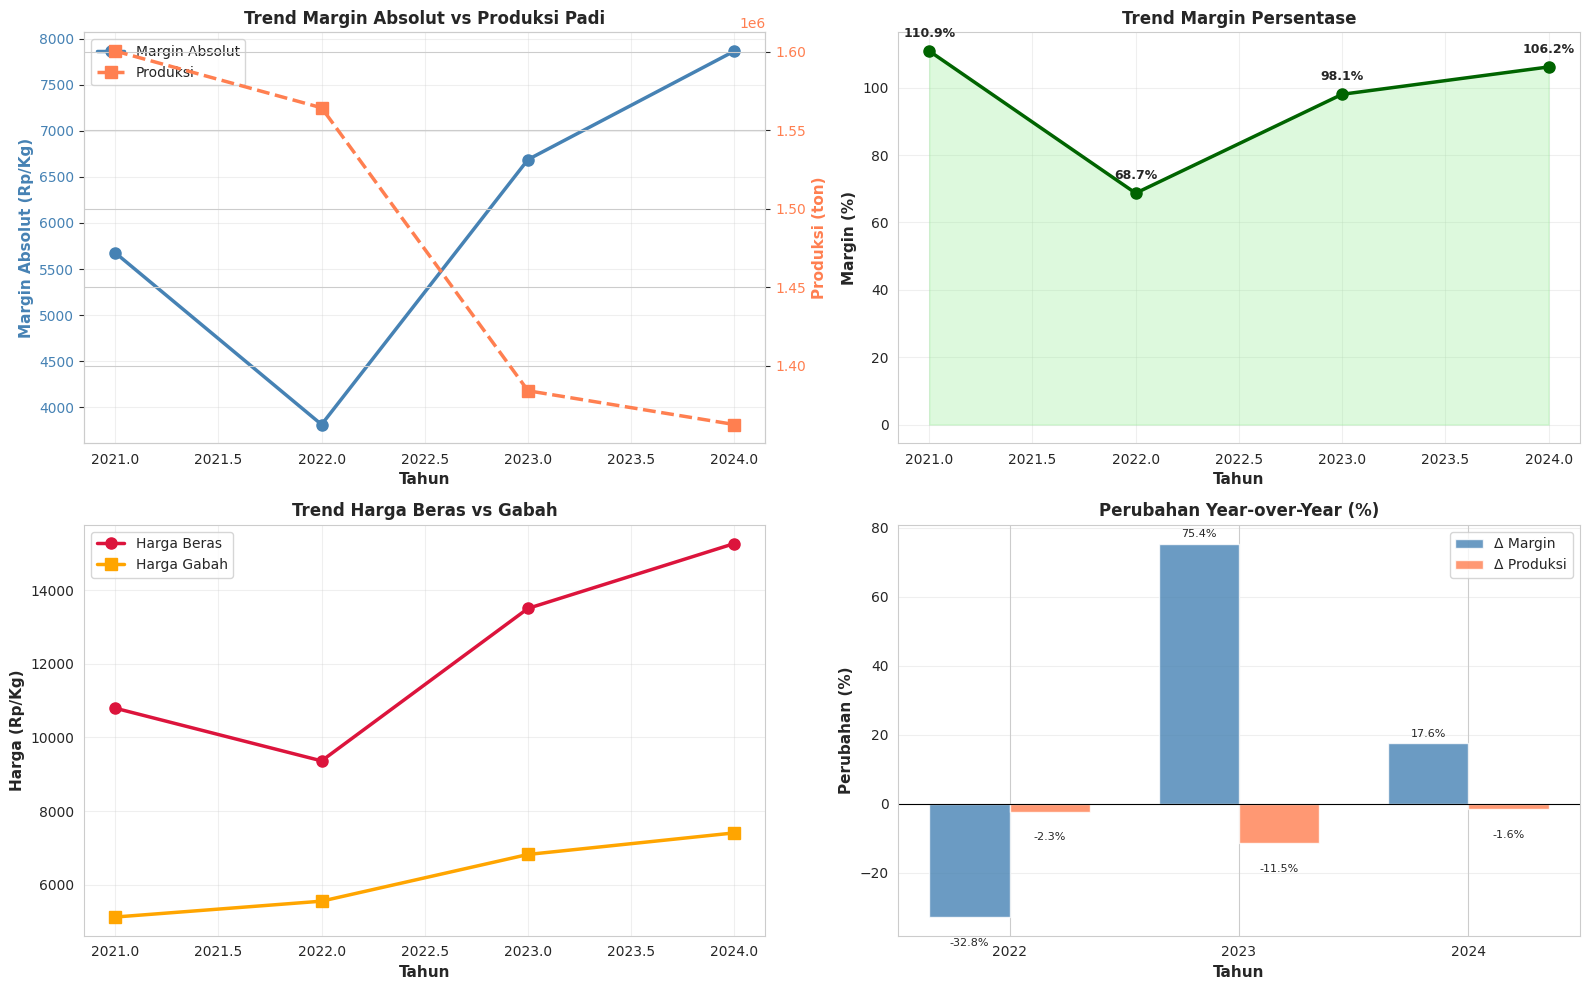


Visualisasi trend tahunan selesai!
   File disimpan: yearly_trend_analysis.png


In [ ]:
print("VISUALISASI TREND TAHUNAN")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

#Trend Margin Absolut vs Produksi
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

line1 = ax1.plot(yearly_summary.index, yearly_summary['Margin Absolut (Rp/Kg)'],
                 marker='o', linewidth=2.5, markersize=8, color='steelblue',
                 label='Margin Absolut')
line2 = ax1_twin.plot(yearly_summary.index, yearly_summary['Produksi (ton)'],
                      marker='s', linewidth=2.5, markersize=8, color='coral',
                      label='Produksi', linestyle='--')

ax1.set_xlabel('Tahun', fontsize=11, fontweight='bold')
ax1.set_ylabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold', color='steelblue')
ax1_twin.set_ylabel('Produksi (ton)', fontsize=11, fontweight='bold', color='coral')
ax1.set_title('Trend Margin Absolut vs Produksi Padi', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1_twin.tick_params(axis='y', labelcolor='coral')
ax1.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

#Trend Margin Persentase
ax2 = axes[0, 1]
ax2.plot(yearly_summary.index, yearly_summary['Margin Persentase (%)'],
         marker='o', linewidth=2.5, markersize=8, color='darkgreen')
ax2.fill_between(yearly_summary.index, yearly_summary['Margin Persentase (%)'],
                 alpha=0.3, color='lightgreen')
ax2.set_xlabel('Tahun', fontsize=11, fontweight='bold')
ax2.set_ylabel('Margin (%)', fontsize=11, fontweight='bold')
ax2.set_title('Trend Margin Persentase', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

for idx in yearly_summary.index:
    value = yearly_summary.loc[idx, 'Margin Persentase (%)']
    ax2.annotate(f'{value:.1f}%',
                xy=(idx, value),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                fontweight='bold')

#Trend Harga Beras vs Gabah
ax3 = axes[1, 0]
ax3.plot(yearly_summary.index, yearly_summary['Harga Beras (Rp/Kg)'],
         marker='o', linewidth=2.5, markersize=8, label='Harga Beras', color='crimson')
ax3.plot(yearly_summary.index, yearly_summary['Harga Gabah (Rp/Kg)'],
         marker='s', linewidth=2.5, markersize=8, label='Harga Gabah', color='orange')
ax3.set_xlabel('Tahun', fontsize=11, fontweight='bold')
ax3.set_ylabel('Harga (Rp/Kg)', fontsize=11, fontweight='bold')
ax3.set_title('Trend Harga Beras vs Gabah', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

#Perubahan YoY (%)
ax4 = axes[1, 1]
x = np.arange(len(yearly_summary.index[1:]))
width = 0.35

bars1 = ax4.bar(x - width/2, yearly_summary['Δ Margin Abs (%)'].dropna(),
                width, label='Δ Margin', color='steelblue', alpha=0.8)
bars2 = ax4.bar(x + width/2, yearly_summary['Δ Produksi (%)'].dropna(),
                width, label='Δ Produksi', color='coral', alpha=0.8)

ax4.set_xlabel('Tahun', fontsize=11, fontweight='bold')
ax4.set_ylabel('Perubahan (%)', fontsize=11, fontweight='bold')
ax4.set_title('Perubahan Year-over-Year (%)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(yearly_summary.index[1:])
ax4.legend()
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax4.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=8)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}yearly_trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi trend tahunan selesai!")
print("   File disimpan: yearly_trend_analysis.png")

##3.3 Data Transformation

###A. Pivot Tables untuk Analisis Temporal

In [ ]:
#PIVOT: Margin Absolut per Kategori dan Tahun
pivot_margin_abs = df_with_margin.pivot_table(
    values='Margin Absolut (Rp/Kg)',
    index='Kategori',
    columns='Tahun',
    aggfunc='mean'
).round(2)

print("\nPIVOT: Margin Absolut (Rp/Kg) per Kategori × Tahun")
print("=" * 80)
print(pivot_margin_abs)

#PIVOT: Margin Persentase per Kategori dan Tahun
pivot_margin_pct = df_with_margin.pivot_table(
    values='Margin Persentase (%)',
    index='Kategori',
    columns='Tahun',
    aggfunc='mean'
).round(2)

print("\nPIVOT: Margin Persentase (%) per Kategori × Tahun")
print("=" * 80)
print(pivot_margin_pct)

#PIVOT: Harga Beras per Kategori dan Tahun
pivot_harga_beras = df_with_margin.pivot_table(
    values='Harga Beras (Rp/Kg)',
    index='Kategori',
    columns='Tahun',
    aggfunc='mean'
).round(2)

print("\nPIVOT: Harga Beras (Rp/Kg) per Kategori × Tahun")
print("=" * 80)
print(pivot_harga_beras)

# Export pivot tables
pivot_margin_abs.to_csv(f'{dataset_path}pivot_margin_absolut.csv')
pivot_margin_pct.to_csv(f'{dataset_path}pivot_margin_persentase.csv')
pivot_harga_beras.to_csv(f'{dataset_path}pivot_harga_beras.csv')

print("\n Pivot tables berhasil disimpan:")


PIVOT: Margin Absolut (Rp/Kg) per Kategori × Tahun
Tahun                       2021    2022    2023    2024
Kategori                                                
Beras Kualitas Bawah I   4819.00 3437.67 5659.43 6718.78
Beras Kualitas Bawah Ii  4444.00 2383.51 5388.59 6460.45
Beras Kualitas Medium I  5773.16 4329.34 6817.76 7997.95
Beras Kualitas Medium Ii 5502.33 3266.84 6567.76 7839.61
Beras Kualitas Super I   6989.83 5379.34 8096.93 9331.28
Beras Kualitas Super Ii  6535.66 4083.51 7596.93 8839.61

PIVOT: Margin Persentase (%) per Kategori × Tahun
Tahun                      2021  2022   2023   2024
Kategori                                           
Beras Kualitas Bawah I    94.15 61.94  82.99  90.72
Beras Kualitas Bawah Ii   86.82 42.95  79.01  87.23
Beras Kualitas Medium I  112.79 78.01  99.97 107.99
Beras Kualitas Medium Ii 107.50 58.86  96.31 105.85
Beras Kualitas Super I   136.56 96.93 118.73 125.99
Beras Kualitas Super Ii  127.69 73.58 111.40 119.35

PIVOT: Harga Beras (Rp/K

###B. Heatmap Pivot Tables

VISUALISASI PIVOT TABLES (HEATMAP)


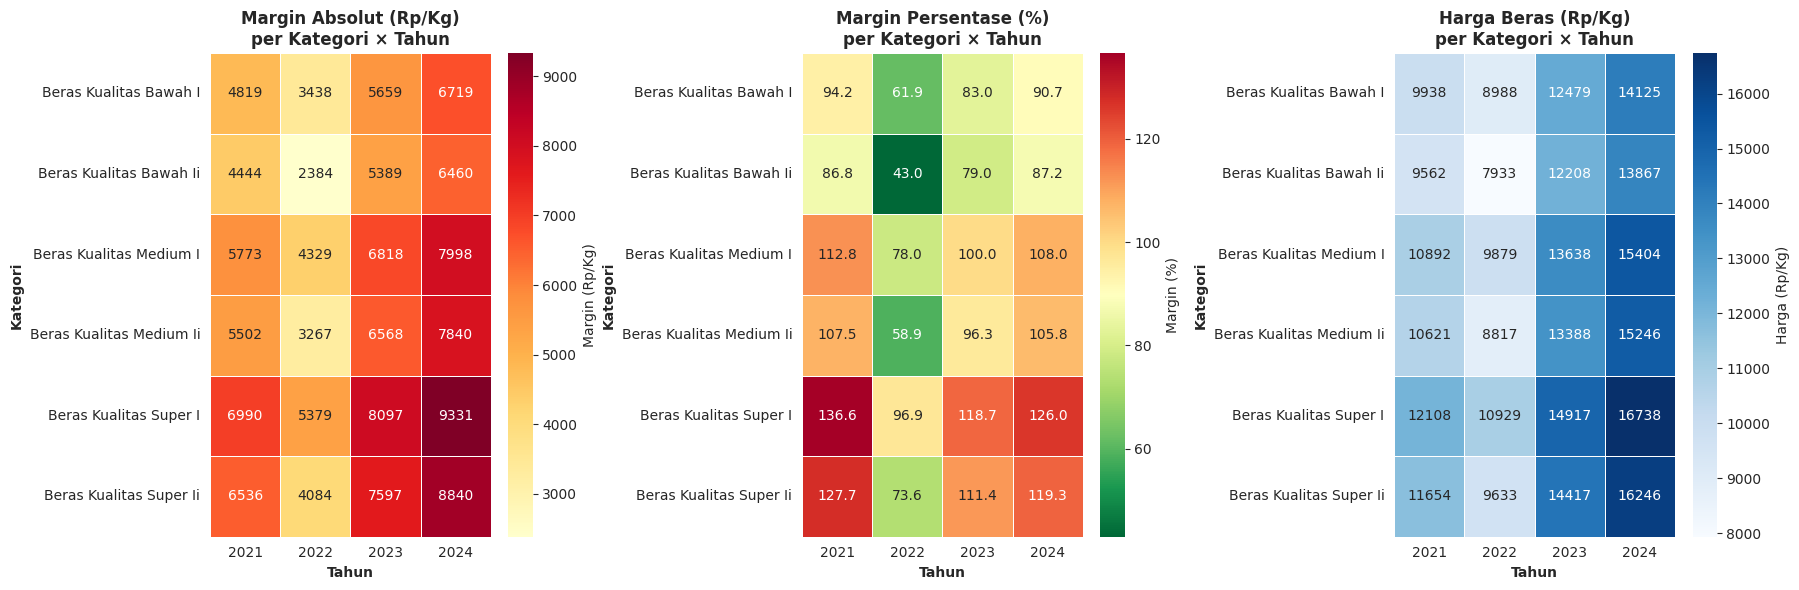

File disimpan: pivot_heatmaps.png


In [ ]:
print("VISUALISASI PIVOT TABLES (HEATMAP)")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Heatmap Margin Absolut
sns.heatmap(pivot_margin_abs, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Margin (Rp/Kg)'}, ax=axes[0], linewidths=0.5)
axes[0].set_title('Margin Absolut (Rp/Kg)\nper Kategori × Tahun',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tahun', fontweight='bold')
axes[0].set_ylabel('Kategori', fontweight='bold')

# Heatmap Margin Persentase
sns.heatmap(pivot_margin_pct, annot=True, fmt='.1f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Margin (%)'}, ax=axes[1], linewidths=0.5)
axes[1].set_title('Margin Persentase (%)\nper Kategori × Tahun',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tahun', fontweight='bold')
axes[1].set_ylabel('Kategori', fontweight='bold')

# Heatmap Harga Beras
sns.heatmap(pivot_harga_beras, annot=True, fmt='.0f', cmap='Blues',
            cbar_kws={'label': 'Harga (Rp/Kg)'}, ax=axes[2], linewidths=0.5)
axes[2].set_title('Harga Beras (Rp/Kg)\nper Kategori × Tahun',
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('Tahun', fontweight='bold')
axes[2].set_ylabel('Kategori', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{visualisasi_path}pivot_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("File disimpan: pivot_heatmaps.png")

###C. Dataset untuk Analisis Korelasi

In [ ]:
# Dataset untuk korelasi: Agregasi per tahun (simplified)
correlation_dataset = yearly_summary[[
    'Margin Absolut (Rp/Kg)',
    'Margin Persentase (%)',
    'Produksi (ton)',
    'Harga Beras (Rp/Kg)',
    'Harga Gabah (Rp/Kg)'
]].copy()

correlation_dataset['Tahun_Numeric'] = correlation_dataset.index
print("\nDATASET KORELASI (per Tahun):")
print("=" * 80)
print(correlation_dataset)

correlation_matrix = correlation_dataset.corr().round(3)
# Highlight key correlations
print("\nKEY CORRELATIONS:")
print("=" * 80)
print(f"Margin Absolut vs Produksi: {correlation_matrix.loc['Margin Absolut (Rp/Kg)', 'Produksi (ton)']:.3f}")
print(f"Margin % vs Produksi: {correlation_matrix.loc['Margin Persentase (%)', 'Produksi (ton)']:.3f}")
print(f"Harga Beras vs Harga Gabah: {correlation_matrix.loc['Harga Beras (Rp/Kg)', 'Harga Gabah (Rp/Kg)']:.3f}")

margin_prod_corr = correlation_matrix.loc['Margin Absolut (Rp/Kg)', 'Produksi (ton)']

correlation_dataset.to_csv(f'{dataset_path}correlation_dataset.csv')


DATASET KORELASI (per Tahun):
       Margin Absolut (Rp/Kg)  Margin Persentase (%)  Produksi (ton)  \
Tahun                                                                  
2021                  5677.33                 110.92      1600449.83   
2022                  3813.37                  68.71      1564314.22   
2023                  6687.90                  98.07      1384179.90   
2024                  7864.61                 106.19      1362685.91   

       Harga Beras (Rp/Kg)  Harga Gabah (Rp/Kg)  Tahun_Numeric  
Tahun                                                           
2021              10795.83              5118.50           2021  
2022               9363.19              5549.82           2022  
2023              13507.64              6819.74           2023  
2024              15270.83              7406.22           2024  

KEY CORRELATIONS:
Margin Absolut vs Produksi: -0.809
Margin % vs Produksi: -0.274
Harga Beras vs Harga Gabah: 0.925


###D. Visualisasi Correlation Matrix

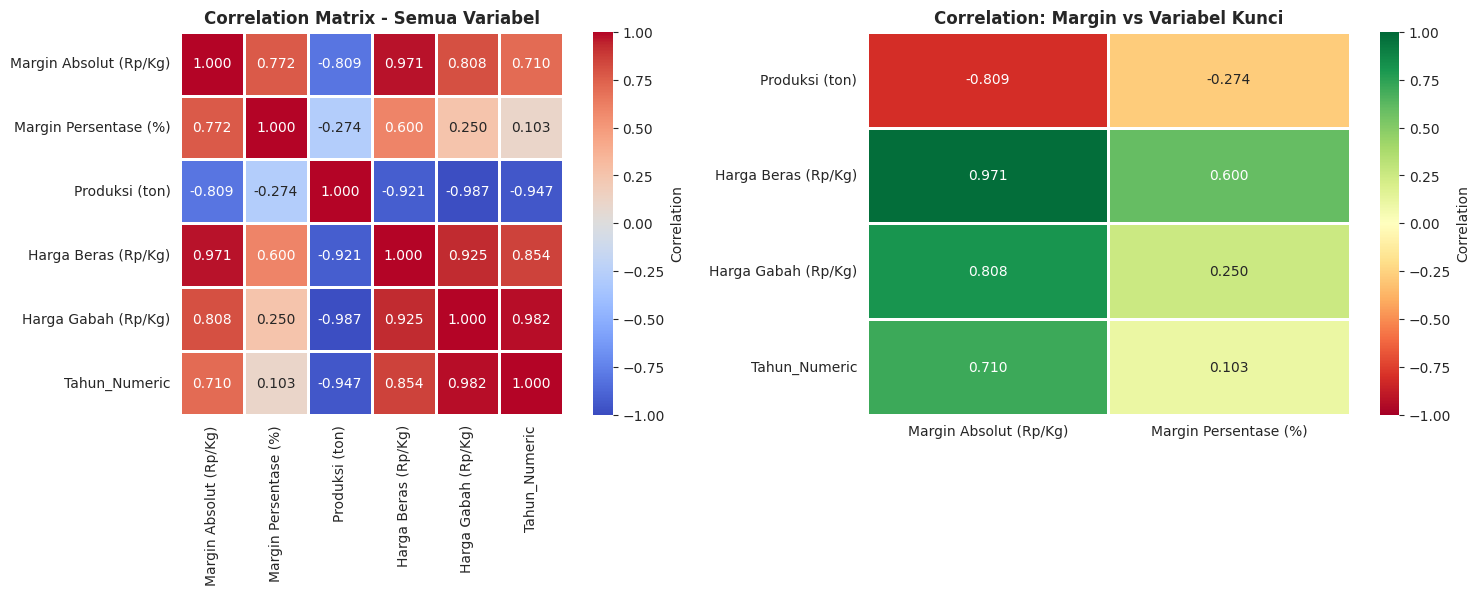

   File disimpan: correlation_matrix_visualization.png


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Heatmap Correlation Matrix (Full)
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=axes[0])
axes[0].set_title('Correlation Matrix - Semua Variabel', fontsize=12, fontweight='bold')

#Focus: Margin vs Key Variables
focus_corr = correlation_matrix[['Margin Absolut (Rp/Kg)', 'Margin Persentase (%)']].copy()
focus_corr = focus_corr[focus_corr.index != 'Margin Absolut (Rp/Kg)']
focus_corr = focus_corr[focus_corr.index != 'Margin Persentase (%)']

sns.heatmap(focus_corr, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, vmin=-1, vmax=1,
            linewidths=1, cbar_kws={'label': 'Correlation'}, ax=axes[1])
axes[1].set_title('Correlation: Margin vs Variabel Kunci', fontsize=12, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig(f'{visualisasi_path}correlation_matrix_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("   File disimpan: correlation_matrix_visualization.png")

###E. Dataset Terpisah untuk Analisis Lanjutan

In [ ]:
# DATASET: Margin Detail (semua data dengan feature engineering)
df_margin_detail = df_with_margin.copy()
df_margin_detail = df_margin_detail.sort_values(['Tahun', 'Kategori'])

print(f"   Dimensi: {df_margin_detail.shape}")
print(f"   Kolom: {df_margin_detail.columns.tolist()}")

#DATASET: Yearly Aggregate (untuk analisis time series)
df_yearly = yearly_summary.reset_index()
df_yearly = df_yearly.rename(columns={'index': 'Tahun'})

print(f"   Dimensi: {df_yearly.shape}")
print(df_yearly)

# DATASET: Category Comparison (perbandingan antar kategori)
df_category_comparison = df_with_margin.groupby('Kategori').agg({
    'Margin Absolut (Rp/Kg)': ['mean', 'std', 'min', 'max'],
    'Margin Persentase (%)': ['mean', 'std', 'min', 'max'],
    'Harga Beras (Rp/Kg)': 'mean',
    'Harga Gabah (Rp/Kg)': 'mean'
}).round(2)

df_category_comparison.columns = [
    'Margin Abs Mean', 'Margin Abs Std', 'Margin Abs Min', 'Margin Abs Max',
    'Margin % Mean', 'Margin % Std', 'Margin % Min', 'Margin % Max',
    'Harga Beras Avg', 'Harga Gabah Avg'
]

print(df_category_comparison)

# DATASET: Margin Efficiency Score (skor efisiensi margin)
df_margin_detail['Efficiency Score'] = (
    100 - df_margin_detail['Margin Persentase (%)']
)
def categorize_efficiency(score):
    if score >= 80:
        return 'Sangat Efisien'
    elif score >= 70:
        return 'Efisien'
    elif score >= 60:
        return 'Cukup Efisien'
    else:
        return 'Kurang Efisien'

df_margin_detail['Kategori Efisiensi'] = df_margin_detail['Efficiency Score'].apply(categorize_efficiency)

print(df_margin_detail['Kategori Efisiensi'].value_counts())

df_margin_detail.to_csv(f'{dataset_path}dataset_margin_detail.csv', index=False)
df_yearly.to_csv(f'{dataset_path}dataset_yearly_aggregate.csv', index=False)
df_category_comparison.to_csv(f'{dataset_path}dataset_category_comparison.csv')

   Dimensi: (24, 9)
   Kolom: ['Tahun', 'Produksi (ton)', 'Kategori', 'Harga Beras (Rp/Kg)', 'Harga Gabah (Rp/Kg)', 'Margin Absolut (Rp/Kg)', 'Margin Persentase (%)', 'Konversi GKG-Beras', 'Biaya Konversi Per Kg (Rp)']
   Dimensi: (4, 10)
   Tahun  Margin Absolut (Rp/Kg)  Margin Persentase (%)  Produksi (ton)  \
0   2021                 5677.33                 110.92      1600449.83   
1   2022                 3813.37                  68.71      1564314.22   
2   2023                 6687.90                  98.07      1384179.90   
3   2024                 7864.61                 106.19      1362685.91   

   Harga Beras (Rp/Kg)  Harga Gabah (Rp/Kg)  Δ Margin Abs (%)  Δ Produksi (%)  \
0             10795.83              5118.50               NaN             NaN   
1              9363.19              5549.82            -32.83           -2.26   
2             13507.64              6819.74             75.38          -11.52   
3             15270.83              7406.22             17.59

###F. Reshape Data untuk Visualisasi Advanced

In [ ]:
#LONG FORMAT: Untuk line plots dengan multiple categories
df_long_format = df_with_margin.copy()
df_long_format = df_long_format[['Tahun', 'Kategori', 'Margin Absolut (Rp/Kg)', 'Margin Persentase (%)']]

print(f"   Shape: {df_long_format.shape}")
print(df_long_format.head(10))

#WIDE FORMAT: Untuk heatmap dan comparison
df_wide_margin = pivot_margin_abs.reset_index()
df_wide_margin.columns.name = None

print(df_wide_margin)

#STACKED FORMAT: Untuk stacked bar charts
df_stacked = df_with_margin.pivot_table(
    values='Margin Absolut (Rp/Kg)',
    index='Tahun',
    columns='Kategori',
    aggfunc='mean'
)

print(df_stacked)

df_long_format.to_csv(f'{dataset_path}data_long_format.csv', index=False)
df_wide_margin.to_csv(f'{dataset_path}data_wide_format.csv', index=False)


   Shape: (24, 4)
   Tahun                  Kategori  Margin Absolut (Rp/Kg)  \
0   2021    Beras Kualitas Bawah I                 4818.99   
1   2021   Beras Kualitas Bawah Ii                 4443.99   
2   2021   Beras Kualitas Medium I                 5773.16   
3   2021  Beras Kualitas Medium Ii                 5502.33   
4   2021    Beras Kualitas Super I                 6989.83   
5   2021   Beras Kualitas Super Ii                 6535.66   
6   2022    Beras Kualitas Bawah I                 3437.67   
7   2022   Beras Kualitas Bawah Ii                 2383.51   
8   2022   Beras Kualitas Medium I                 4329.34   
9   2022  Beras Kualitas Medium Ii                 3266.84   

   Margin Persentase (%)  
0                  94.15  
1                  86.82  
2                 112.79  
3                 107.50  
4                 136.56  
5                 127.69  
6                  61.94  
7                  42.95  
8                  78.01  
9                  58.86  
  

###G. Visualisasi Multi-Category Line Plot

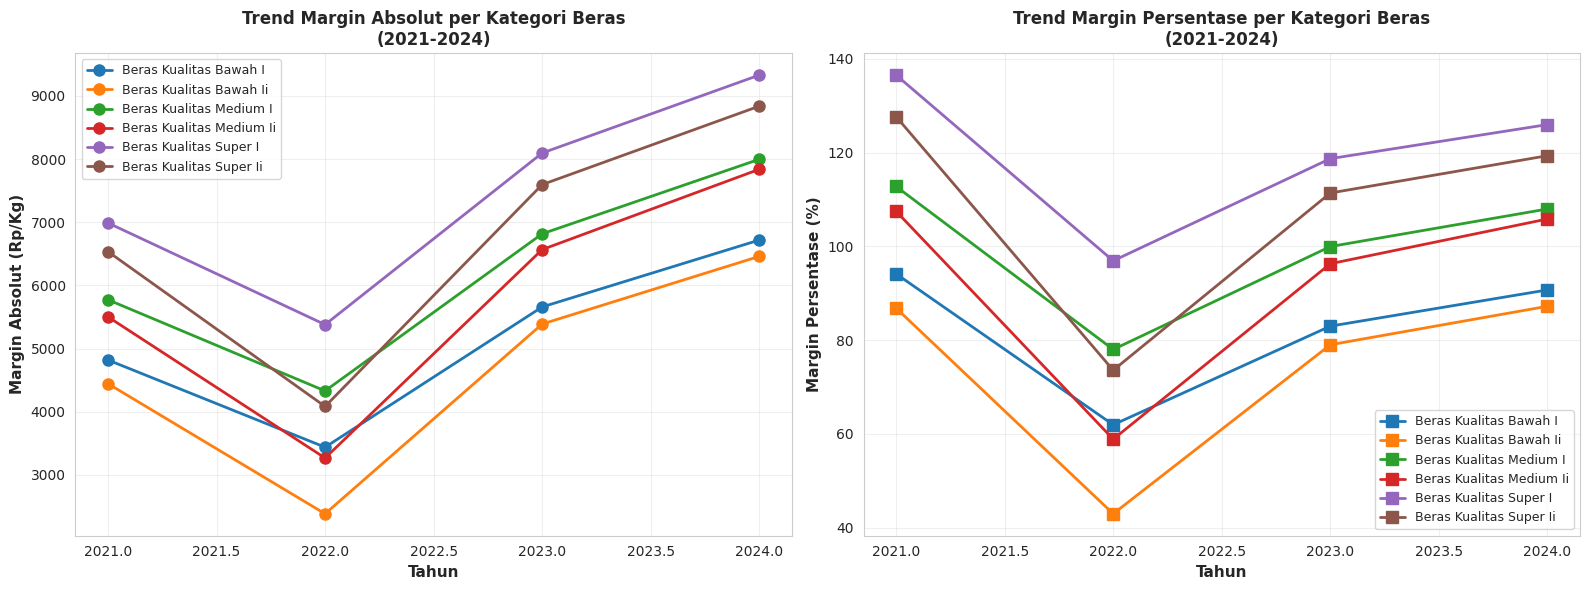

   File disimpan: multi_category_margin_trends.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Line plot: Margin Absolut per Kategori
for kategori in df_long_format['Kategori'].unique():
    data = df_long_format[df_long_format['Kategori'] == kategori]
    axes[0].plot(data['Tahun'], data['Margin Absolut (Rp/Kg)'],
                 marker='o', linewidth=2, markersize=8, label=kategori)

axes[0].set_xlabel('Tahun', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold')
axes[0].set_title('Trend Margin Absolut per Kategori Beras\n(2021-2024)',
                  fontsize=12, fontweight='bold')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

#Line plot: Margin Persentase per Kategori
for kategori in df_long_format['Kategori'].unique():
    data = df_long_format[df_long_format['Kategori'] == kategori]
    axes[1].plot(data['Tahun'], data['Margin Persentase (%)'],
                 marker='s', linewidth=2, markersize=8, label=kategori)

axes[1].set_xlabel('Tahun', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Margin Persentase (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Trend Margin Persentase per Kategori Beras\n(2021-2024)',
                  fontsize=12, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}multi_category_margin_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("   File disimpan: multi_category_margin_trends.png")

#**4. Data Exploration**

##4.1 setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

In [ ]:
df_margin_detail = pd.read_csv(f'{dataset_path}dataset_margin_detail.csv')
df_yearly = pd.read_csv(f'{dataset_path}dataset_yearly_aggregate.csv')
correlation_dataset = pd.read_csv(f'{dataset_path}correlation_dataset.csv', index_col=0)

##4.2  Exploratory Data Analysis - Univariate

###A. Summary Statistics untuk Variabel Numerik

In [ ]:
numeric_cols = df_margin_detail.select_dtypes(include=[np.number]).columns.tolist()
summary_stats = df_margin_detail[numeric_cols].describe().T

#kolom tambahan
summary_stats['CV (%)'] = (summary_stats['std'] / summary_stats['mean'] * 100).round(2)
summary_stats['Skewness'] = df_margin_detail[numeric_cols].skew().round(3)
summary_stats['Kurtosis'] = df_margin_detail[numeric_cols].kurtosis().round(3)

print(summary_stats)

# summary statistics
summary_stats.to_csv(f'{dataset_path}summary_statistics_univariate.csv')

                            count       mean       std        min        25%  \
Tahun                       24.00    2022.50      1.14    2021.00    2021.75   
Produksi (ton)              24.00 1477907.47 107796.45 1362685.91 1378806.41   
Harga Beras (Rp/Kg)         24.00   12234.38   2544.84    7933.33    9922.92   
Harga Gabah (Rp/Kg)         24.00    6223.57    945.82    5118.51    5441.99   
Margin Absolut (Rp/Kg)      24.00    6010.80   1806.23    2383.51    4725.24   
Margin Persentase (%)       24.00      95.97     23.17      42.95      81.99   
Konversi GKG-Beras          24.00       0.65      0.00       0.65       0.65   
Biaya Konversi Per Kg (Rp)  24.00    9247.39   2778.81    3666.94    7269.61   
Efficiency Score            24.00       4.03     23.17     -36.56     -11.74   

                                  50%        75%        max  CV (%)  Skewness  \
Tahun                         2022.50    2023.25    2024.00    0.06      0.00   
Produksi (ton)             1474247.06

###B. Distribusi Harga Gabah per Tahun

In [ ]:
gabah_by_year = df_margin_detail.groupby('Tahun')['Harga Gabah (Rp/Kg)'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("\nStatistik Harga Gabah per Tahun:")
print(gabah_by_year)


Statistik Harga Gabah per Tahun:
         mean  median  std     min     max
Tahun                                     
2021  5118.50 5118.50 0.00 5118.50 5118.50
2022  5549.82 5549.82 0.00 5549.82 5549.82
2023  6819.74 6819.74 0.00 6819.74 6819.74
2024  7406.22 7406.22 0.00 7406.22 7406.22


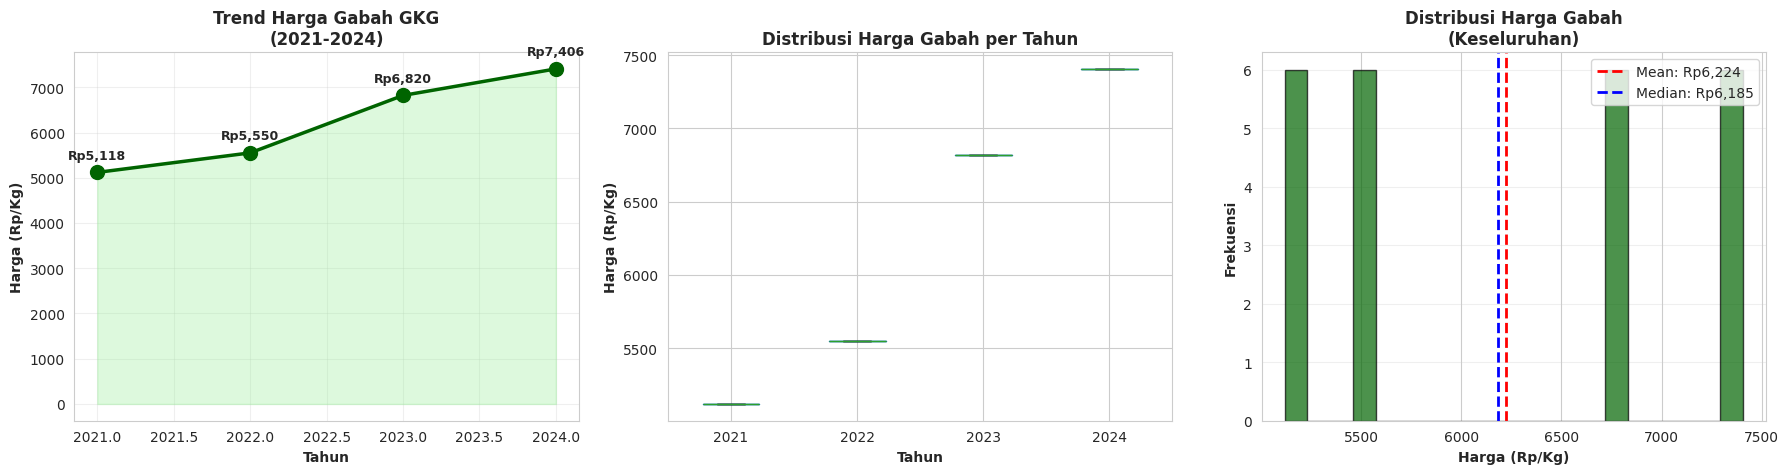


✅ Visualisasi disimpan: eda_distribusi_harga_gabah.png


In [ ]:
#Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Line plot trend
axes[0].plot(df_yearly['Tahun'], df_yearly['Harga Gabah (Rp/Kg)'],
             marker='o', linewidth=2.5, markersize=10, color='darkgreen')
axes[0].fill_between(df_yearly['Tahun'], df_yearly['Harga Gabah (Rp/Kg)'],
                      alpha=0.3, color='lightgreen')
axes[0].set_title('Trend Harga Gabah GKG\n(2021-2024)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tahun', fontweight='bold')
axes[0].set_ylabel('Harga (Rp/Kg)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

for idx, row in df_yearly.iterrows():
    axes[0].annotate(f"Rp{row['Harga Gabah (Rp/Kg)']:,.0f}",
                     xy=(row['Tahun'], row['Harga Gabah (Rp/Kg)']),
                     xytext=(0, 10), textcoords='offset points',
                     ha='center', fontsize=9, fontweight='bold')

#Box plot per tahun
df_margin_detail.boxplot(column='Harga Gabah (Rp/Kg)', by='Tahun', ax=axes[1])
axes[1].set_title('Distribusi Harga Gabah per Tahun', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tahun', fontweight='bold')
axes[1].set_ylabel('Harga (Rp/Kg)', fontweight='bold')
plt.suptitle('')

#Histogram keseluruhan
axes[2].hist(df_margin_detail['Harga Gabah (Rp/Kg)'], bins=20,
             color='darkgreen', edgecolor='black', alpha=0.7)
axes[2].axvline(df_margin_detail['Harga Gabah (Rp/Kg)'].mean(),
                color='red', linestyle='--', linewidth=2,
                label=f"Mean: Rp{df_margin_detail['Harga Gabah (Rp/Kg)'].mean():,.0f}")
axes[2].axvline(df_margin_detail['Harga Gabah (Rp/Kg)'].median(),
                color='blue', linestyle='--', linewidth=2,
                label=f"Median: Rp{df_margin_detail['Harga Gabah (Rp/Kg)'].median():,.0f}")
axes[2].set_title('Distribusi Harga Gabah\n(Keseluruhan)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Harga (Rp/Kg)', fontweight='bold')
axes[2].set_ylabel('Frekuensi', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_distribusi_harga_gabah.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi disimpan: eda_distribusi_harga_gabah.png")

###C. Distribusi Harga Beras per Kategori dan Tahun

In [ ]:
# Statistik per kategori
beras_by_category = df_margin_detail.groupby('Kategori')['Harga Beras (Rp/Kg)'].agg([
    'mean', 'median', 'std', 'min', 'max', 'count'
]).round(2)

print("\nStatistik Harga Beras per Kategori:")
print(beras_by_category)

# Statistik per tahun
beras_by_year = df_margin_detail.groupby('Tahun')['Harga Beras (Rp/Kg)'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("\nStatistik Harga Beras per Tahun:")
print(beras_by_year)


Statistik Harga Beras per Kategori:
                             mean   median     std      min      max  count
Kategori                                                                   
Beras Kualitas Bawah I   11382.29 11208.33 2348.62  8987.50 14125.00      4
Beras Kualitas Bawah Ii  10892.71 10885.42 2652.21  7933.33 13866.67      4
Beras Kualitas Medium I  12453.12 12264.58 2528.16  9879.17 15404.17      4
Beras Kualitas Medium Ii 12017.71 12004.17 2857.45  8816.67 15245.83      4
Beras Kualitas Super I   13672.92 13512.50 2640.37 10929.17 16737.50      4
Beras Kualitas Super Ii  12987.50 13035.42 2926.17  9633.33 16245.83      4

Statistik Harga Beras per Tahun:
          mean   median     std      min      max
Tahun                                            
2021  10795.83 10756.25  975.40  9562.50 12108.33
2022   9363.19  9310.42 1027.21  7933.33 10929.17
2023  13507.64 13512.50 1057.25 12208.33 14916.67
2024  15270.83 15325.00 1131.79 13866.67 16737.50


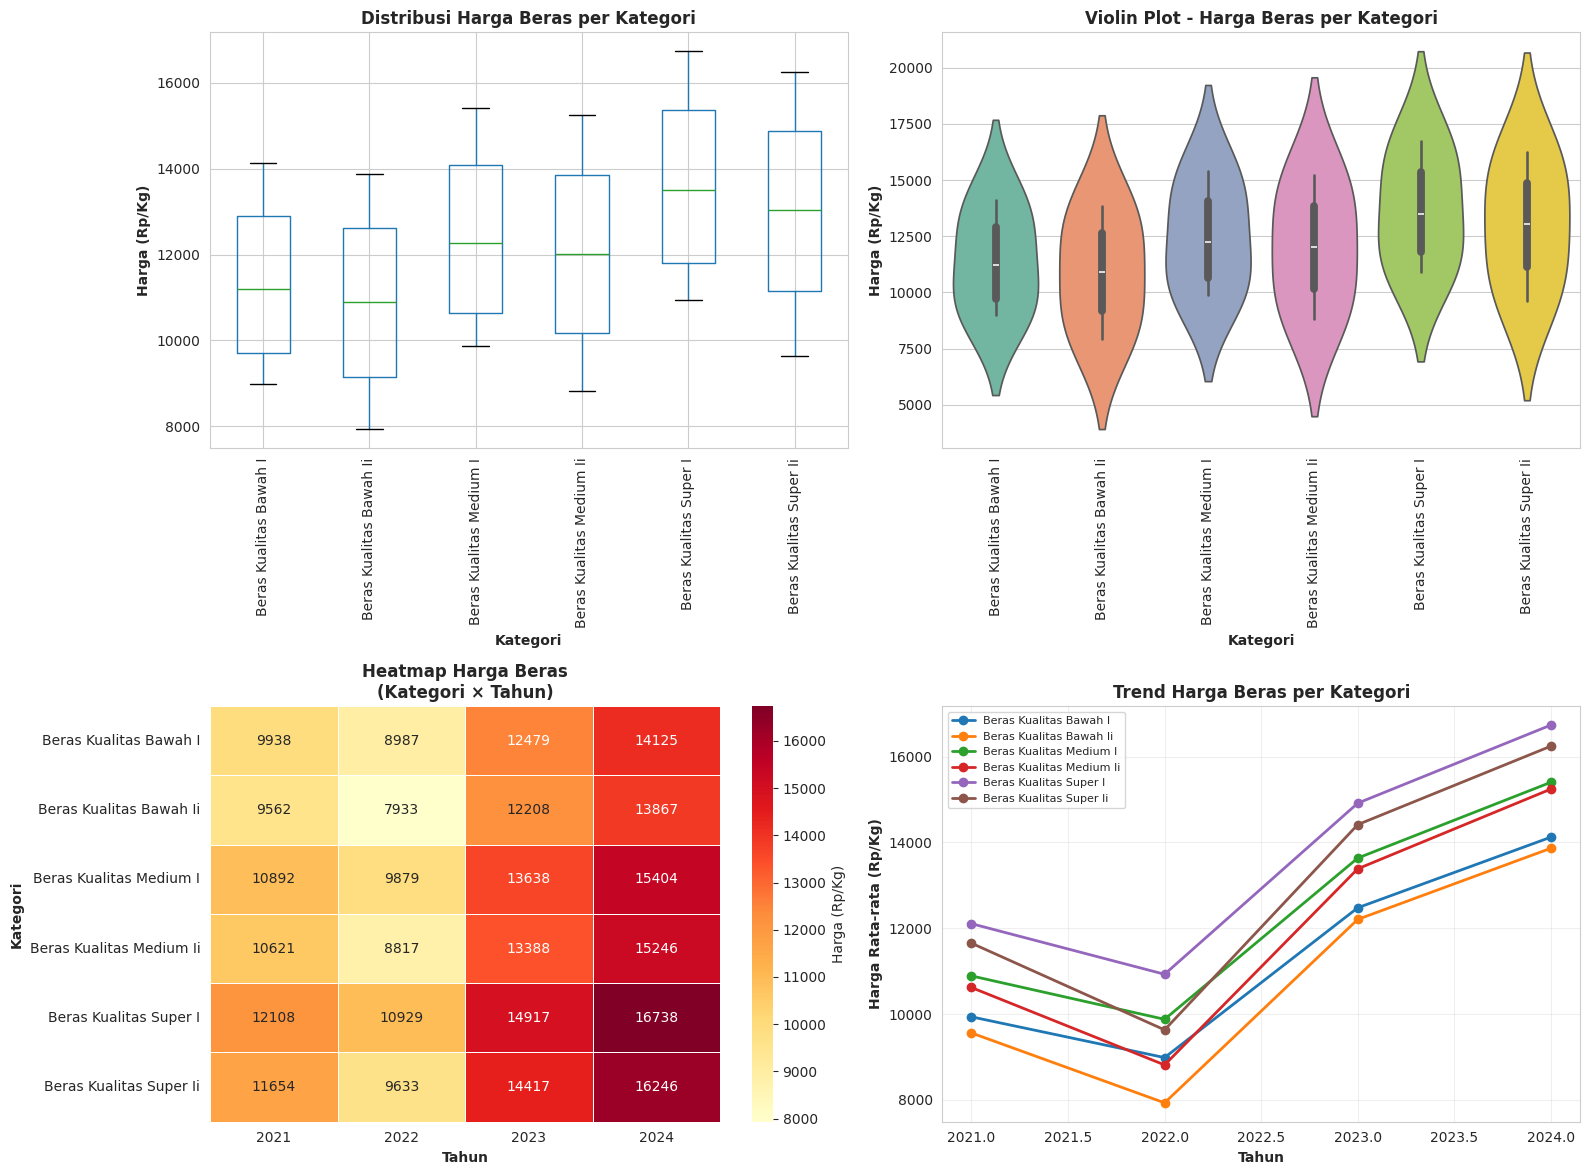


✅ Visualisasi disimpan: eda_distribusi_harga_beras.png


In [ ]:
#Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Box plot per kategori
df_margin_detail.boxplot(column='Harga Beras (Rp/Kg)', by='Kategori', ax=axes[0, 0], rot=90)
axes[0, 0].set_title('Distribusi Harga Beras per Kategori', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Kategori', fontweight='bold')
axes[0, 0].set_ylabel('Harga (Rp/Kg)', fontweight='bold')
plt.suptitle('')

#Violin plot per kategori
sns.violinplot(data=df_margin_detail, x='Kategori', y='Harga Beras (Rp/Kg)',
               ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Violin Plot - Harga Beras per Kategori', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Kategori', fontweight='bold')
axes[0, 1].set_ylabel('Harga (Rp/Kg)', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=90)

#Heatmap: Kategori x Tahun
pivot_beras = df_margin_detail.pivot_table(
    values='Harga Beras (Rp/Kg)',
    index='Kategori',
    columns='Tahun',
    aggfunc='mean'
)
sns.heatmap(pivot_beras, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Harga (Rp/Kg)'}, ax=axes[1, 0], linewidths=0.5)
axes[1, 0].set_title('Heatmap Harga Beras\n(Kategori × Tahun)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tahun', fontweight='bold')
axes[1, 0].set_ylabel('Kategori', fontweight='bold')

#Line plot per kategori
for kategori in df_margin_detail['Kategori'].unique():
    data = df_margin_detail[df_margin_detail['Kategori'] == kategori]
    avg_by_year = data.groupby('Tahun')['Harga Beras (Rp/Kg)'].mean()
    axes[1, 1].plot(avg_by_year.index, avg_by_year.values,
                    marker='o', linewidth=2, markersize=6, label=kategori)

axes[1, 1].set_title('Trend Harga Beras per Kategori', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tahun', fontweight='bold')
axes[1, 1].set_ylabel('Harga Rata-rata (Rp/Kg)', fontweight='bold')
axes[1, 1].legend(loc='best', fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_distribusi_harga_beras.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi disimpan: eda_distribusi_harga_beras.png")

###D. Distribusi Produksi Padi per Tahun

In [ ]:
# Statistik produksi
produksi_stats = df_yearly[['Tahun', 'Produksi (ton)']].copy()
produksi_stats['Δ Produksi (ton)'] = produksi_stats['Produksi (ton)'].diff()
produksi_stats['Δ Produksi (%)'] = produksi_stats['Produksi (ton)'].pct_change() * 100

print("\nStatistik Produksi Padi per Tahun:")
print(produksi_stats)


Statistik Produksi Padi per Tahun:
   Tahun  Produksi (ton)  Δ Produksi (ton)  Δ Produksi (%)
0   2021      1600449.83               NaN             NaN
1   2022      1564314.22         -36135.61           -2.26
2   2023      1384179.90        -180134.32          -11.52
3   2024      1362685.91         -21493.99           -1.55


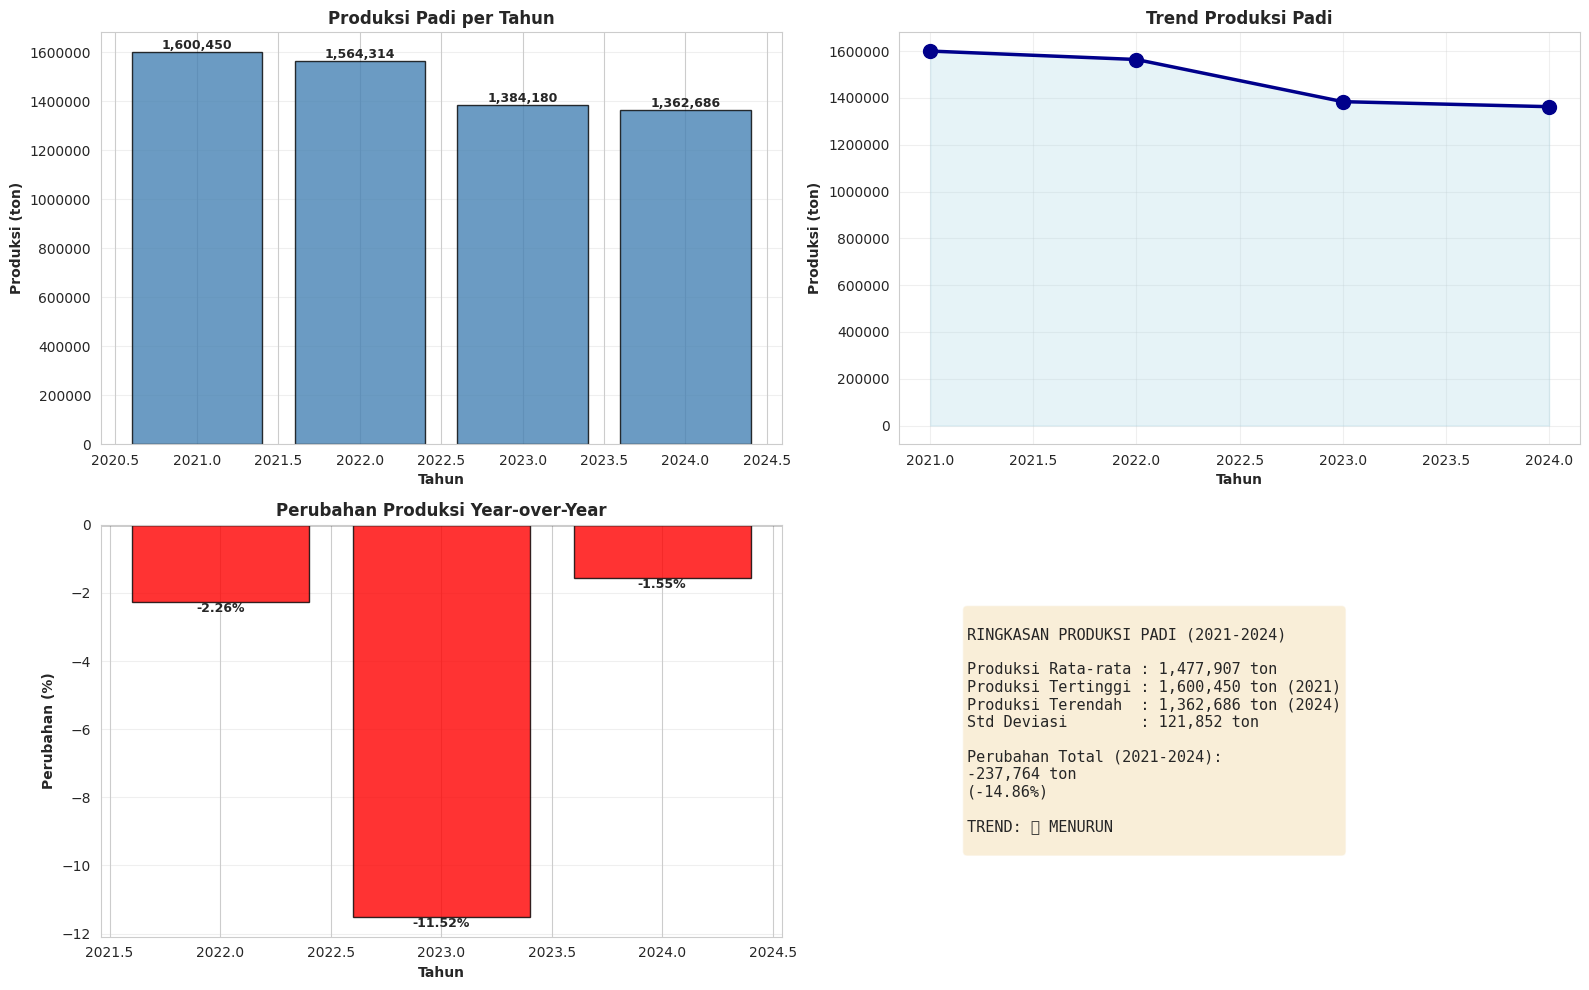


✅ Visualisasi disimpan: eda_distribusi_produksi.png


In [ ]:
# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

#Bar chart produksi per tahun
colors = ['green' if x >= 0 else 'red' for x in produksi_stats['Δ Produksi (%)'].fillna(0)]
axes[0, 0].bar(produksi_stats['Tahun'], produksi_stats['Produksi (ton)'],
               color='steelblue', edgecolor='black', alpha=0.8)
axes[0, 0].set_title('Produksi Padi per Tahun', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Tahun', fontweight='bold')
axes[0, 0].set_ylabel('Produksi (ton)', fontweight='bold')
axes[0, 0].ticklabel_format(style='plain', axis='y')
axes[0, 0].grid(True, alpha=0.3, axis='y')

for idx, row in produksi_stats.iterrows():
    axes[0, 0].text(row['Tahun'], row['Produksi (ton)'],
                    f"{row['Produksi (ton)']:,.0f}",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

#Line plot dengan area fill
axes[0, 1].plot(produksi_stats['Tahun'], produksi_stats['Produksi (ton)'],
                marker='o', linewidth=2.5, markersize=10, color='darkblue')
axes[0, 1].fill_between(produksi_stats['Tahun'], produksi_stats['Produksi (ton)'],
                         alpha=0.3, color='lightblue')
axes[0, 1].set_title('Trend Produksi Padi', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tahun', fontweight='bold')
axes[0, 1].set_ylabel('Produksi (ton)', fontweight='bold')
axes[0, 1].ticklabel_format(style='plain', axis='y')
axes[0, 1].grid(True, alpha=0.3)

#Perubahan YoY (%)
axes[1, 0].bar(produksi_stats['Tahun'][1:], produksi_stats['Δ Produksi (%)'][1:],
               color=colors[1:], edgecolor='black', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_title('Perubahan Produksi Year-over-Year', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tahun', fontweight='bold')
axes[1, 0].set_ylabel('Perubahan (%)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

for idx, row in produksi_stats.iterrows():
    if pd.notna(row['Δ Produksi (%)']):
        axes[1, 0].text(row['Tahun'], row['Δ Produksi (%)'],
                        f"{row['Δ Produksi (%)']:+.2f}%",
                        ha='center', va='bottom' if row['Δ Produksi (%)'] > 0 else 'top',
                        fontsize=9, fontweight='bold')

#Summary statistics box
axes[1, 1].axis('off')
summary_text = f"""
RINGKASAN PRODUKSI PADI (2021-2024)

Produksi Rata-rata : {produksi_stats['Produksi (ton)'].mean():,.0f} ton
Produksi Tertinggi : {produksi_stats['Produksi (ton)'].max():,.0f} ton ({produksi_stats.loc[produksi_stats['Produksi (ton)'].idxmax(), 'Tahun']:.0f})
Produksi Terendah  : {produksi_stats['Produksi (ton)'].min():,.0f} ton ({produksi_stats.loc[produksi_stats['Produksi (ton)'].idxmin(), 'Tahun']:.0f})
Std Deviasi        : {produksi_stats['Produksi (ton)'].std():,.0f} ton

Perubahan Total (2021-2024):
{produksi_stats['Δ Produksi (ton)'].sum():,.0f} ton
({(produksi_stats['Produksi (ton)'].iloc[-1] / produksi_stats['Produksi (ton)'].iloc[0] - 1) * 100:+.2f}%)

TREND: {'📉 MENURUN' if produksi_stats['Produksi (ton)'].iloc[-1] < produksi_stats['Produksi (ton)'].iloc[0] else '📈 MENINGKAT'}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_distribusi_produksi.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi disimpan: eda_distribusi_produksi.png")


###E. Distribusi Margin Harga

In [ ]:
margin_stats = pd.DataFrame({
    'Margin Absolut': df_margin_detail['Margin Absolut (Rp/Kg)'].describe(),
    'Margin Persentase': df_margin_detail['Margin Persentase (%)'].describe()
}).T

print("\nStatistik Deskriptif Margin:")
print(margin_stats)

# Test normalitas
_, p_abs = stats.normaltest(df_margin_detail['Margin Absolut (Rp/Kg)'])
_, p_pct = stats.normaltest(df_margin_detail['Margin Persentase (%)'])

print(f"   Margin Absolut: p-value = {p_abs:.4f} {'(Normal)' if p_abs > 0.05 else '(Tidak Normal)'}")
print(f"   Margin Persentase: p-value = {p_pct:.4f} {'(Normal)' if p_pct > 0.05 else '(Tidak Normal)'}")



Statistik Deskriptif Margin:
                   count    mean     std     min     25%     50%     75%  \
Margin Absolut     24.00 6010.80 1806.23 2383.51 4725.24 6116.80 7141.60   
Margin Persentase  24.00   95.97   23.17   42.95   81.99   96.62  111.74   

                      max  
Margin Absolut    9331.28  
Margin Persentase  136.56  
   Margin Absolut: p-value = 0.8319 (Normal)
   Margin Persentase: p-value = 0.6864 (Normal)


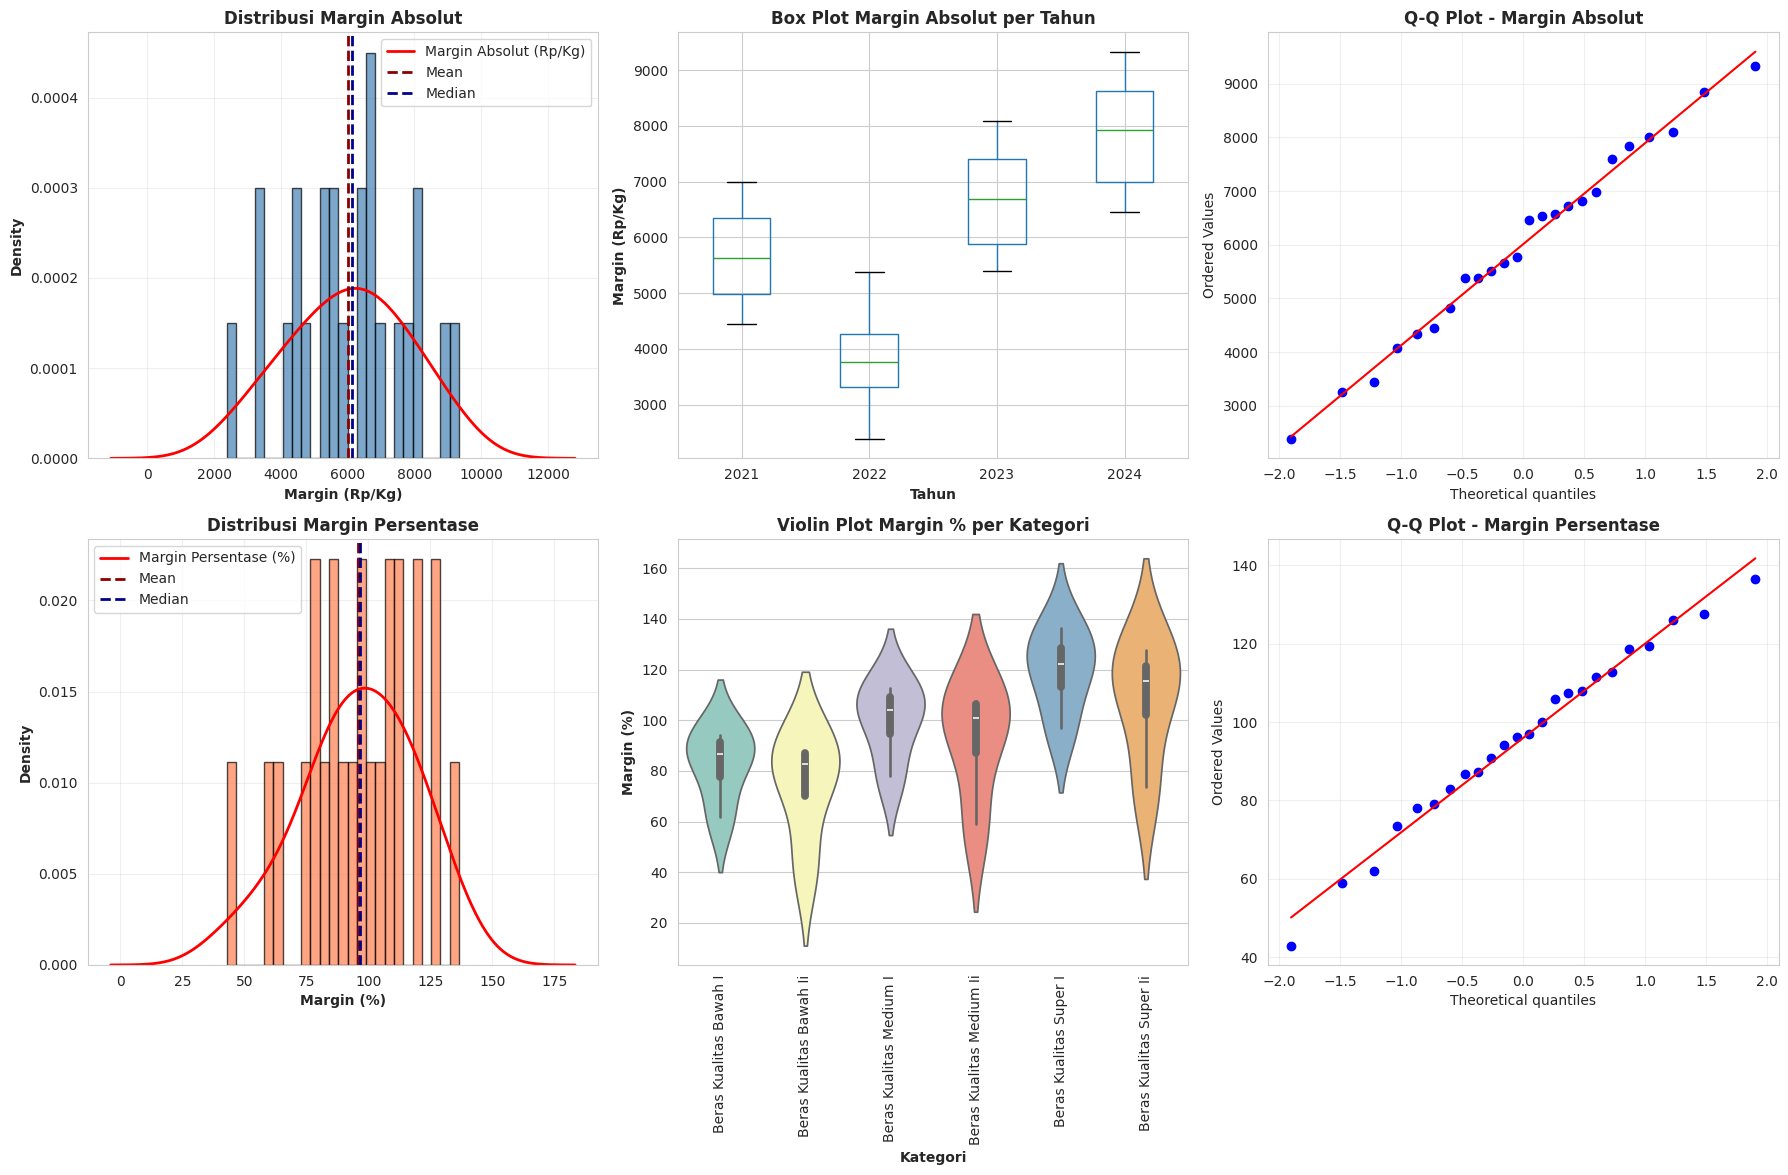


✅ Visualisasi disimpan: eda_distribusi_margin.png


In [ ]:
# Visualisasi
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Margin Absolut
# 1.1 Histogram dengan KDE
axes[0, 0].hist(df_margin_detail['Margin Absolut (Rp/Kg)'], bins=25,
                color='steelblue', edgecolor='black', alpha=0.7, density=True)
df_margin_detail['Margin Absolut (Rp/Kg)'].plot(kind='kde', ax=axes[0, 0],
                                                 color='red', linewidth=2)
axes[0, 0].axvline(df_margin_detail['Margin Absolut (Rp/Kg)'].mean(),
                   color='darkred', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(df_margin_detail['Margin Absolut (Rp/Kg)'].median(),
                   color='darkblue', linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_title('Distribusi Margin Absolut', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Margin (Rp/Kg)', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 1.2 Box plot per tahun
df_margin_detail.boxplot(column='Margin Absolut (Rp/Kg)', by='Tahun', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot Margin Absolut per Tahun', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tahun', fontweight='bold')
axes[0, 1].set_ylabel('Margin (Rp/Kg)', fontweight='bold')
plt.suptitle('')

# 1.3 Q-Q Plot
stats.probplot(df_margin_detail['Margin Absolut (Rp/Kg)'], dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot - Margin Absolut', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Margin Persentase
# 2.1 Histogram dengan KDE
axes[1, 0].hist(df_margin_detail['Margin Persentase (%)'], bins=25,
                color='coral', edgecolor='black', alpha=0.7, density=True)
df_margin_detail['Margin Persentase (%)'].plot(kind='kde', ax=axes[1, 0],
                                                color='red', linewidth=2)
axes[1, 0].axvline(df_margin_detail['Margin Persentase (%)'].mean(),
                   color='darkred', linestyle='--', linewidth=2, label='Mean')
axes[1, 0].axvline(df_margin_detail['Margin Persentase (%)'].median(),
                   color='darkblue', linestyle='--', linewidth=2, label='Median')
axes[1, 0].set_title('Distribusi Margin Persentase', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Margin (%)', fontweight='bold')
axes[1, 0].set_ylabel('Density', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 2.2 Violin plot per kategori
sns.violinplot(data=df_margin_detail, x='Kategori', y='Margin Persentase (%)',
               ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Violin Plot Margin % per Kategori', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Kategori', fontweight='bold')
axes[1, 1].set_ylabel('Margin (%)', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=90)

# 2.3 Q-Q Plot
stats.probplot(df_margin_detail['Margin Persentase (%)'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot - Margin Persentase', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_distribusi_margin.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi disimpan: eda_distribusi_margin.png")

##4.3 EDA - Bivariate

###A. Korelasi Produksi vs Margin

In [ ]:
corr_margin_abs = df_yearly['Produksi (ton)'].corr(df_yearly['Margin Absolut (Rp/Kg)'])
corr_margin_pct = df_yearly['Produksi (ton)'].corr(df_yearly['Margin Persentase (%)'])

print(f"\nKoefisien Korelasi:")
print(f"   Produksi vs Margin Absolut    : {corr_margin_abs:+.4f}")
print(f"   Produksi vs Margin Persentase : {corr_margin_pct:+.4f}")

# Interpretasi
def interpret_correlation(r):
    if abs(r) >= 0.7:
        return "SANGAT KUAT"
    elif abs(r) >= 0.5:
        return "KUAT"
    elif abs(r) >= 0.3:
        return "SEDANG"
    else:
        return "LEMAH"

print(f"\n   Interpretasi:")
print(f"   - Margin Absolut: Korelasi {'NEGATIF' if corr_margin_abs < 0 else 'POSITIF'} {interpret_correlation(corr_margin_abs)}")
print(f"   - Margin Persentase: Korelasi {'NEGATIF' if corr_margin_pct < 0 else 'POSITIF'} {interpret_correlation(corr_margin_pct)}")


Koefisien Korelasi:
   Produksi vs Margin Absolut    : -0.8095
   Produksi vs Margin Persentase : -0.2742

   Interpretasi:
   - Margin Absolut: Korelasi NEGATIF SANGAT KUAT
   - Margin Persentase: Korelasi NEGATIF LEMAH


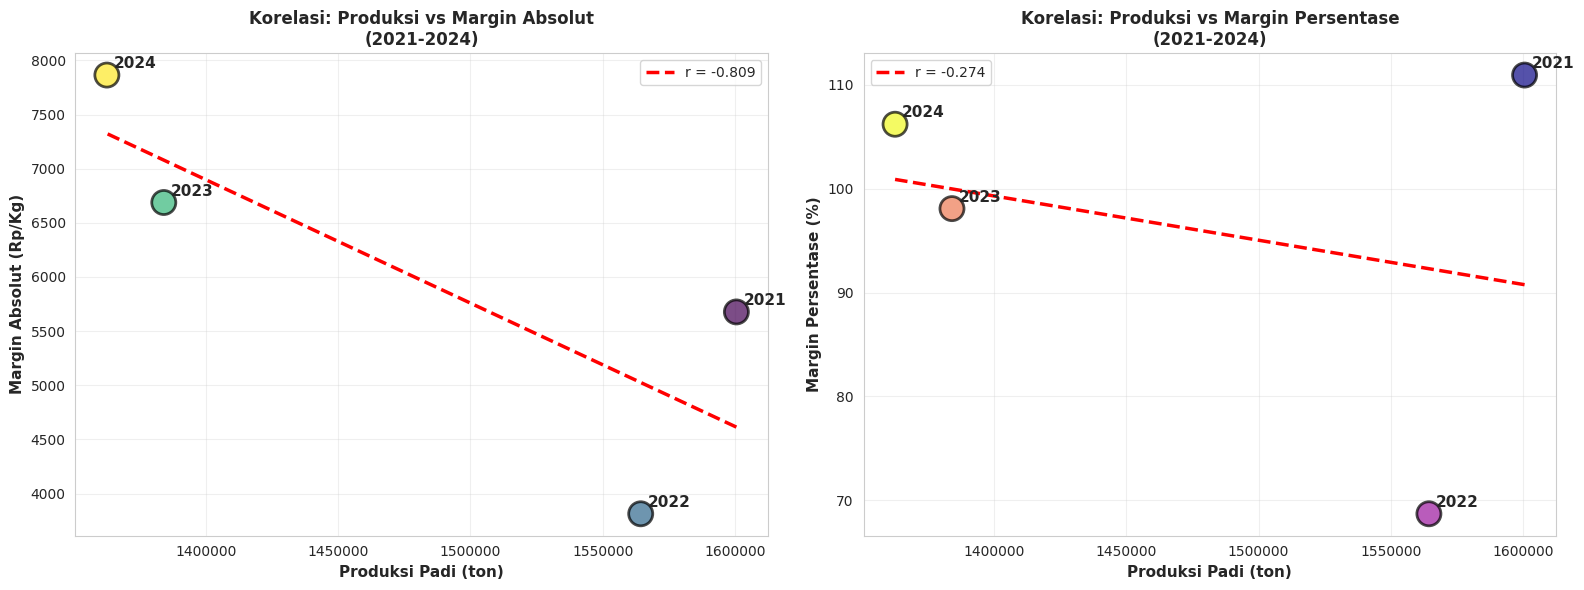


Visualisasi disimpan: eda_bivariate_produksi_margin.png


In [ ]:
# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Produksi vs Margin Absolut
axes[0].scatter(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'],
                s=300, alpha=0.7, c=df_yearly['Tahun'], cmap='viridis',
                edgecolors='black', linewidth=2)

# Add regression line
z = np.polyfit(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'], 1)
p = np.poly1d(z)
axes[0].plot(df_yearly['Produksi (ton)'], p(df_yearly['Produksi (ton)']),
             "r--", linewidth=2.5, label=f'r = {corr_margin_abs:+.3f}')

for idx, row in df_yearly.iterrows():
    axes[0].annotate(f"{int(row['Tahun'])}",
                     xy=(row['Produksi (ton)'], row['Margin Absolut (Rp/Kg)']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=11, fontweight='bold')

axes[0].set_xlabel('Produksi Padi (ton)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold')
axes[0].set_title('Korelasi: Produksi vs Margin Absolut\n(2021-2024)',
                  fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style='plain', axis='x')

#Scatter: Produksi vs Margin Persentase
axes[1].scatter(df_yearly['Produksi (ton)'], df_yearly['Margin Persentase (%)'],
                s=300, alpha=0.7, c=df_yearly['Tahun'], cmap='plasma',
                edgecolors='black', linewidth=2)

# Add regression line
z2 = np.polyfit(df_yearly['Produksi (ton)'], df_yearly['Margin Persentase (%)'], 1)
p2 = np.poly1d(z2)
axes[1].plot(df_yearly['Produksi (ton)'], p2(df_yearly['Produksi (ton)']),
             "r--", linewidth=2.5, label=f'r = {corr_margin_pct:+.3f}')

for idx, row in df_yearly.iterrows():
    axes[1].annotate(f"{int(row['Tahun'])}",
                     xy=(row['Produksi (ton)'], row['Margin Persentase (%)']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=11, fontweight='bold')

axes[1].set_xlabel('Produksi Padi (ton)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Margin Persentase (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Korelasi: Produksi vs Margin Persentase\n(2021-2024)',
                  fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_bivariate_produksi_margin.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi disimpan: eda_bivariate_produksi_margin.png")

###B. Perbandingan Margin Antar Kategori

In [ ]:
# Statistik per kategori
margin_by_cat = df_margin_detail.groupby('Kategori').agg({
    'Margin Absolut (Rp/Kg)': ['mean', 'std', 'min', 'max'],
    'Margin Persentase (%)': ['mean', 'std', 'min', 'max']
}).round(2)

print("\nStatistik Margin per Kategori:")
print(margin_by_cat)

# ANOVA test
categories = [group['Margin Absolut (Rp/Kg)'].values
              for name, group in df_margin_detail.groupby('Kategori')]
f_stat, p_value = stats.f_oneway(*categories)
print(f"   F-statistic: {f_stat:.4f}")
print(f"   P-value: {p_value:.4f}")
print(f"   Hasil: {'Ada perbedaan signifikan antar kategori' if p_value < 0.05 else 'Tidak ada perbedaan signifikan'}")


Statistik Margin per Kategori:
                         Margin Absolut (Rp/Kg)                          \
                                           mean     std     min     max   
Kategori                                                                  
Beras Kualitas Bawah I                  5158.72 1385.87 3437.67 6718.78   
Beras Kualitas Bawah Ii                 4669.14 1732.17 2383.51 6460.45   
Beras Kualitas Medium I                 6229.55 1559.09 4329.34 7997.95   
Beras Kualitas Medium Ii                5794.14 1936.91 3266.84 7839.61   
Beras Kualitas Super I                  7449.34 1679.00 5379.34 9331.28   
Beras Kualitas Super Ii                 6763.93 2019.83 4083.51 8839.61   

                         Margin Persentase (%)                     
                                          mean   std   min    max  
Kategori                                                           
Beras Kualitas Bawah I                   82.45 14.45 61.94  94.15  
Beras Kualitas Bawah

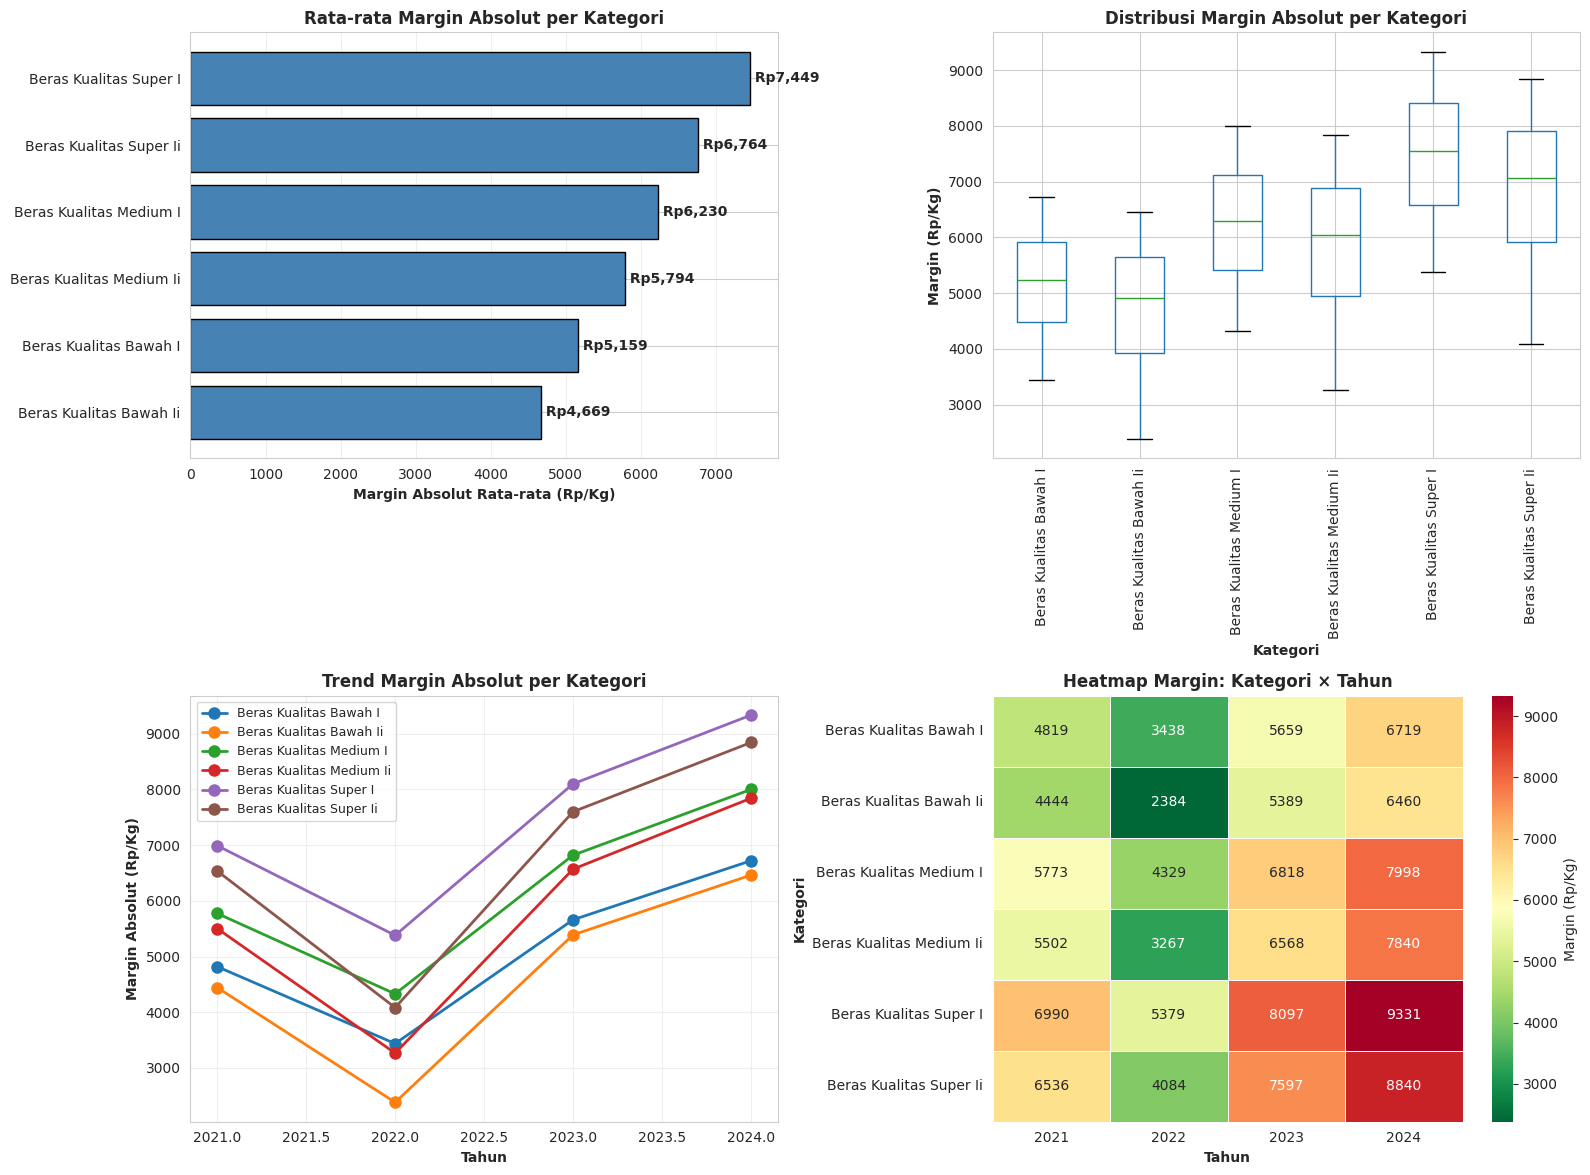


Visualisasi disimpan: eda_bivariate_margin_per_kategori.png


In [ ]:
# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Bar chart: Rata-rata margin per kategori
margin_mean = df_margin_detail.groupby('Kategori')['Margin Absolut (Rp/Kg)'].mean().sort_values()
axes[0, 0].barh(margin_mean.index, margin_mean.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Margin Absolut Rata-rata (Rp/Kg)', fontweight='bold')
axes[0, 0].set_title('Rata-rata Margin Absolut per Kategori', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Annotate values
for i, v in enumerate(margin_mean.values):
    axes[0, 0].text(v, i, f' Rp{v:,.0f}', va='center', fontweight='bold')

#Box plot comparison
df_margin_detail.boxplot(column='Margin Absolut (Rp/Kg)', by='Kategori', ax=axes[0, 1], rot=90)
axes[0, 1].set_title('Distribusi Margin Absolut per Kategori', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Kategori', fontweight='bold')
axes[0, 1].set_ylabel('Margin (Rp/Kg)', fontweight='bold')
plt.suptitle('')

#Line plot: Trend per kategori
for kategori in sorted(df_margin_detail['Kategori'].unique()):
    data = df_margin_detail[df_margin_detail['Kategori'] == kategori]
    avg_by_year = data.groupby('Tahun')['Margin Absolut (Rp/Kg)'].mean()
    axes[1, 0].plot(avg_by_year.index, avg_by_year.values,
                    marker='o', linewidth=2, markersize=8, label=kategori)

axes[1, 0].set_xlabel('Tahun', fontweight='bold')
axes[1, 0].set_ylabel('Margin Absolut (Rp/Kg)', fontweight='bold')
axes[1, 0].set_title('Trend Margin Absolut per Kategori', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

#Heatmap: Margin per kategori dan tahun
pivot_margin = df_margin_detail.pivot_table(
    values='Margin Absolut (Rp/Kg)',
    index='Kategori',
    columns='Tahun',
    aggfunc='mean'
)
sns.heatmap(pivot_margin, annot=True, fmt='.0f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Margin (Rp/Kg)'}, ax=axes[1, 1], linewidths=0.5)
axes[1, 1].set_title('Heatmap Margin: Kategori × Tahun', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tahun', fontweight='bold')
axes[1, 1].set_ylabel('Kategori', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_bivariate_margin_per_kategori.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi disimpan: eda_bivariate_margin_per_kategori.png")

###C. Trend Temporal untuk Setiap Variabel

In [ ]:
#rate of change untuk semua variabel
temporal_analysis = df_yearly.copy()
for col in ['Produksi (ton)', 'Margin Absolut (Rp/Kg)', 'Margin Persentase (%)',
            'Harga Beras (Rp/Kg)', 'Harga Gabah (Rp/Kg)']:
    if col in temporal_analysis.columns:
        temporal_analysis[f'{col}_Change%'] = temporal_analysis[col].pct_change() * 100

print("\nAnalisis Perubahan Temporal (Year-over-Year):")
print(temporal_analysis[['Tahun', 'Produksi (ton)_Change%', 'Margin Absolut (Rp/Kg)_Change%',
                         'Harga Beras (Rp/Kg)_Change%', 'Harga Gabah (Rp/Kg)_Change%']])


Analisis Perubahan Temporal (Year-over-Year):
   Tahun  Produksi (ton)_Change%  Margin Absolut (Rp/Kg)_Change%  \
0   2021                     NaN                             NaN   
1   2022                   -2.26                          -32.83   
2   2023                  -11.52                           75.38   
3   2024                   -1.55                           17.59   

   Harga Beras (Rp/Kg)_Change%  Harga Gabah (Rp/Kg)_Change%  
0                          NaN                          NaN  
1                       -13.27                         8.43  
2                        44.26                        22.88  
3                        13.05                         8.60  


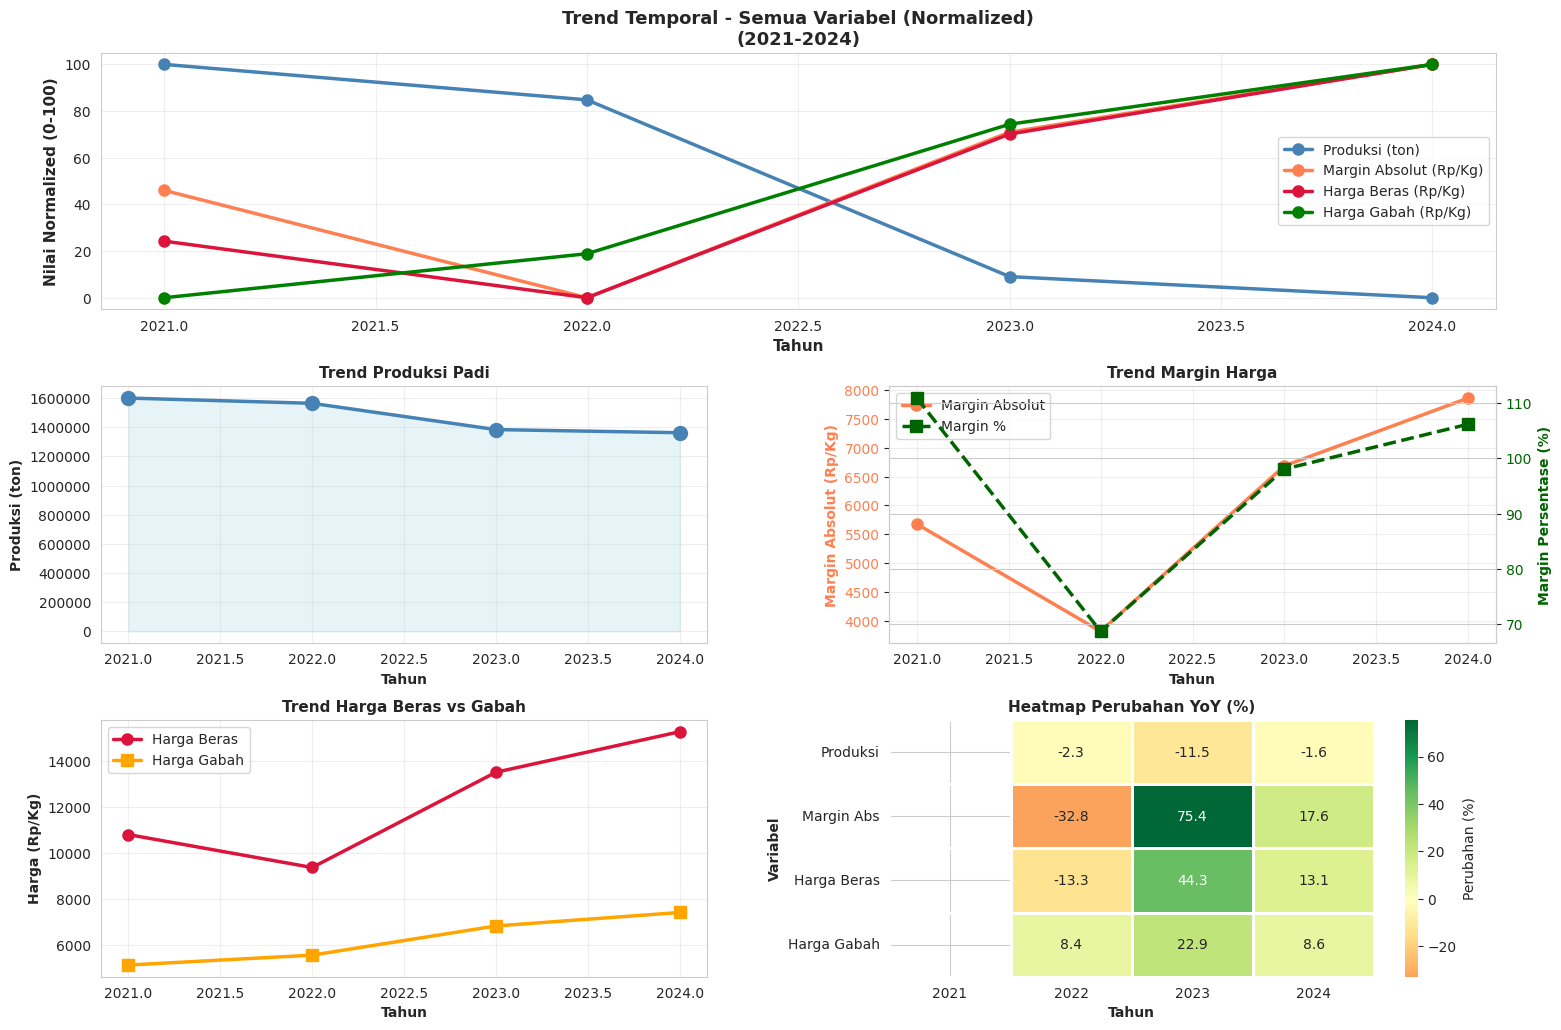


Visualisasi disimpan: eda_bivariate_trend_temporal.png


In [ ]:
#Visualisasi comprehensive
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

#Multi-line plot: Semua variabel (normalized)
ax1 = fig.add_subplot(gs[0, :])
normalize = lambda x: (x - x.min()) / (x.max() - x.min()) * 100

for col, color in zip(['Produksi (ton)', 'Margin Absolut (Rp/Kg)',
                        'Harga Beras (Rp/Kg)', 'Harga Gabah (Rp/Kg)'],
                       ['steelblue', 'coral', 'crimson', 'green']):
    normalized_values = normalize(df_yearly[col])
    ax1.plot(df_yearly['Tahun'], normalized_values,
             marker='o', linewidth=2.5, markersize=8, label=col, color=color)

ax1.set_xlabel('Tahun', fontsize=11, fontweight='bold')
ax1.set_ylabel('Nilai Normalized (0-100)', fontsize=11, fontweight='bold')
ax1.set_title('Trend Temporal - Semua Variabel (Normalized)\n(2021-2024)',
              fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

#Produksi trend
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
         marker='o', linewidth=2.5, markersize=10, color='steelblue')
ax2.fill_between(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
                  alpha=0.3, color='lightblue')
ax2.set_xlabel('Tahun', fontweight='bold')
ax2.set_ylabel('Produksi (ton)', fontweight='bold')
ax2.set_title('Trend Produksi Padi', fontsize=11, fontweight='bold')
ax2.ticklabel_format(style='plain', axis='y')
ax2.grid(True, alpha=0.3)

#Margin trend (dual axis)
ax3 = fig.add_subplot(gs[1, 1])
ax3_twin = ax3.twinx()

line1 = ax3.plot(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
                 marker='o', linewidth=2.5, markersize=8, color='coral',
                 label='Margin Absolut')
line2 = ax3_twin.plot(df_yearly['Tahun'], df_yearly['Margin Persentase (%)'],
                      marker='s', linewidth=2.5, markersize=8, color='darkgreen',
                      label='Margin %', linestyle='--')

ax3.set_xlabel('Tahun', fontweight='bold')
ax3.set_ylabel('Margin Absolut (Rp/Kg)', fontweight='bold', color='coral')
ax3_twin.set_ylabel('Margin Persentase (%)', fontweight='bold', color='darkgreen')
ax3.set_title('Trend Margin Harga', fontsize=11, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='coral')
ax3_twin.tick_params(axis='y', labelcolor='darkgreen')
ax3.grid(True, alpha=0.3)

#Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left')

#Harga Beras vs Gabah
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(df_yearly['Tahun'], df_yearly['Harga Beras (Rp/Kg)'],
         marker='o', linewidth=2.5, markersize=8, color='crimson',
         label='Harga Beras')
ax4.plot(df_yearly['Tahun'], df_yearly['Harga Gabah (Rp/Kg)'],
         marker='s', linewidth=2.5, markersize=8, color='orange',
         label='Harga Gabah')
ax4.set_xlabel('Tahun', fontweight='bold')
ax4.set_ylabel('Harga (Rp/Kg)', fontweight='bold')
ax4.set_title('Trend Harga Beras vs Gabah', fontsize=11, fontweight='bold')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

#Perubahan YoY - Heatmap
ax5 = fig.add_subplot(gs[2, 1])
yoy_data = temporal_analysis[['Produksi (ton)_Change%', 'Margin Absolut (Rp/Kg)_Change%',
                               'Harga Beras (Rp/Kg)_Change%', 'Harga Gabah (Rp/Kg)_Change%']].T
yoy_data.columns = temporal_analysis['Tahun'].astype(int)
yoy_data.index = ['Produksi', 'Margin Abs', 'Harga Beras', 'Harga Gabah']

sns.heatmap(yoy_data, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Perubahan (%)'}, ax=ax5, linewidths=1)
ax5.set_title('Heatmap Perubahan YoY (%)', fontsize=11, fontweight='bold')
ax5.set_xlabel('Tahun', fontweight='bold')
ax5.set_ylabel('Variabel', fontweight='bold')

plt.savefig(f'{visualisasi_path}eda_bivariate_trend_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi disimpan: eda_bivariate_trend_temporal.png")

##4.4 EDA - Multivariate

###A. Analisis Hubungan Simultan (Multivariate)

In [ ]:
# Correlation matrix lengkap
correlation_vars = df_yearly[['Produksi (ton)', 'Margin Absolut (Rp/Kg)',
                               'Margin Persentase (%)', 'Harga Beras (Rp/Kg)',
                               'Harga Gabah (Rp/Kg)']].corr()

print("\nCorrelation Matrix:")
print(correlation_vars.round(3))


Correlation Matrix:
                        Produksi (ton)  Margin Absolut (Rp/Kg)  \
Produksi (ton)                    1.00                   -0.81   
Margin Absolut (Rp/Kg)           -0.81                    1.00   
Margin Persentase (%)            -0.27                    0.77   
Harga Beras (Rp/Kg)              -0.92                    0.97   
Harga Gabah (Rp/Kg)              -0.99                    0.81   

                        Margin Persentase (%)  Harga Beras (Rp/Kg)  \
Produksi (ton)                          -0.27                -0.92   
Margin Absolut (Rp/Kg)                   0.77                 0.97   
Margin Persentase (%)                    1.00                 0.60   
Harga Beras (Rp/Kg)                      0.60                 1.00   
Harga Gabah (Rp/Kg)                      0.25                 0.93   

                        Harga Gabah (Rp/Kg)  
Produksi (ton)                        -0.99  
Margin Absolut (Rp/Kg)                 0.81  
Margin Persentase (%)  

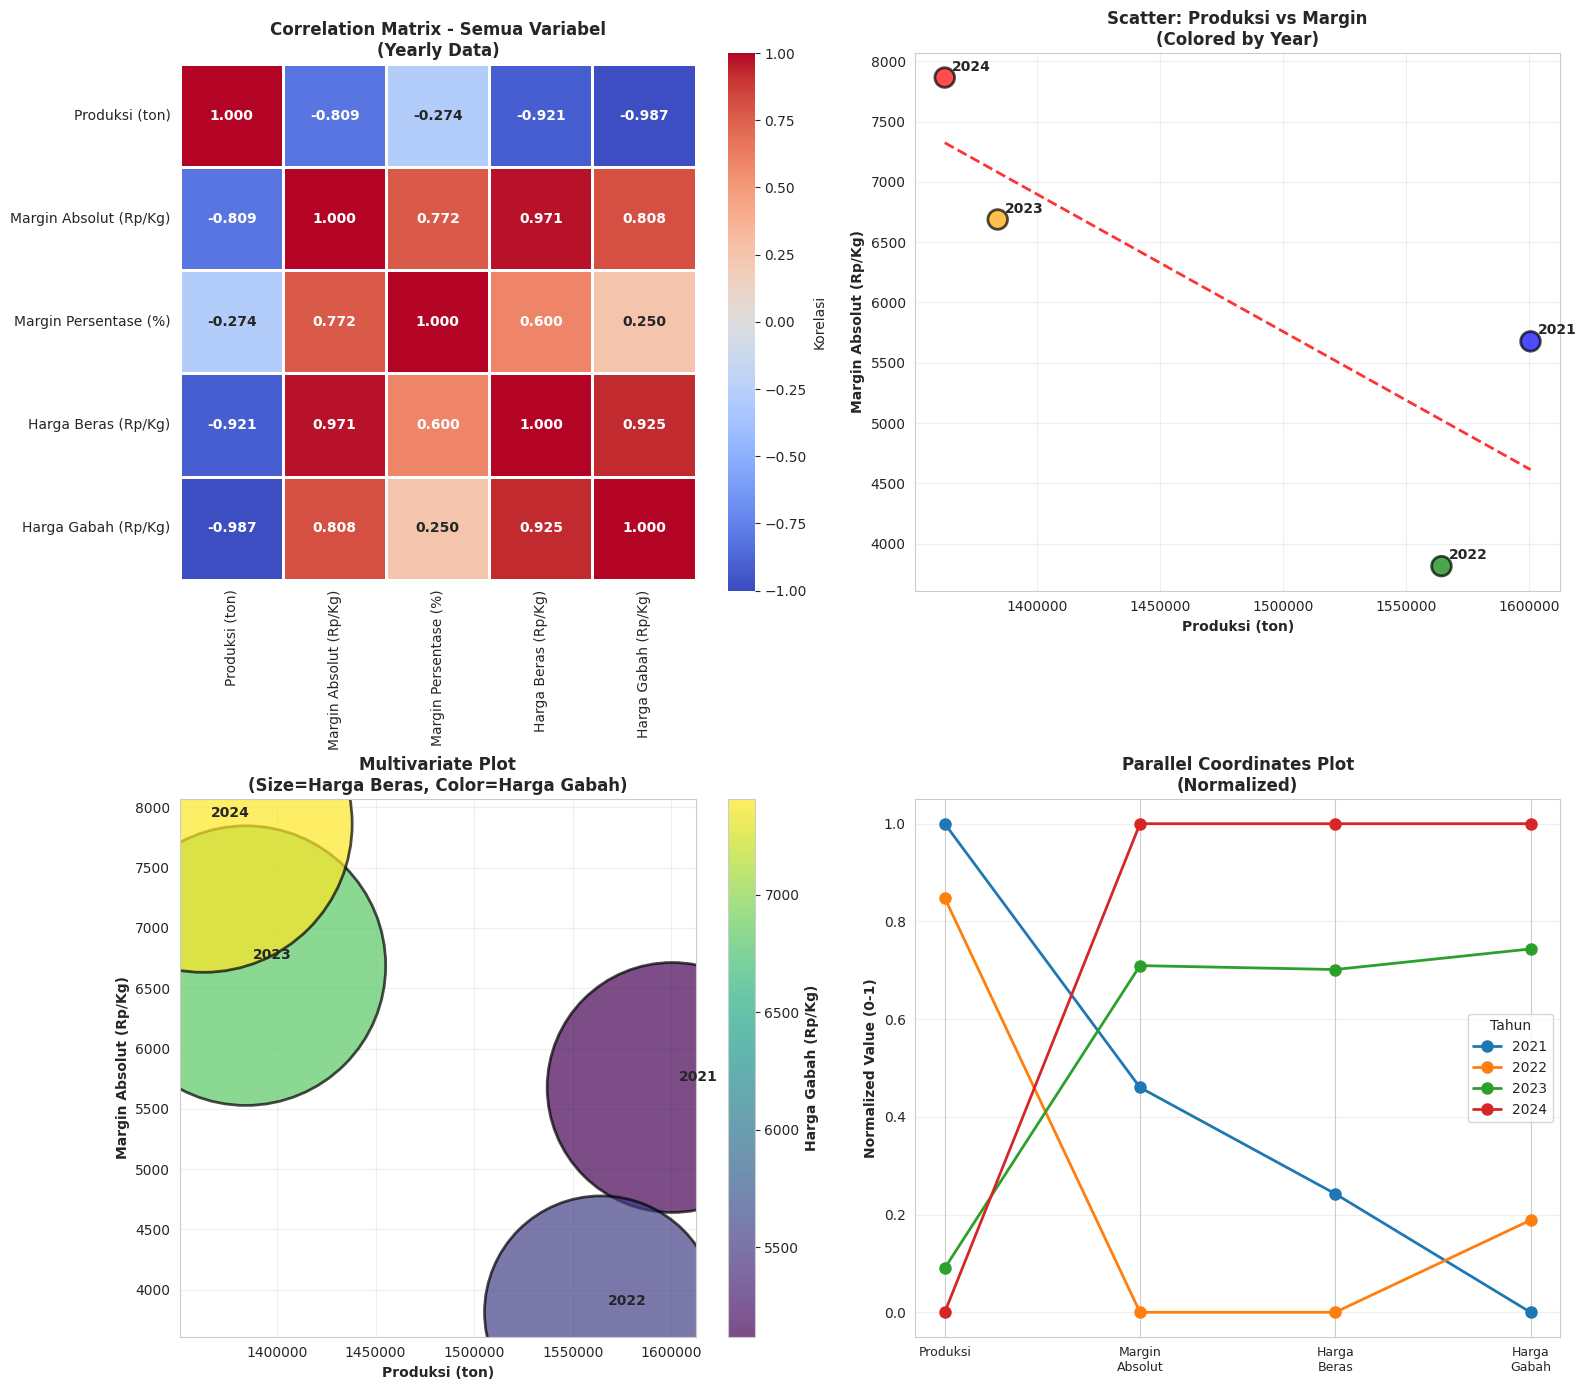


Visualisasi disimpan: eda_multivariate_analysis.png


In [ ]:
#Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

#Correlation heatmap
sns.heatmap(correlation_vars, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, linewidths=2,
            cbar_kws={'label': 'Korelasi'}, ax=axes[0, 0],
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
axes[0, 0].set_title('Correlation Matrix - Semua Variabel\n(Yearly Data)',
                     fontsize=12, fontweight='bold')

# Pairplot style - Key relationships
ax2 = axes[0, 1]
# Scatter matrix simplified
scatter_vars = ['Produksi (ton)', 'Margin Absolut (Rp/Kg)', 'Harga Beras (Rp/Kg)']
colors_year = df_yearly['Tahun'].map({2021: 'blue', 2022: 'green', 2023: 'orange', 2024: 'red'})

for i, (x_var, y_var) in enumerate([('Produksi (ton)', 'Margin Absolut (Rp/Kg)'),
                                      ('Margin Absolut (Rp/Kg)', 'Harga Beras (Rp/Kg)')]):
    if i == 0:
        sc = ax2.scatter(df_yearly[x_var], df_yearly[y_var],
                        s=200, c=colors_year, alpha=0.7, edgecolors='black', linewidth=2)
        ax2.set_xlabel(x_var, fontweight='bold')
        ax2.set_ylabel(y_var, fontweight='bold')

        # Add regression line
        z = np.polyfit(df_yearly[x_var], df_yearly[y_var], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_yearly[x_var].min(), df_yearly[x_var].max(), 100)
        ax2.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8)

        # Annotate years
        for idx, row in df_yearly.iterrows():
            ax2.annotate(f"{int(row['Tahun'])}",
                        xy=(row[x_var], row[y_var]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=10, fontweight='bold')

ax2.set_title('Scatter: Produksi vs Margin\n(Colored by Year)',
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='plain', axis='x')

# 3. 3D-style plot (using color and size)
ax3 = axes[1, 0]
scatter = ax3.scatter(df_yearly['Produksi (ton)'],
                     df_yearly['Margin Absolut (Rp/Kg)'],
                     s=df_yearly['Harga Beras (Rp/Kg)'] * 3,  # size by price
                     c=df_yearly['Harga Gabah (Rp/Kg)'],  # color by gabah price
                     cmap='viridis', alpha=0.7, edgecolors='black', linewidth=2)

# Annotate
for idx, row in df_yearly.iterrows():
    ax3.annotate(f"{int(row['Tahun'])}",
                xy=(row['Produksi (ton)'], row['Margin Absolut (Rp/Kg)']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax3.set_xlabel('Produksi (ton)', fontweight='bold')
ax3.set_ylabel('Margin Absolut (Rp/Kg)', fontweight='bold')
ax3.set_title('Multivariate Plot\n(Size=Harga Beras, Color=Harga Gabah)',
              fontsize=12, fontweight='bold')
ax3.ticklabel_format(style='plain', axis='x')
ax3.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Harga Gabah (Rp/Kg)', fontweight='bold')

# 4. Parallel coordinates plot (simplified)
ax4 = axes[1, 1]
# Normalize data for parallel plot
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

plot_vars = ['Produksi (ton)', 'Margin Absolut (Rp/Kg)',
             'Harga Beras (Rp/Kg)', 'Harga Gabah (Rp/Kg)']
normalized_data = pd.DataFrame(
    scaler.fit_transform(df_yearly[plot_vars]),
    columns=plot_vars,
    index=df_yearly['Tahun']
)

for idx, row in normalized_data.iterrows():
    ax4.plot(range(len(plot_vars)), row.values,
            marker='o', linewidth=2, markersize=8, label=f'{int(idx)}')

ax4.set_xticks(range(len(plot_vars)))
ax4.set_xticklabels(['Produksi', 'Margin\nAbsolut', 'Harga\nBeras', 'Harga\nGabah'],
                    fontsize=9)
ax4.set_ylabel('Normalized Value (0-1)', fontweight='bold')
ax4.set_title('Parallel Coordinates Plot\n(Normalized)', fontsize=12, fontweight='bold')
ax4.legend(title='Tahun', loc='best')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_multivariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi disimpan: eda_multivariate_analysis.png")

###B. Analisis Sensitivitas Kategori terhadap Perubahan Produksi

In [ ]:
# Hitung elastisitas margin terhadap produksi untuk setiap kategori
sensitivity_analysis = []

for kategori in df_margin_detail['Kategori'].unique():
    cat_data = df_margin_detail[df_margin_detail['Kategori'] == kategori].copy()
    cat_yearly = cat_data.groupby('Tahun').agg({
        'Margin Absolut (Rp/Kg)': 'mean',
        'Margin Persentase (%)': 'mean',
        'Produksi (ton)': 'mean'
    })

    # Hitung perubahan
    cat_yearly['Δ Margin Abs'] = cat_yearly['Margin Absolut (Rp/Kg)'].diff()
    cat_yearly['Δ Produksi'] = cat_yearly['Produksi (ton)'].diff()

    # Elastisitas (% change in margin / % change in production)
    cat_yearly['Elastisitas'] = (
        (cat_yearly['Δ Margin Abs'] / cat_yearly['Margin Absolut (Rp/Kg)'].shift()) /
        (cat_yearly['Δ Produksi'] / cat_yearly['Produksi (ton)'].shift())
    )

    # Korelasi
    if len(cat_yearly) >= 4:
        corr = cat_yearly['Produksi (ton)'].corr(cat_yearly['Margin Absolut (Rp/Kg)'])
        elasticity_mean = cat_yearly['Elastisitas'].mean()

        sensitivity_analysis.append({
            'Kategori': kategori,
            'Korelasi': corr,
            'Elastisitas Rata-rata': elasticity_mean,
            'Volatilitas Margin': cat_yearly['Margin Absolut (Rp/Kg)'].std(),
            'Range Margin': cat_yearly['Margin Absolut (Rp/Kg)'].max() - cat_yearly['Margin Absolut (Rp/Kg)'].min()
        })

sensitivity_df = pd.DataFrame(sensitivity_analysis).sort_values('Korelasi')

print("\nAnalisis Sensitivitas per Kategori:")
print(sensitivity_df.round(3))


Analisis Sensitivitas per Kategori:
                   Kategori  Korelasi  Elastisitas Rata-rata  \
2   Beras Kualitas Medium I     -0.84                  -1.69   
4    Beras Kualitas Super I     -0.83                  -1.33   
0    Beras Kualitas Bawah I     -0.82                  -1.66   
3  Beras Kualitas Medium Ii     -0.79                  -1.08   
1   Beras Kualitas Bawah Ii     -0.79                  -1.07   
5   Beras Kualitas Super Ii     -0.78                  -0.46   

   Volatilitas Margin  Range Margin  
2             1559.09       3668.61  
4             1679.00       3951.94  
0             1385.87       3281.11  
3             1936.91       4572.77  
1             1732.17       4076.94  
5             2019.83       4756.10  


In [ ]:
# Klasifikasi sensitivitas
sensitivity_df['Sensitivitas'] = sensitivity_df['Korelasi'].apply(
    lambda x: 'Sangat Sensitif' if x < -0.5 else 'Sensitif' if x < -0.3 else 'Moderat' if abs(x) < 0.3 else 'Tidak Sensitif'
)

print("\nKlasifikasi Sensitivitas:")
print(sensitivity_df[['Kategori', 'Korelasi', 'Sensitivitas']])


Klasifikasi Sensitivitas:
                   Kategori  Korelasi     Sensitivitas
2   Beras Kualitas Medium I     -0.84  Sangat Sensitif
4    Beras Kualitas Super I     -0.84  Sangat Sensitif
0    Beras Kualitas Bawah I     -0.82  Sangat Sensitif
3  Beras Kualitas Medium Ii     -0.79  Sangat Sensitif
1   Beras Kualitas Bawah Ii     -0.79  Sangat Sensitif
5   Beras Kualitas Super Ii     -0.78  Sangat Sensitif


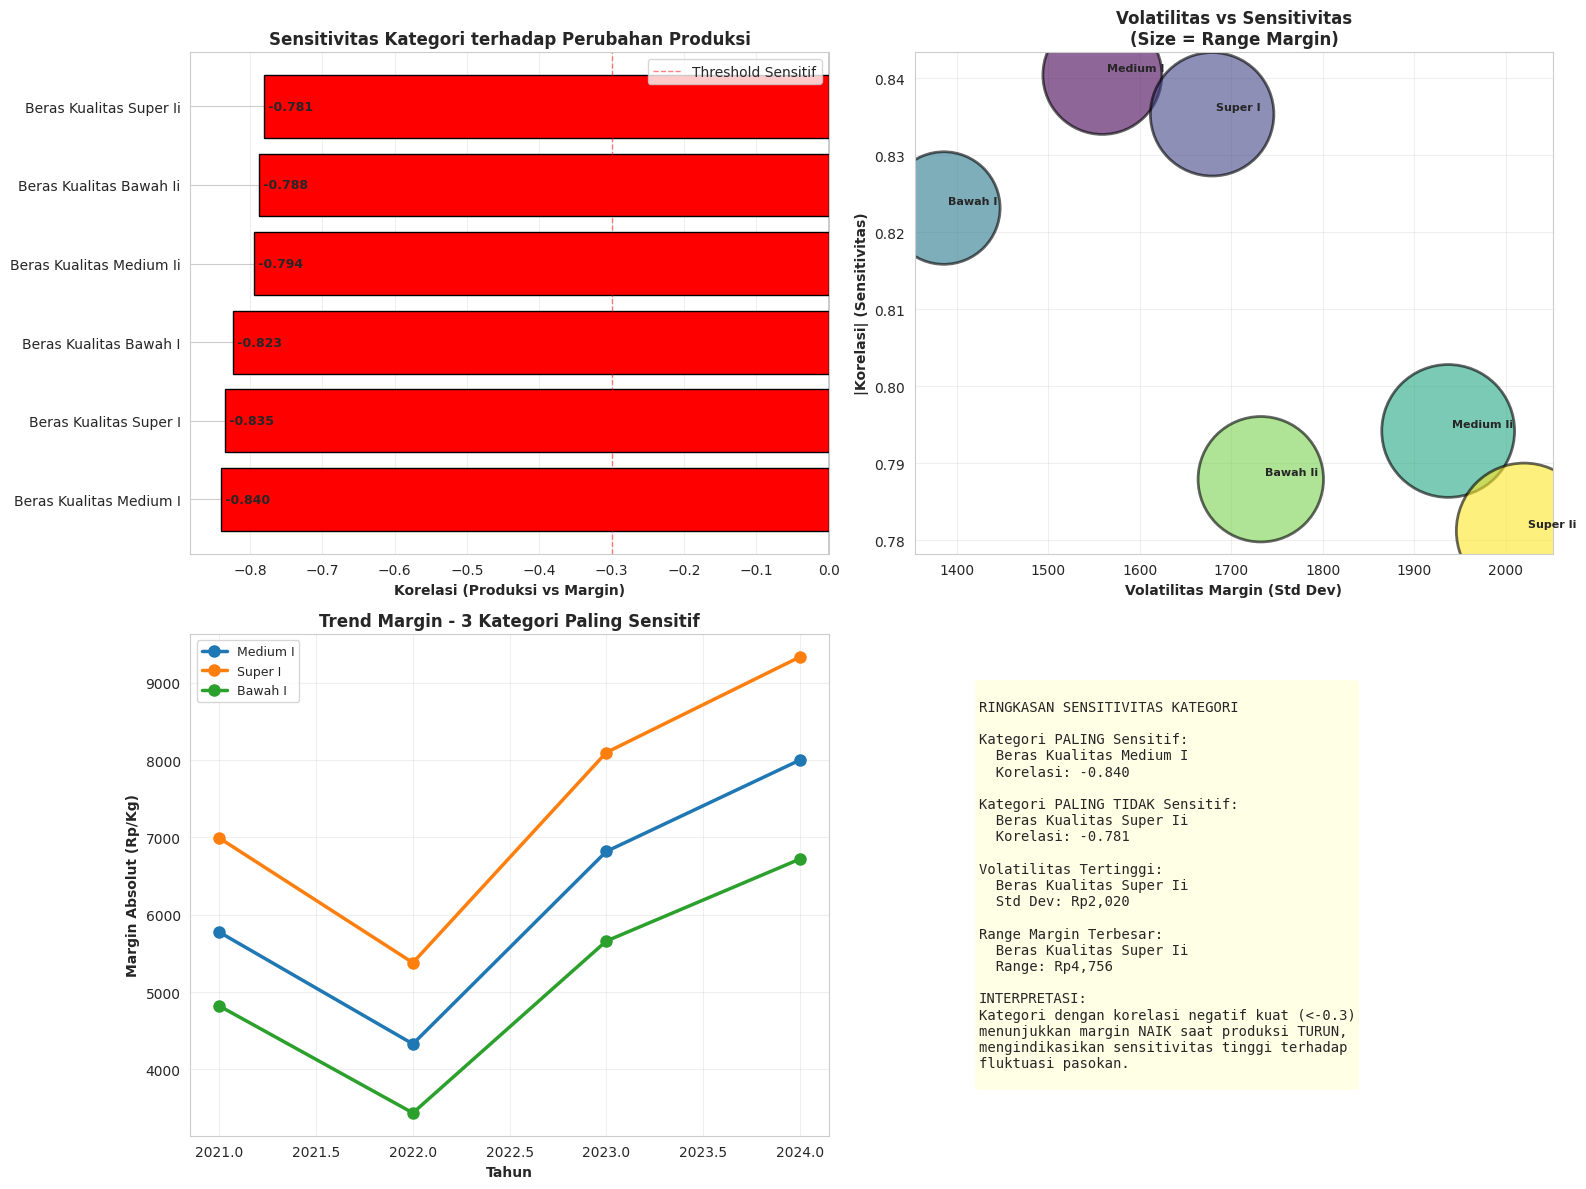


Visualisasi disimpan: eda_multivariate_sensitivitas.png


In [ ]:
#Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Bar chart: Korelasi per kategori
sensitivity_df_sorted = sensitivity_df.sort_values('Korelasi')
colors = ['red' if x < -0.3 else 'orange' if x < 0 else 'lightblue'
          for x in sensitivity_df_sorted['Korelasi']]

axes[0, 0].barh(sensitivity_df_sorted['Kategori'], sensitivity_df_sorted['Korelasi'],
                color=colors, edgecolor='black')
axes[0, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0, 0].axvline(x=-0.3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold Sensitif')
axes[0, 0].set_xlabel('Korelasi (Produksi vs Margin)', fontweight='bold')
axes[0, 0].set_title('Sensitivitas Kategori terhadap Perubahan Produksi',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Annotate values
for i, (idx, row) in enumerate(sensitivity_df_sorted.iterrows()):
    axes[0, 0].text(row['Korelasi'], i, f" {row['Korelasi']:.3f}",
                   va='center', fontweight='bold', fontsize=9)

# Scatter: Volatilitas vs Sensitivitas
axes[0, 1].scatter(sensitivity_df['Volatilitas Margin'],
                  abs(sensitivity_df['Korelasi']),
                  s=sensitivity_df['Range Margin'] * 2,
                  alpha=0.6, c=range(len(sensitivity_df)),
                  cmap='viridis', edgecolors='black', linewidth=2)

for idx, row in sensitivity_df.iterrows():
    axes[0, 1].annotate(row['Kategori'].replace('Beras Kualitas ', ''),
                       xy=(row['Volatilitas Margin'], abs(row['Korelasi'])),
                       xytext=(3, 3), textcoords='offset points',
                       fontsize=8, fontweight='bold')

axes[0, 1].set_xlabel('Volatilitas Margin (Std Dev)', fontweight='bold')
axes[0, 1].set_ylabel('|Korelasi| (Sensitivitas)', fontweight='bold')
axes[0, 1].set_title('Volatilitas vs Sensitivitas\n(Size = Range Margin)',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Line plot: Margin trends per kategori (top 3 most sensitive)
top3_sensitive = sensitivity_df.nsmallest(3, 'Korelasi')['Kategori'].tolist()

for kategori in top3_sensitive:
    cat_data = df_margin_detail[df_margin_detail['Kategori'] == kategori]
    avg_by_year = cat_data.groupby('Tahun')['Margin Absolut (Rp/Kg)'].mean()
    axes[1, 0].plot(avg_by_year.index, avg_by_year.values,
                   marker='o', linewidth=2.5, markersize=8,
                   label=kategori.replace('Beras Kualitas ', ''))

axes[1, 0].set_xlabel('Tahun', fontweight='bold')
axes[1, 0].set_ylabel('Margin Absolut (Rp/Kg)', fontweight='bold')
axes[1, 0].set_title('Trend Margin - 3 Kategori Paling Sensitif',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

#Summary table
axes[1, 1].axis('off')
summary_text = f"""
RINGKASAN SENSITIVITAS KATEGORI

Kategori PALING Sensitif:
  {sensitivity_df.iloc[0]['Kategori']}
  Korelasi: {sensitivity_df.iloc[0]['Korelasi']:.3f}

Kategori PALING TIDAK Sensitif:
  {sensitivity_df.iloc[-1]['Kategori']}
  Korelasi: {sensitivity_df.iloc[-1]['Korelasi']:.3f}

Volatilitas Tertinggi:
  {sensitivity_df.nlargest(1, 'Volatilitas Margin')['Kategori'].values[0]}
  Std Dev: Rp{sensitivity_df['Volatilitas Margin'].max():,.0f}

Range Margin Terbesar:
  {sensitivity_df.nlargest(1, 'Range Margin')['Kategori'].values[0]}
  Range: Rp{sensitivity_df['Range Margin'].max():,.0f}

INTERPRETASI:
Kategori dengan korelasi negatif kuat (<-0.3)
menunjukkan margin NAIK saat produksi TURUN,
mengindikasikan sensitivitas tinggi terhadap
fluktuasi pasokan.
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
               verticalalignment='center',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{visualisasi_path}eda_multivariate_sensitivitas.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi disimpan: eda_multivariate_sensitivitas.png")


In [ ]:
sensitivity_df.to_csv(f'{dataset_path}sensitivity_analysis.csv', index=False)


##4.4  Insight Generation

###A. Identifikasi Tahun dengan Margin Tertinggi/Terendah

In [ ]:
margin_yearly = df_yearly[['Tahun', 'Margin Absolut (Rp/Kg)', 'Margin Persentase (%)',
                           'Produksi (ton)']].copy()

# Identifikasi extremes
max_margin_year = margin_yearly.loc[margin_yearly['Margin Absolut (Rp/Kg)'].idxmax()]
min_margin_year = margin_yearly.loc[margin_yearly['Margin Absolut (Rp/Kg)'].idxmin()]

print("\n TAHUN DENGAN MARGIN TERTINGGI:")
print(f"   Tahun: {int(max_margin_year['Tahun'])}")
print(f"   Margin Absolut: Rp{max_margin_year['Margin Absolut (Rp/Kg)']:,.2f}/Kg")
print(f"   Margin Persentase: {max_margin_year['Margin Persentase (%)']:.2f}%")
print(f"   Produksi: {max_margin_year['Produksi (ton)']:,.0f} ton")

print("\n TAHUN DENGAN MARGIN TERENDAH:")
print(f"   Tahun: {int(min_margin_year['Tahun'])}")
print(f"   Margin Absolut: Rp{min_margin_year['Margin Absolut (Rp/Kg)']:,.2f}/Kg")
print(f"   Margin Persentase: {min_margin_year['Margin Persentase (%)']:.2f}%")
print(f"   Produksi: {min_margin_year['Produksi (ton)']:,.0f} ton")


 TAHUN DENGAN MARGIN TERTINGGI:
   Tahun: 2024
   Margin Absolut: Rp7,864.61/Kg
   Margin Persentase: 106.19%
   Produksi: 1,362,686 ton

 TAHUN DENGAN MARGIN TERENDAH:
   Tahun: 2022
   Margin Absolut: Rp3,813.37/Kg
   Margin Persentase: 68.71%
   Produksi: 1,564,314 ton


In [ ]:
# Analisis per kategori

for year_type, year_data in [('TERTINGGI', max_margin_year), ('TERENDAH', min_margin_year)]:
    print(f"\n{year_type} ({int(year_data['Tahun'])}):")
    year_detail = df_margin_detail[df_margin_detail['Tahun'] == year_data['Tahun']]
    margin_by_cat = year_detail.groupby('Kategori')['Margin Absolut (Rp/Kg)'].mean().sort_values(ascending=False)

    for i, (kat, val) in enumerate(margin_by_cat.items(), 1):
        print(f"   {i}. {kat}: Rp{val:,.2f}/Kg")


TERTINGGI (2024):
   1. Beras Kualitas Super I: Rp9,331.28/Kg
   2. Beras Kualitas Super Ii: Rp8,839.61/Kg
   3. Beras Kualitas Medium I: Rp7,997.95/Kg
   4. Beras Kualitas Medium Ii: Rp7,839.61/Kg
   5. Beras Kualitas Bawah I: Rp6,718.78/Kg
   6. Beras Kualitas Bawah Ii: Rp6,460.45/Kg

TERENDAH (2022):
   1. Beras Kualitas Super I: Rp5,379.34/Kg
   2. Beras Kualitas Medium I: Rp4,329.34/Kg
   3. Beras Kualitas Super Ii: Rp4,083.51/Kg
   4. Beras Kualitas Bawah I: Rp3,437.67/Kg
   5. Beras Kualitas Medium Ii: Rp3,266.84/Kg
   6. Beras Kualitas Bawah Ii: Rp2,383.51/Kg


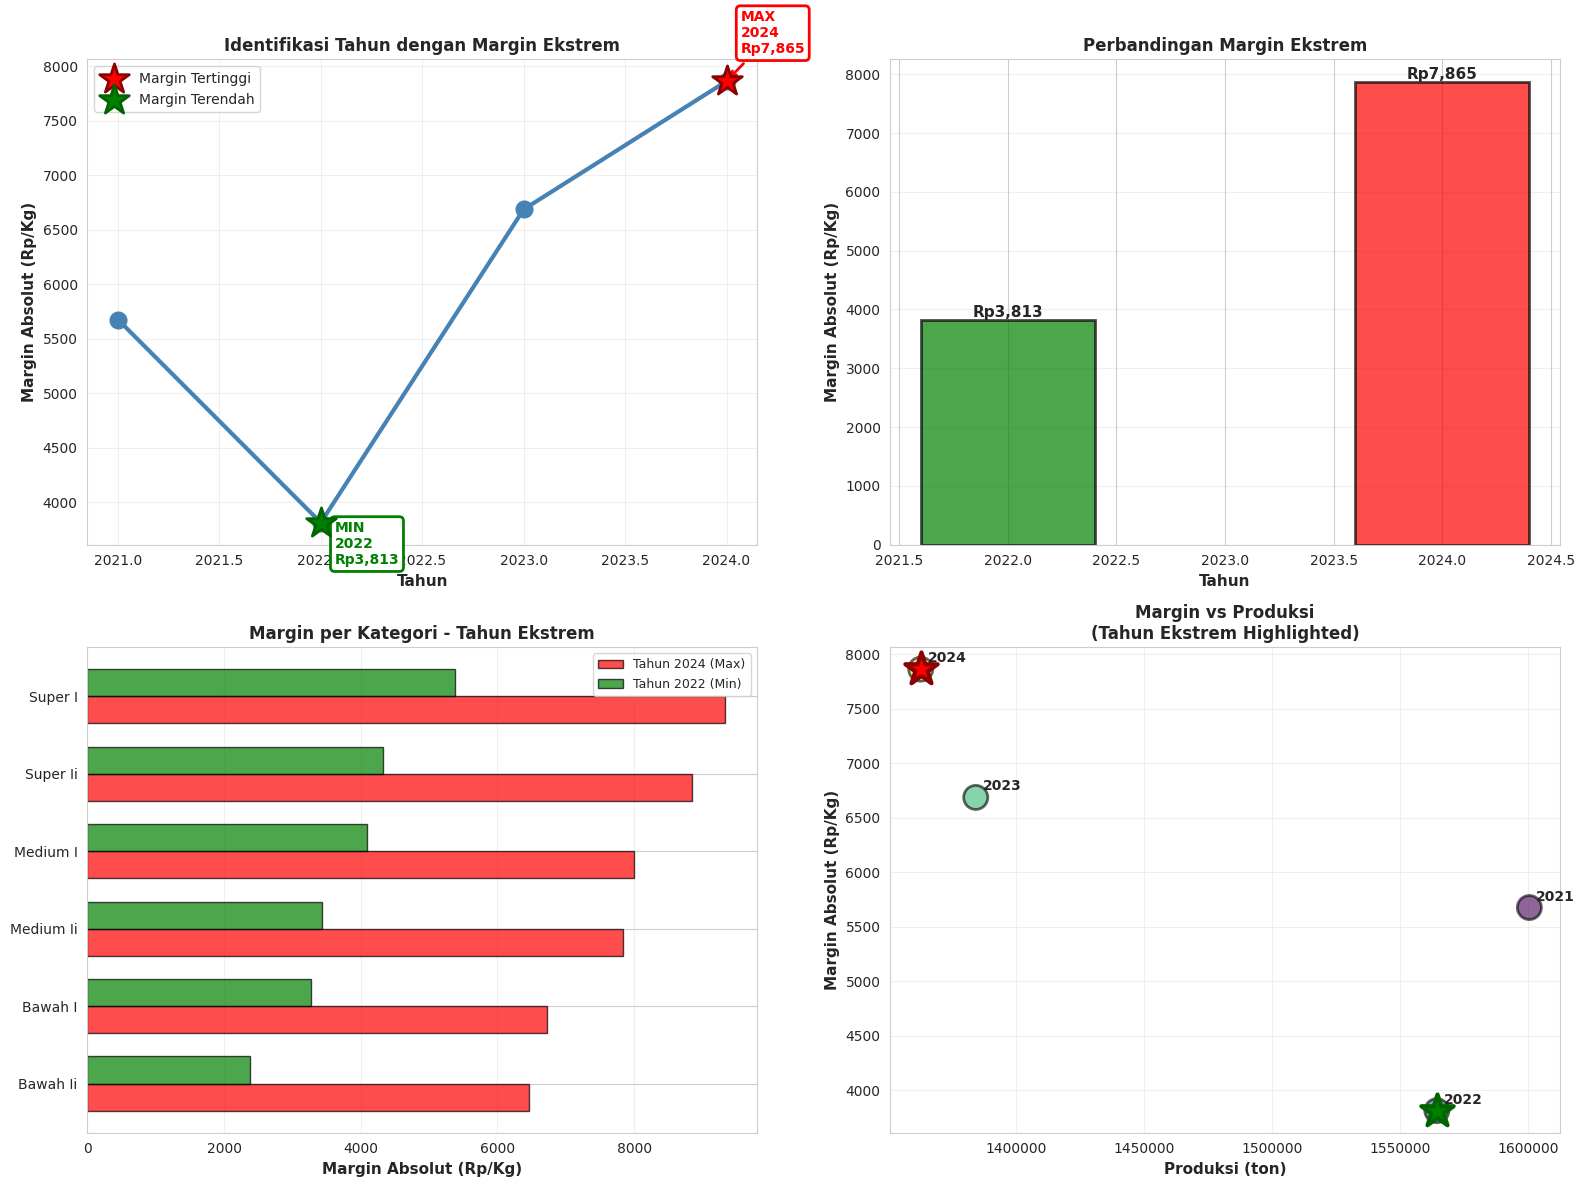


Visualisasi disimpan: insight_margin_ekstrem.png


In [ ]:
# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Timeline dengan highlight extremes
axes[0, 0].plot(margin_yearly['Tahun'], margin_yearly['Margin Absolut (Rp/Kg)'],
               marker='o', linewidth=3, markersize=12, color='steelblue')

# Highlight extremes
axes[0, 0].scatter([max_margin_year['Tahun']], [max_margin_year['Margin Absolut (Rp/Kg)']],
                  s=500, color='red', marker='*', edgecolors='darkred', linewidth=2,
                  label='Margin Tertinggi', zorder=5)
axes[0, 0].scatter([min_margin_year['Tahun']], [min_margin_year['Margin Absolut (Rp/Kg)']],
                  s=500, color='green', marker='*', edgecolors='darkgreen', linewidth=2,
                  label='Margin Terendah', zorder=5)

axes[0, 0].annotate(f"MAX\n{int(max_margin_year['Tahun'])}\nRp{max_margin_year['Margin Absolut (Rp/Kg)']:,.0f}",
                   xy=(max_margin_year['Tahun'], max_margin_year['Margin Absolut (Rp/Kg)']),
                   xytext=(10, 20), textcoords='offset points',
                   fontsize=10, fontweight='bold', color='red',
                   bbox=dict(boxstyle='round', facecolor='white', edgecolor='red', linewidth=2),
                   arrowprops=dict(arrowstyle='->', color='red', linewidth=2))

axes[0, 0].annotate(f"MIN\n{int(min_margin_year['Tahun'])}\nRp{min_margin_year['Margin Absolut (Rp/Kg)']:,.0f}",
                   xy=(min_margin_year['Tahun'], min_margin_year['Margin Absolut (Rp/Kg)']),
                   xytext=(10, -30), textcoords='offset points',
                   fontsize=10, fontweight='bold', color='green',
                   bbox=dict(boxstyle='round', facecolor='white', edgecolor='green', linewidth=2),
                   arrowprops=dict(arrowstyle='->', color='green', linewidth=2))

axes[0, 0].set_xlabel('Tahun', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Identifikasi Tahun dengan Margin Ekstrem',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Comparison bar chart
years = [int(max_margin_year['Tahun']), int(min_margin_year['Tahun'])]
margins = [max_margin_year['Margin Absolut (Rp/Kg)'], min_margin_year['Margin Absolut (Rp/Kg)']]
colors_bar = ['red', 'green']

bars = axes[0, 1].bar(years, margins, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Tahun', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Perbandingan Margin Ekstrem', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

for bar, margin in zip(bars, margins):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, height,
                   f'Rp{margin:,.0f}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

# Margin distribution per kategori - tahun ekstrem
margin_max_cat = df_margin_detail[df_margin_detail['Tahun'] == max_margin_year['Tahun']].groupby('Kategori')['Margin Absolut (Rp/Kg)'].mean().sort_values()
margin_min_cat = df_margin_detail[df_margin_detail['Tahun'] == min_margin_year['Tahun']].groupby('Kategori')['Margin Absolut (Rp/Kg)'].mean().sort_values()

x = np.arange(len(margin_max_cat))
width = 0.35

bars1 = axes[1, 0].barh(x - width/2, margin_max_cat.values, width,
                        label=f'Tahun {int(max_margin_year["Tahun"])} (Max)',
                        color='red', alpha=0.7, edgecolor='black')
bars2 = axes[1, 0].barh(x + width/2, margin_min_cat.values, width,
                        label=f'Tahun {int(min_margin_year["Tahun"])} (Min)',
                        color='green', alpha=0.7, edgecolor='black')

axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels([k.replace('Beras Kualitas ', '') for k in margin_max_cat.index])
axes[1, 0].set_xlabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Margin per Kategori - Tahun Ekstrem', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best', fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Relationship dengan produksi
axes[1, 1].scatter(margin_yearly['Produksi (ton)'], margin_yearly['Margin Absolut (Rp/Kg)'],
                  s=300, alpha=0.6, c=margin_yearly['Tahun'], cmap='viridis',
                  edgecolors='black', linewidth=2)

axes[1, 1].scatter([max_margin_year['Produksi (ton)']], [max_margin_year['Margin Absolut (Rp/Kg)']],
                  s=600, color='red', marker='*', edgecolors='darkred', linewidth=3, zorder=5)
axes[1, 1].scatter([min_margin_year['Produksi (ton)']], [min_margin_year['Margin Absolut (Rp/Kg)']],
                  s=600, color='green', marker='*', edgecolors='darkgreen', linewidth=3, zorder=5)

for idx, row in margin_yearly.iterrows():
    axes[1, 1].annotate(f"{int(row['Tahun'])}",
                       xy=(row['Produksi (ton)'], row['Margin Absolut (Rp/Kg)']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold')

axes[1, 1].set_xlabel('Produksi (ton)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Margin vs Produksi\n(Tahun Ekstrem Highlighted)', fontsize=12, fontweight='bold')
axes[1, 1].ticklabel_format(style='plain', axis='x')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}insight_margin_ekstrem.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi disimpan: insight_margin_ekstrem.png")

###B. Analisis Hipotesis - Margin Melebar saat Produksi Turun

In [ ]:
# Hitung korelasi
correlation_value = df_yearly['Produksi (ton)'].corr(df_yearly['Margin Absolut (Rp/Kg)'])

print(f"\nHASIL UJI HIPOTESIS:")
print(f"   Koefisien Korelasi: {correlation_value:+.4f}")

# Statistical test (Pearson)
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'])

print(f"   P-value: {p_value:.4f}")
print(f"   Signifikansi: {'Ya (p < 0.05)' if p_value < 0.05 else 'Tidak (p >= 0.05)'}")


HASIL UJI HIPOTESIS:
   Koefisien Korelasi: -0.8095
   P-value: 0.1905
   Signifikansi: Tidak (p >= 0.05)


In [ ]:
# Detail per tahun
print("\nDETAIL PERUBAHAN PRODUKSI vs MARGIN PER TAHUN:")
print("=" * 80)

yearly_changes = df_yearly.copy()
yearly_changes['Δ Produksi'] = yearly_changes['Produksi (ton)'].diff()
yearly_changes['Δ Margin'] = yearly_changes['Margin Absolut (Rp/Kg)'].diff()
yearly_changes['Δ Produksi (%)'] = yearly_changes['Produksi (ton)'].pct_change() * 100
yearly_changes['Δ Margin (%)'] = yearly_changes['Margin Absolut (Rp/Kg)'].pct_change() * 100

for idx, row in yearly_changes.iterrows():
    if pd.notna(row['Δ Produksi']):
        year = int(row['Tahun'])
        prod_change = row['Δ Produksi (%)']
        margin_change = row['Δ Margin (%)']

        print(f"\n📅 Tahun {year}:")
        print(f"   Produksi: {prod_change:+.2f}% {'📉 TURUN' if prod_change < 0 else '📈 NAIK'}")
        print(f"   Margin  : {margin_change:+.2f}% {'📈 NAIK' if margin_change > 0 else '📉 TURUN'}")

        # Check if hypothesis holds
        if (prod_change < 0 and margin_change > 0):
            print(f"   ✅ Konsisten dengan hipotesis: Produksi turun → Margin naik")
        elif (prod_change > 0 and margin_change < 0):
            print(f"   ✅ Konsisten dengan hipotesis: Produksi naik → Margin turun")
        else:
            print(f"   ❌ Tidak konsisten dengan hipotesis")


DETAIL PERUBAHAN PRODUKSI vs MARGIN PER TAHUN:

📅 Tahun 2022:
   Produksi: -2.26% 📉 TURUN
   Margin  : -32.83% 📉 TURUN
   ❌ Tidak konsisten dengan hipotesis

📅 Tahun 2023:
   Produksi: -11.52% 📉 TURUN
   Margin  : +75.38% 📈 NAIK
   ✅ Konsisten dengan hipotesis: Produksi turun → Margin naik

📅 Tahun 2024:
   Produksi: -1.55% 📉 TURUN
   Margin  : +17.59% 📈 NAIK
   ✅ Konsisten dengan hipotesis: Produksi turun → Margin naik


**Visualisasi**

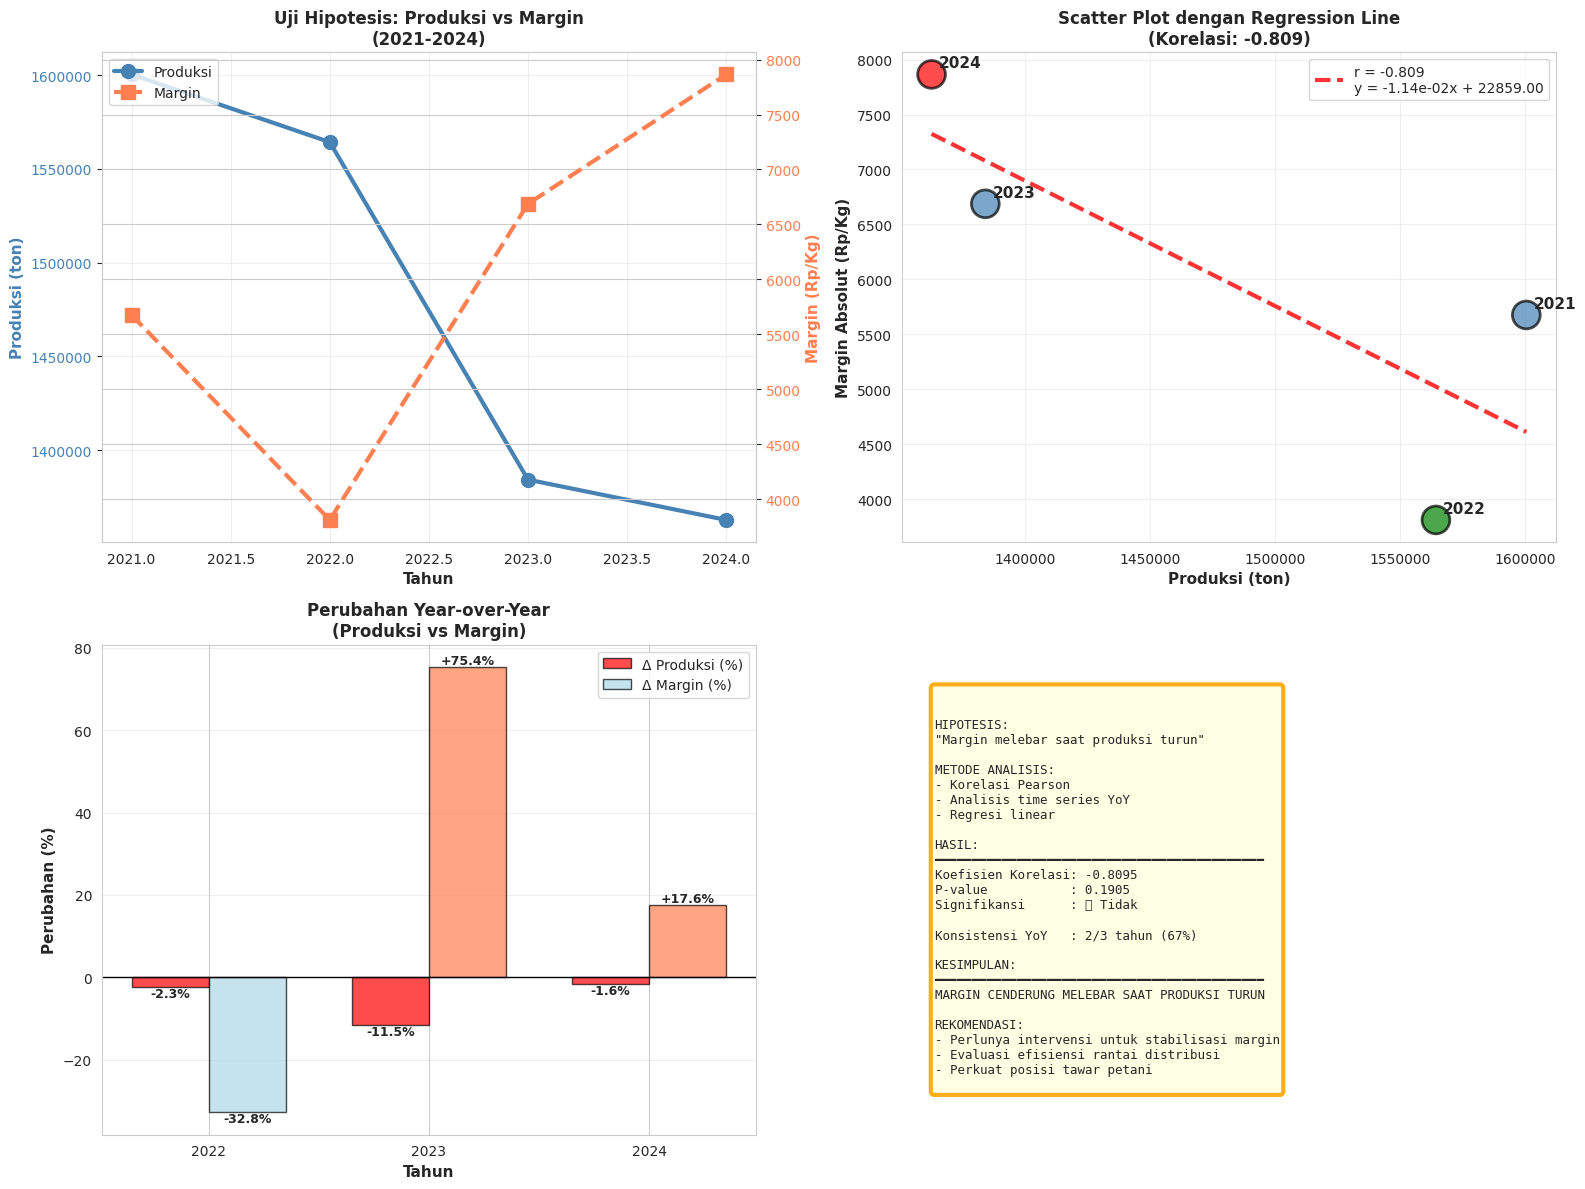


✅ Visualisasi disimpan: insight_hipotesis_analysis.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Dual axis: Produksi vs Margin
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

line1 = ax1.plot(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
                marker='o', linewidth=3, markersize=10, color='steelblue',
                label='Produksi')
line2 = ax1_twin.plot(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
                      marker='s', linewidth=3, markersize=10, color='coral',
                      label='Margin', linestyle='--')

ax1.set_xlabel('Tahun', fontsize=11, fontweight='bold')
ax1.set_ylabel('Produksi (ton)', fontsize=11, fontweight='bold', color='steelblue')
ax1_twin.set_ylabel('Margin (Rp/Kg)', fontsize=11, fontweight='bold', color='coral')
ax1.set_title('Uji Hipotesis: Produksi vs Margin\n(2021-2024)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1_twin.tick_params(axis='y', labelcolor='coral')
ax1.ticklabel_format(style='plain', axis='y')
ax1.grid(True, alpha=0.3)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Scatter dengan regression
axes[0, 1].scatter(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'],
                  s=400, alpha=0.7, c=['red' if i == df_yearly['Margin Absolut (Rp/Kg)'].idxmax()
                                       else 'green' if i == df_yearly['Margin Absolut (Rp/Kg)'].idxmin()
                                       else 'steelblue' for i in range(len(df_yearly))],
                  edgecolors='black', linewidth=2)

# Regression line
z = np.polyfit(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_yearly['Produksi (ton)'].min(), df_yearly['Produksi (ton)'].max(), 100)
axes[0, 1].plot(x_line, p(x_line), "r--", linewidth=3, alpha=0.8,
               label=f'r = {correlation_value:+.3f}\ny = {z[0]:.2e}x + {z[1]:.2f}')

# Annotate
for idx, row in df_yearly.iterrows():
    axes[0, 1].annotate(f"{int(row['Tahun'])}",
                       xy=(row['Produksi (ton)'], row['Margin Absolut (Rp/Kg)']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=11, fontweight='bold')

axes[0, 1].set_xlabel('Produksi (ton)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Margin Absolut (Rp/Kg)', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Scatter Plot dengan Regression Line\n(Korelasi: {correlation_value:+.3f})',
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].ticklabel_format(style='plain', axis='x')

# Perubahan YoY
x = np.arange(len(yearly_changes['Tahun'][1:]))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, yearly_changes['Δ Produksi (%)'][1:],
                       width, label='Δ Produksi (%)',
                       color=['red' if v < 0 else 'green' for v in yearly_changes['Δ Produksi (%)'][1:]],
                       alpha=0.7, edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, yearly_changes['Δ Margin (%)'][1:],
                       width, label='Δ Margin (%)',
                       color=['coral' if v > 0 else 'lightblue' for v in yearly_changes['Δ Margin (%)'][1:]],
                       alpha=0.7, edgecolor='black')

axes[1, 0].set_xlabel('Tahun', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Perubahan (%)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Perubahan Year-over-Year\n(Produksi vs Margin)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([int(y) for y in yearly_changes['Tahun'][1:]])
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.1:  # Only annotate significant changes
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, height,
                          f'{height:+.1f}%',
                          ha='center', va='bottom' if height > 0 else 'top',
                          fontsize=9, fontweight='bold')

# Summary box
axes[1, 1].axis('off')
consistent_count = 0
total_years = len(yearly_changes) - 1

for idx, row in yearly_changes.iterrows():
    if pd.notna(row['Δ Produksi']):
        if (row['Δ Produksi (%)'] < 0 and row['Δ Margin (%)'] > 0) or \
           (row['Δ Produksi (%)'] > 0 and row['Δ Margin (%)'] < 0):
            consistent_count += 1

consistency_rate = (consistent_count / total_years * 100) if total_years > 0 else 0

if correlation_value < -0.3:
    conclusion = 'MARGIN CENDERUNG MELEBAR SAAT PRODUKSI TURUN'
elif correlation_value > 0.3:
    conclusion = 'HIPOTESIS TIDAK TERDUKUNG OLEH DATA (HUBUNGAN BERBALIK)'
else:
    conclusion = 'HUBUNGAN TIDAK JELAS - FAKTOR LAIN DOMINAN'

summary_box = f"""

HIPOTESIS:
"Margin melebar saat produksi turun"

METODE ANALISIS:
- Korelasi Pearson
- Analisis time series YoY
- Regresi linear

HASIL:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Koefisien Korelasi: {correlation_value:+.4f}
P-value           : {p_value:.4f}
Signifikansi      : {'✅ Ya' if p_value < 0.05 else '❌ Tidak'}

Konsistensi YoY   : {consistent_count}/{total_years} tahun ({consistency_rate:.0f}%)

KESIMPULAN:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
{conclusion}

REKOMENDASI:
- {'Perlunya intervensi untuk stabilisasi margin' if correlation_value < -0.3 else 'Analisis faktor lain yang mempengaruhi margin'}
- {'Evaluasi efisiensi rantai distribusi' if correlation_value < -0.3 else 'Monitoring inflasi dan biaya produksi'}
- {'Perkuat posisi tawar petani' if correlation_value < -0.3 else 'Kajian dampak kebijakan pemerintah'}
"""

axes[1, 1].text(0.05, 0.5, summary_box, fontsize=9, family='monospace',
               verticalalignment='center',
               bbox=dict(boxstyle='round', facecolor='lightyellow',
                        edgecolor='orange', linewidth=3, alpha=0.9))

plt.tight_layout()
plt.savefig(f'{visualisasi_path}insight_hipotesis_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi disimpan: insight_hipotesis_analysis.png")

###C.  Identifikasi Anomali dan Pola Menarik

In [ ]:
from scipy import stats as scipy_stats

#Anomali menggunakan Z-score
df_margin_detail['Margin_Zscore'] = np.abs(scipy_stats.zscore(df_margin_detail['Margin Absolut (Rp/Kg)']))
anomalies = df_margin_detail[df_margin_detail['Margin_Zscore'] > 2]

print(f"\nANOMALI TERDETEKSI (Z-score > 2):")
if len(anomalies) > 0:
    print(f"   Jumlah: {len(anomalies)} data point")
    print("\n   Detail:")
    for idx, row in anomalies.iterrows():
        print(f"   • {int(row['Tahun'])} - {row['Kategori']}: Rp{row['Margin Absolut (Rp/Kg)']:,.0f} (Z={row['Margin_Zscore']:.2f})")
else:
    print("   ✅ Tidak ada anomali signifikan terdeteksi")

# Pola Menarik - Volatilitas per tahun
print(f"\nVOLATILITAS MARGIN PER TAHUN:")
volatility_by_year = df_margin_detail.groupby('Tahun')['Margin Absolut (Rp/Kg)'].std()
print(volatility_by_year.round(2))

most_volatile_year = volatility_by_year.idxmax()
least_volatile_year = volatility_by_year.idxmin()

print(f"\n   Tahun PALING volatile: {int(most_volatile_year)} (Std={volatility_by_year[most_volatile_year]:.2f})")
print(f"   Tahun PALING stabil  : {int(least_volatile_year)} (Std={volatility_by_year[least_volatile_year]:.2f})")





ANOMALI TERDETEKSI (Z-score > 2):
   Jumlah: 1 data point

   Detail:
   • 2022 - Beras Kualitas Bawah Ii: Rp2,384 (Z=2.05)

VOLATILITAS MARGIN PER TAHUN:
Tahun
2021    975.40
2022   1027.21
2023   1057.25
2024   1131.79
Name: Margin Absolut (Rp/Kg), dtype: float64

   Tahun PALING volatile: 2024 (Std=1131.79)
   Tahun PALING stabil  : 2021 (Std=975.40)


In [ ]:
# Pola Seasonal/Cyclical (jika ada data bulanan - simulasi dengan kategori)
print(f"\nPOLA BERDASARKAN KATEGORI BERAS:")
category_patterns = df_margin_detail.groupby('Kategori').agg({
    'Margin Absolut (Rp/Kg)': ['mean', 'std', 'min', 'max']
}).round(2)
category_patterns.columns = ['Mean', 'Std', 'Min', 'Max']
category_patterns['Range'] = category_patterns['Max'] - category_patterns['Min']
category_patterns['CV (%)'] = (category_patterns['Std'] / category_patterns['Mean'] * 100).round(2)

print(category_patterns.sort_values('CV (%)', ascending=False))

# Pola Menarik - Rasio harga
df_margin_detail['Rasio_Beras_Gabah'] = df_margin_detail['Harga Beras (Rp/Kg)'] / df_margin_detail['Harga Gabah (Rp/Kg)']

print(f"\nRASIO HARGA BERAS/GABAH:")
print(f"   Rata-rata: {df_margin_detail['Rasio_Beras_Gabah'].mean():.3f}x")
print(f"   Min: {df_margin_detail['Rasio_Beras_Gabah'].min():.3f}x")
print(f"   Max: {df_margin_detail['Rasio_Beras_Gabah'].max():.3f}x")


POLA BERDASARKAN KATEGORI BERAS:
                            Mean     Std     Min     Max   Range  CV (%)
Kategori                                                                
Beras Kualitas Bawah Ii  4669.14 1732.17 2383.51 6460.45 4076.94   37.10
Beras Kualitas Medium Ii 5794.14 1936.91 3266.84 7839.61 4572.77   33.43
Beras Kualitas Super Ii  6763.93 2019.83 4083.51 8839.61 4756.10   29.86
Beras Kualitas Bawah I   5158.72 1385.87 3437.67 6718.78 3281.11   26.86
Beras Kualitas Medium I  6229.55 1559.09 4329.34 7997.95 3668.61   25.03
Beras Kualitas Super I   7449.34 1679.00 5379.34 9331.28 3951.94   22.54

RASIO HARGA BERAS/GABAH:
   Rata-rata: 1.960x
   Min: 1.429x
   Max: 2.366x


**Visualisasi**

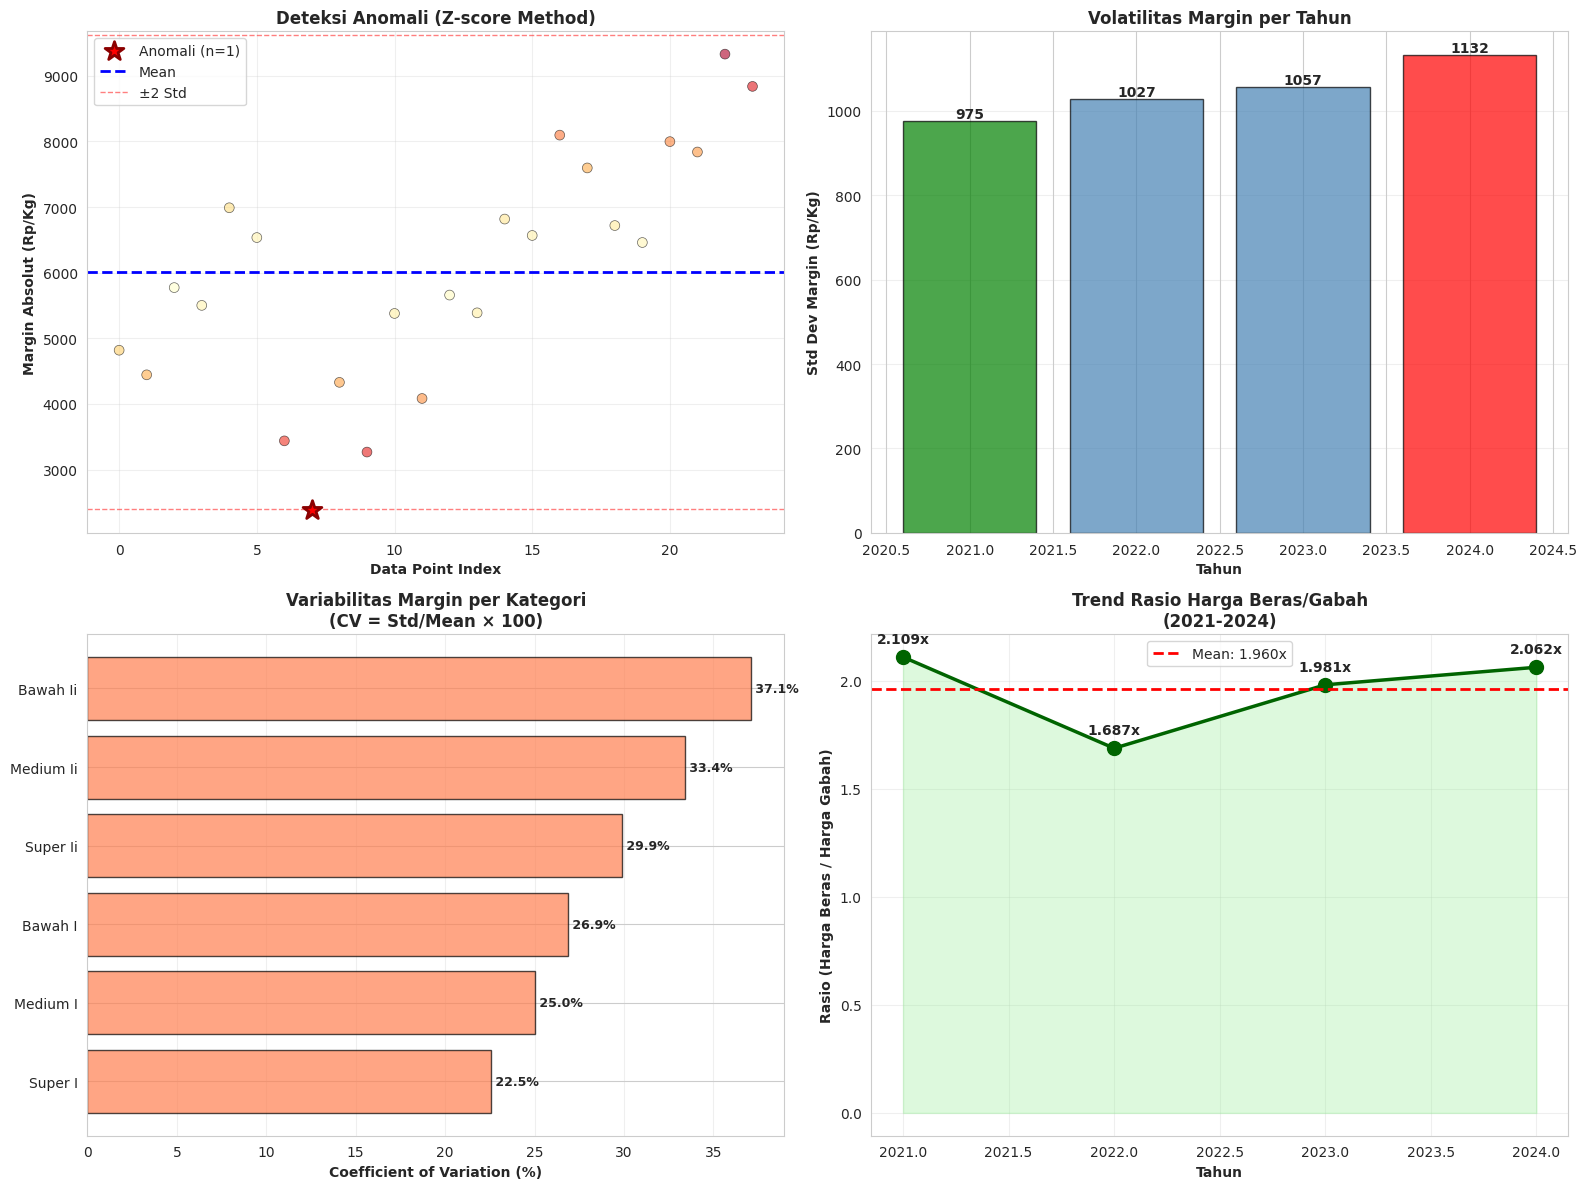


✅ Visualisasi disimpan: insight_anomali_pola.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Anomali detection plot
axes[0, 0].scatter(range(len(df_margin_detail)), df_margin_detail['Margin Absolut (Rp/Kg)'],
                  c=df_margin_detail['Margin_Zscore'], cmap='YlOrRd',
                  s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

if len(anomalies) > 0:
    axes[0, 0].scatter(anomalies.index, anomalies['Margin Absolut (Rp/Kg)'],
                      s=200, marker='*', color='red', edgecolors='darkred',
                      linewidth=2, label=f'Anomali (n={len(anomalies)})', zorder=5)

axes[0, 0].axhline(y=df_margin_detail['Margin Absolut (Rp/Kg)'].mean(),
                  color='blue', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axhline(y=df_margin_detail['Margin Absolut (Rp/Kg)'].mean() + 2*df_margin_detail['Margin Absolut (Rp/Kg)'].std(),
                  color='red', linestyle='--', linewidth=1, alpha=0.5, label='±2 Std')
axes[0, 0].axhline(y=df_margin_detail['Margin Absolut (Rp/Kg)'].mean() - 2*df_margin_detail['Margin Absolut (Rp/Kg)'].std(),
                  color='red', linestyle='--', linewidth=1, alpha=0.5)

axes[0, 0].set_xlabel('Data Point Index', fontweight='bold')
axes[0, 0].set_ylabel('Margin Absolut (Rp/Kg)', fontweight='bold')
axes[0, 0].set_title('Deteksi Anomali (Z-score Method)', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)

# Volatilitas per tahun
axes[0, 1].bar(volatility_by_year.index, volatility_by_year.values,
              color=['red' if y == most_volatile_year else 'green' if y == least_volatile_year
                     else 'steelblue' for y in volatility_by_year.index],
              edgecolor='black', alpha=0.7)

axes[0, 1].set_xlabel('Tahun', fontweight='bold')
axes[0, 1].set_ylabel('Std Dev Margin (Rp/Kg)', fontweight='bold')
axes[0, 1].set_title('Volatilitas Margin per Tahun', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

for year, vol in volatility_by_year.items():
    axes[0, 1].text(year, vol, f'{vol:.0f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

#  Coefficient of Variation per kategori
cv_sorted = category_patterns.sort_values('CV (%)', ascending=True)
axes[1, 0].barh(range(len(cv_sorted)), cv_sorted['CV (%)'],
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(cv_sorted)))
axes[1, 0].set_yticklabels([k.replace('Beras Kualitas ', '') for k in cv_sorted.index])
axes[1, 0].set_xlabel('Coefficient of Variation (%)', fontweight='bold')
axes[1, 0].set_title('Variabilitas Margin per Kategori\n(CV = Std/Mean × 100)',
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

for i, val in enumerate(cv_sorted['CV (%)']):
    axes[1, 0].text(val, i, f' {val:.1f}%', va='center', fontweight='bold', fontsize=9)

# Rasio Harga Beras/Gabah trend
rasio_by_year = df_margin_detail.groupby('Tahun')['Rasio_Beras_Gabah'].mean()
axes[1, 1].plot(rasio_by_year.index, rasio_by_year.values,
               marker='o', linewidth=2.5, markersize=10, color='darkgreen')
axes[1, 1].fill_between(rasio_by_year.index, rasio_by_year.values,
                        alpha=0.3, color='lightgreen')

for year, ratio in rasio_by_year.items():
    axes[1, 1].annotate(f'{ratio:.3f}x',
                       xy=(year, ratio),
                       xytext=(0, 10), textcoords='offset points',
                       ha='center', fontsize=10, fontweight='bold')

axes[1, 1].set_xlabel('Tahun', fontweight='bold')
axes[1, 1].set_ylabel('Rasio (Harga Beras / Harga Gabah)', fontweight='bold')
axes[1, 1].set_title('Trend Rasio Harga Beras/Gabah\n(2021-2024)',
                     fontsize=12, fontweight='bold')
axes[1, 1].axhline(y=rasio_by_year.mean(), color='red', linestyle='--',
                  linewidth=2, label=f'Mean: {rasio_by_year.mean():.3f}x')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}insight_anomali_pola.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi disimpan: insight_anomali_pola.png")

#**5. Visualization & Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:.2f}'.format)

# Load data
df_margin_detail = pd.read_csv(f'{dataset_path}dataset_margin_detail.csv')
df_yearly = pd.read_csv(f'{dataset_path}dataset_yearly_aggregate.csv')
correlation_dataset = pd.read_csv(f'{dataset_path}correlation_dataset.csv', index_col=0)

##5.1 Visualisasi Time Series

###A. Line Chart Trend Produksi Padi

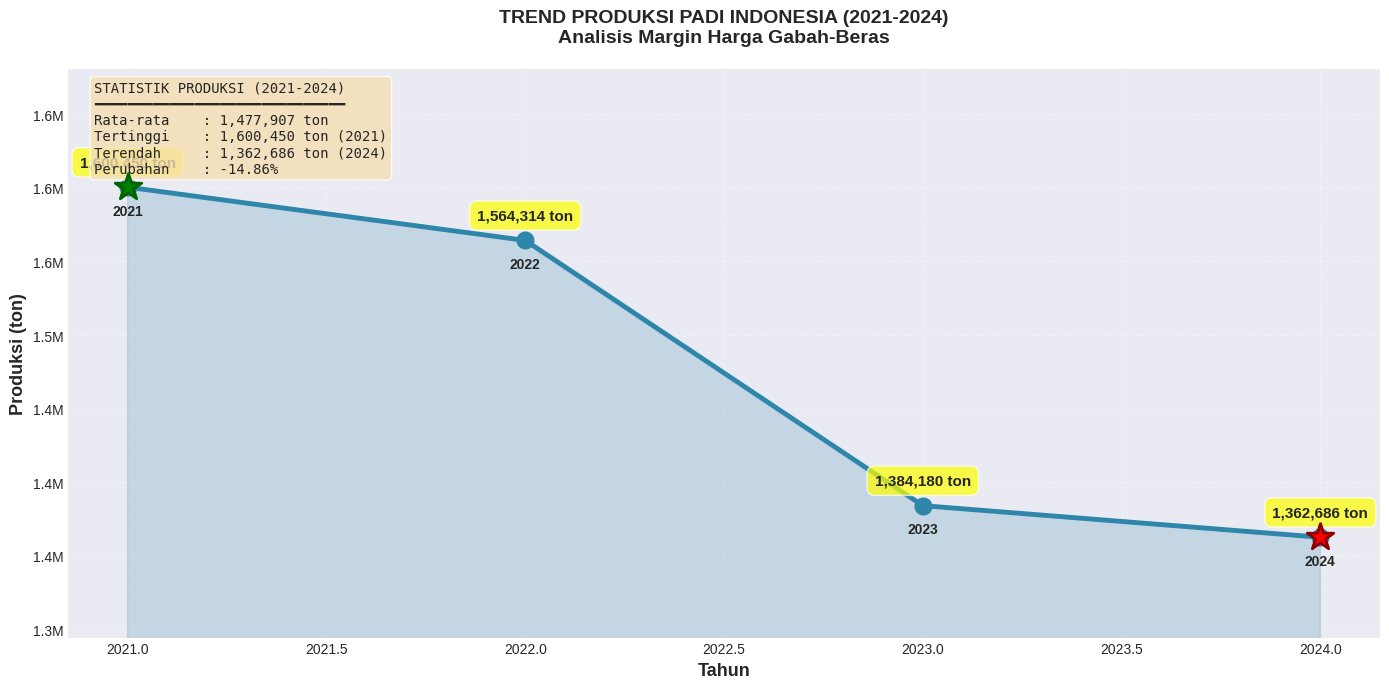

Visualisasi disimpan: ts_produksi_padi.png


In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

# Main line
line = ax.plot(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
               marker='o', linewidth=3.5, markersize=12,
               color='#2E86AB', label='Produksi Padi', zorder=3)

# Fill area
ax.fill_between(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
                alpha=0.2, color='#2E86AB', zorder=1)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, zorder=0)

# Annotations
for idx, row in df_yearly.iterrows():
    ax.annotate(f"{row['Produksi (ton)']:,.0f} ton",
               xy=(row['Tahun'], row['Produksi (ton)']),
               xytext=(0, 15), textcoords='offset points',
               ha='center', fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

    # Year label
    ax.annotate(f"{int(row['Tahun'])}",
               xy=(row['Tahun'], row['Produksi (ton)']),
               xytext=(0, -20), textcoords='offset points',
               ha='center', fontsize=10, fontweight='bold')

# Highlight min dan max
max_idx = df_yearly['Produksi (ton)'].idxmax()
min_idx = df_yearly['Produksi (ton)'].idxmin()

ax.scatter(df_yearly.loc[max_idx, 'Tahun'], df_yearly.loc[max_idx, 'Produksi (ton)'],
          s=400, color='green', marker='*', edgecolors='darkgreen', linewidth=2, zorder=5)
ax.scatter(df_yearly.loc[min_idx, 'Tahun'], df_yearly.loc[min_idx, 'Produksi (ton)'],
          s=400, color='red', marker='*', edgecolors='darkred', linewidth=2, zorder=5)

# Labels dan title
ax.set_xlabel('Tahun', fontsize=13, fontweight='bold')
ax.set_ylabel('Produksi (ton)', fontsize=13, fontweight='bold')
ax.set_title('TREND PRODUKSI PADI INDONESIA (2021-2024)\nAnalisis Margin Harga Gabah-Beras',
            fontsize=14, fontweight='bold', pad=20)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.set_ylim(df_yearly['Produksi (ton)'].min() * 0.95, df_yearly['Produksi (ton)'].max() * 1.05)

# Add statistics box
stats_text = f"""STATISTIK PRODUKSI (2021-2024)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Rata-rata    : {df_yearly['Produksi (ton)'].mean():,.0f} ton
Tertinggi    : {df_yearly['Produksi (ton)'].max():,.0f} ton ({int(df_yearly.loc[max_idx, 'Tahun'])})
Terendah     : {df_yearly['Produksi (ton)'].min():,.0f} ton ({int(df_yearly.loc[min_idx, 'Tahun'])})
Perubahan    : {(df_yearly['Produksi (ton)'].iloc[-1] / df_yearly['Produksi (ton)'].iloc[0] - 1)*100:+.2f}%"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', family='monospace',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{visualisasi_path}ts_produksi_padi.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan: ts_produksi_padi.png")

###B. Line Chart Trend Harga Gabah dan Beras


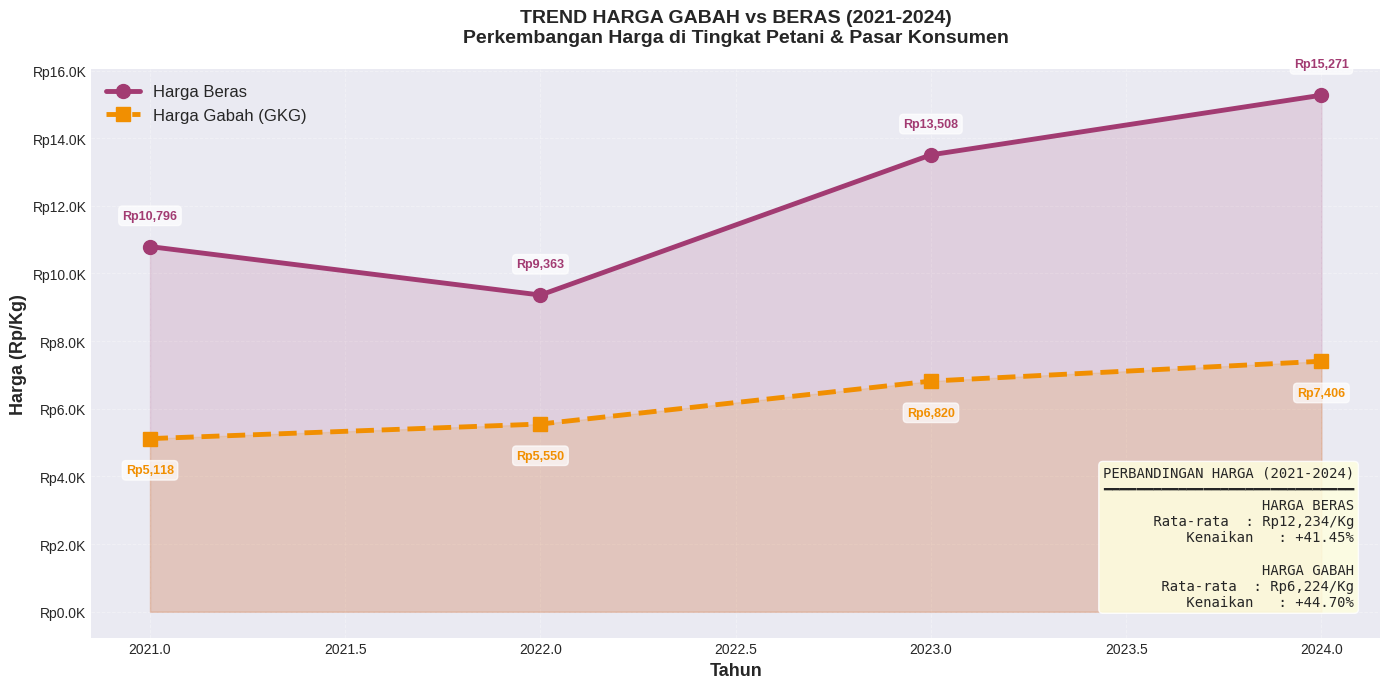

Visualisasi disimpan: ts_harga_gabah_beras.png


In [ ]:

fig, ax = plt.subplots(figsize=(14, 7))

# Plot harga beras
line1 = ax.plot(df_yearly['Tahun'], df_yearly['Harga Beras (Rp/Kg)'],
               marker='o', linewidth=3.5, markersize=10,
               color='#A23B72', label='Harga Beras', zorder=3)

# Plot harga gabah
line2 = ax.plot(df_yearly['Tahun'], df_yearly['Harga Gabah (Rp/Kg)'],
               marker='s', linewidth=3.5, markersize=10,
               color='#F18F01', label='Harga Gabah (GKG)', linestyle='--', zorder=3)

# Fill areas
ax.fill_between(df_yearly['Tahun'], df_yearly['Harga Beras (Rp/Kg)'],
                alpha=0.15, color='#A23B72', zorder=1)
ax.fill_between(df_yearly['Tahun'], df_yearly['Harga Gabah (Rp/Kg)'],
                alpha=0.15, color='#F18F01', zorder=1)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, zorder=0)

# Annotations
for idx, row in df_yearly.iterrows():
    # Harga Beras
    ax.annotate(f"Rp{row['Harga Beras (Rp/Kg)']:,.0f}",
               xy=(row['Tahun'], row['Harga Beras (Rp/Kg)']),
               xytext=(0, 20), textcoords='offset points',
               ha='center', fontsize=9, fontweight='bold',
               color='#A23B72',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # Harga Gabah
    ax.annotate(f"Rp{row['Harga Gabah (Rp/Kg)']:,.0f}",
               xy=(row['Tahun'], row['Harga Gabah (Rp/Kg)']),
               xytext=(0, -25), textcoords='offset points',
               ha='center', fontsize=9, fontweight='bold',
               color='#F18F01',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Labels
ax.set_xlabel('Tahun', fontsize=13, fontweight='bold')
ax.set_ylabel('Harga (Rp/Kg)', fontsize=13, fontweight='bold')
ax.set_title('TREND HARGA GABAH vs BERAS (2021-2024)\nPerkembangan Harga di Tingkat Petani & Pasar Konsumen',
            fontsize=14, fontweight='bold', pad=20)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'Rp{x/1000:.1f}K'))

# Legend
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)

# Statistics
stats_text = f"""PERBANDINGAN HARGA (2021-2024)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
HARGA BERAS
 Rata-rata  : Rp{df_yearly['Harga Beras (Rp/Kg)'].mean():,.0f}/Kg
 Kenaikan   : {(df_yearly['Harga Beras (Rp/Kg)'].iloc[-1] / df_yearly['Harga Beras (Rp/Kg)'].iloc[0] - 1)*100:+.2f}%

HARGA GABAH
 Rata-rata  : Rp{df_yearly['Harga Gabah (Rp/Kg)'].mean():,.0f}/Kg
 Kenaikan   : {(df_yearly['Harga Gabah (Rp/Kg)'].iloc[-1] / df_yearly['Harga Gabah (Rp/Kg)'].iloc[0] - 1)*100:+.2f}%"""

ax.text(0.98, 0.05, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='bottom', horizontalalignment='right',
       family='monospace',
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.85))

plt.tight_layout()
plt.savefig(f'{visualisasi_path}ts_harga_gabah_beras.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan: ts_harga_gabah_beras.png")

###C. Line Chart Trend Margin Harga

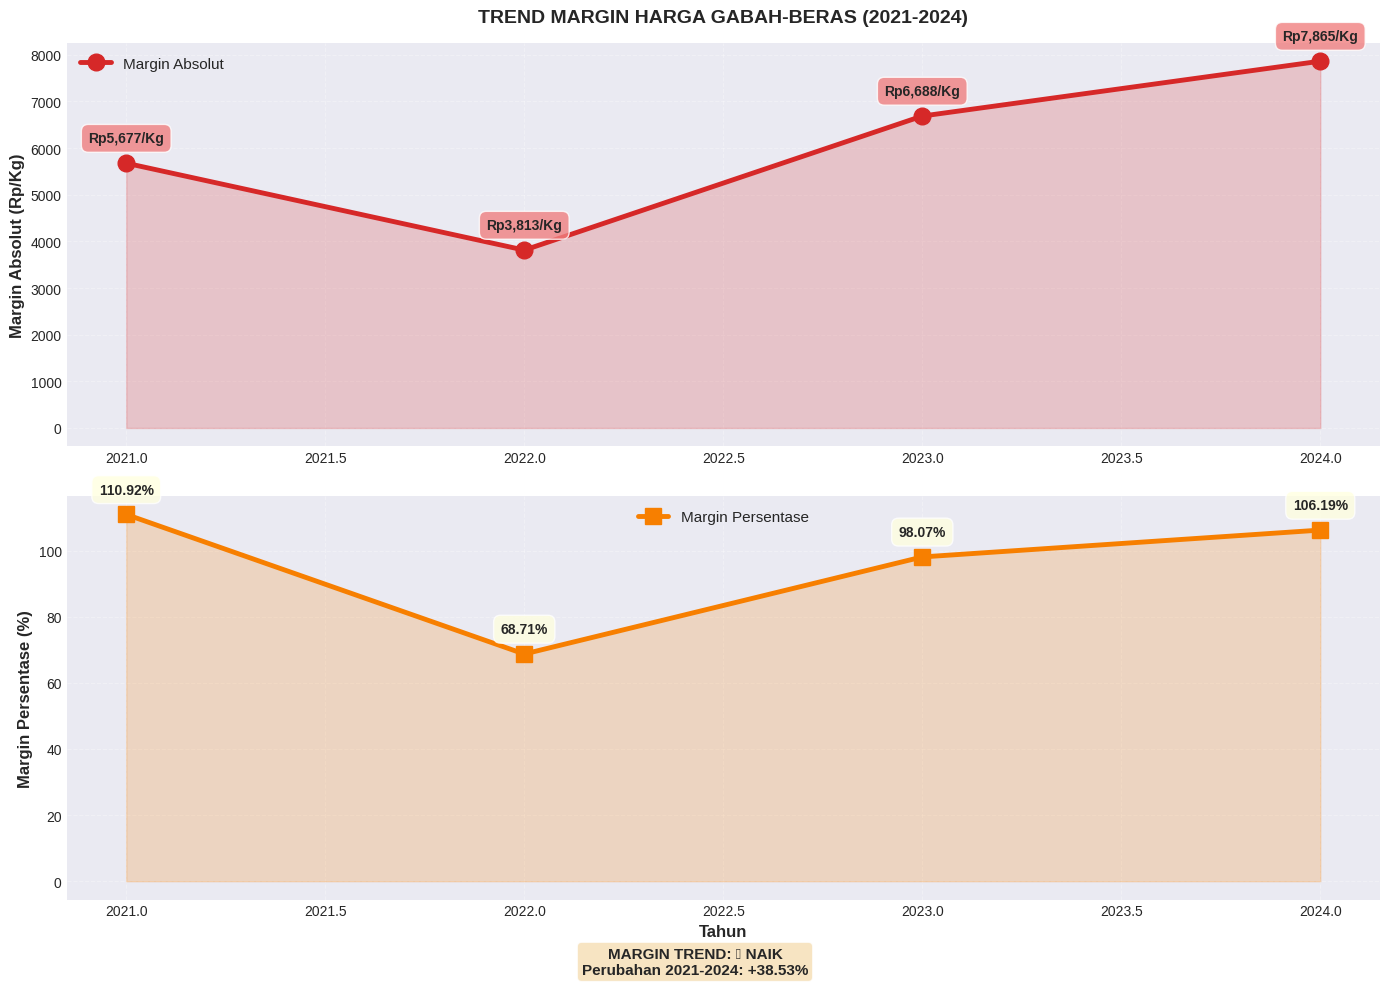

Visualisasi disimpan: ts_margin_harga.png


In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Margin Absolut
ax1.plot(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
        marker='o', linewidth=3.5, markersize=12,
        color='#D62828', label='Margin Absolut', zorder=3)
ax1.fill_between(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
                 alpha=0.2, color='#D62828', zorder=1)

# Annotations
for idx, row in df_yearly.iterrows():
    ax1.annotate(f"Rp{row['Margin Absolut (Rp/Kg)']:,.0f}/Kg",
                xy=(row['Tahun'], row['Margin Absolut (Rp/Kg)']),
                xytext=(0, 15), textcoords='offset points',
                ha='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.8))

ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylabel('Margin Absolut (Rp/Kg)', fontsize=12, fontweight='bold')
ax1.set_title('TREND MARGIN HARGA GABAH-BERAS (2021-2024)',
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='best', fontsize=11)

# Margin Persentase
ax2.plot(df_yearly['Tahun'], df_yearly['Margin Persentase (%)'],
        marker='s', linewidth=3.5, markersize=12,
        color='#F77F00', label='Margin Persentase', zorder=3)
ax2.fill_between(df_yearly['Tahun'], df_yearly['Margin Persentase (%)'],
                 alpha=0.2, color='#F77F00', zorder=1)

# Annotations
for idx, row in df_yearly.iterrows():
    ax2.annotate(f"{row['Margin Persentase (%)']:.2f}%",
                xy=(row['Tahun'], row['Margin Persentase (%)']),
                xytext=(0, 15), textcoords='offset points',
                ha='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlabel('Tahun', fontsize=12, fontweight='bold')
ax2.set_ylabel('Margin Persentase (%)', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=11)

# Add trend interpretation
margin_trend = "📈 NAIK" if df_yearly['Margin Absolut (Rp/Kg)'].iloc[-1] > df_yearly['Margin Absolut (Rp/Kg)'].iloc[0] else "📉 TURUN"
stats_text = f"""MARGIN TREND: {margin_trend}
Perubahan 2021-2024: {(df_yearly['Margin Absolut (Rp/Kg)'].iloc[-1] / df_yearly['Margin Absolut (Rp/Kg)'].iloc[0] - 1)*100:+.2f}%"""

fig.text(0.5, 0.02, stats_text, ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig(f'{visualisasi_path}ts_margin_harga.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan: ts_margin_harga.png")

###D. Overlay Chart - Produksi vs Margin

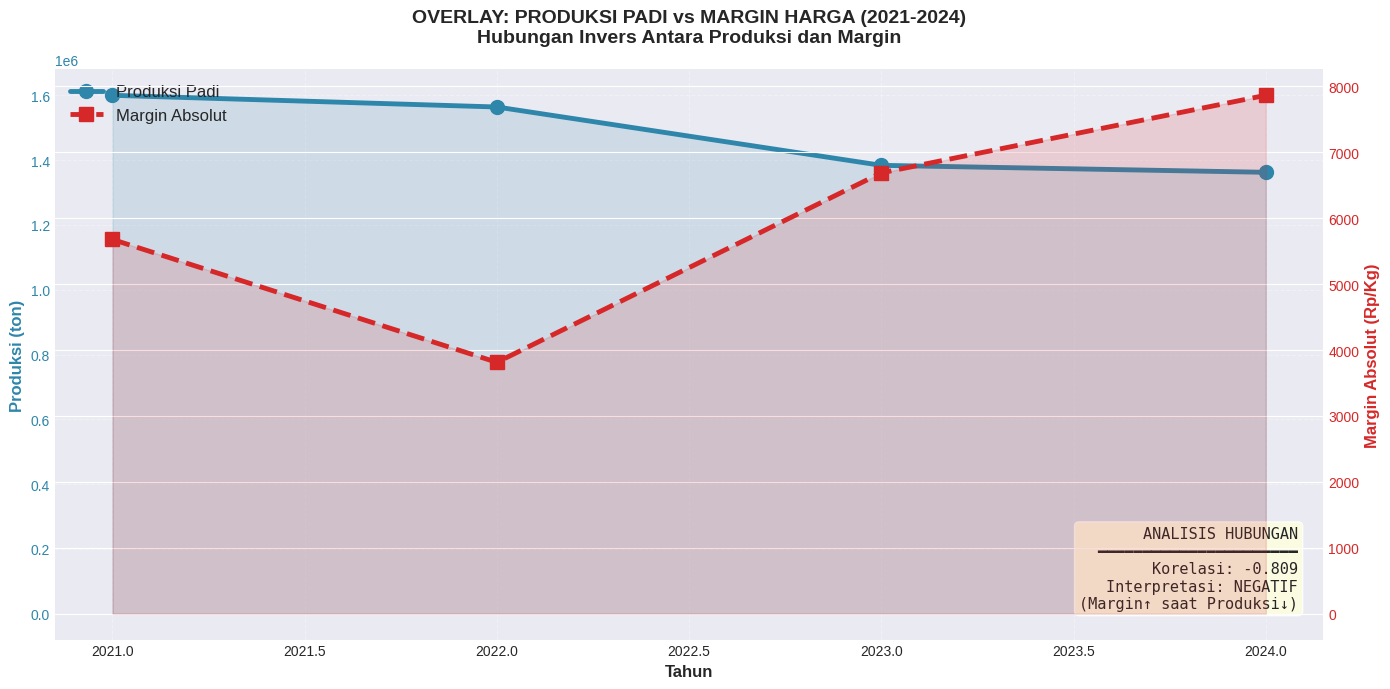

Visualisasi disimpan: ts_produksi_vs_margin_overlay.png


In [ ]:

fig, ax1 = plt.subplots(figsize=(14, 7))

# Produksi (left axis)
color1 = '#2E86AB'
ax1.set_xlabel('Tahun', fontsize=12, fontweight='bold')
ax1.set_ylabel('Produksi (ton)', fontsize=12, fontweight='bold', color=color1)
line1 = ax1.plot(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
                marker='o', linewidth=3.5, markersize=10,
                color=color1, label='Produksi Padi', zorder=3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.fill_between(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
                 alpha=0.15, color=color1, zorder=1)

# Margin (right axis)
ax2 = ax1.twinx()
color2 = '#D62828'
ax2.set_ylabel('Margin Absolut (Rp/Kg)', fontsize=12, fontweight='bold', color=color2)
line2 = ax2.plot(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
                marker='s', linewidth=3.5, markersize=10,
                color=color2, label='Margin Absolut', linestyle='--', zorder=3)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.fill_between(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
                 alpha=0.15, color=color2, zorder=1)

# Grid
ax1.grid(True, alpha=0.3, linestyle='--', zorder=0)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12, framealpha=0.95)

# Title
ax1.set_title('OVERLAY: PRODUKSI PADI vs MARGIN HARGA (2021-2024)\nHubungan Invers Antara Produksi dan Margin',
             fontsize=14, fontweight='bold', pad=20)

# Annotations untuk relationship
correlation_val = df_yearly['Produksi (ton)'].corr(df_yearly['Margin Absolut (Rp/Kg)'])
relationship = "NEGATIF\n(Margin↑ saat Produksi↓)" if correlation_val < -0.3 else "POSITIF\n(Margin↑ saat Produksi↑)" if correlation_val > 0.3 else "➡️ LEMAH"

annotation_text = f"""ANALISIS HUBUNGAN
━━━━━━━━━━━━━━━━━━━━━━
Korelasi: {correlation_val:+.3f}
Interpretasi: {relationship}"""

ax1.text(0.98, 0.05, annotation_text, transform=ax1.transAxes,
        fontsize=11, verticalalignment='bottom', horizontalalignment='right',
        family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.85))

plt.tight_layout()
plt.savefig(f'{visualisasi_path}ts_produksi_vs_margin_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan: ts_produksi_vs_margin_overlay.png")

##5.2 Visualisasi Komparatif

###A. Bar Chart Perbandingan Margin Antar Kategori

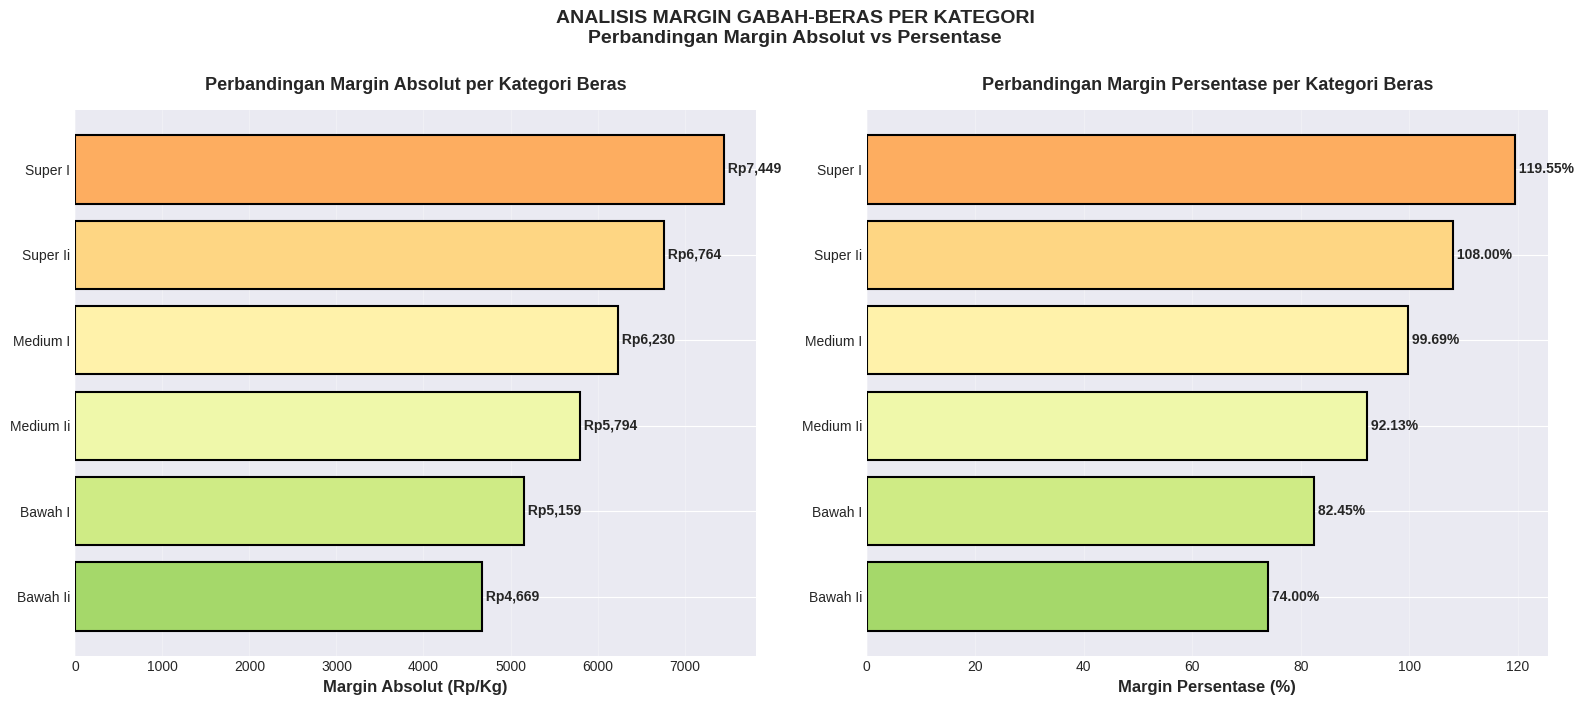

Visualisasi disimpan: comp_margin_per_kategori.png


In [ ]:

# Hitung rata-rata margin per kategori
margin_by_cat = df_margin_detail.groupby('Kategori').agg({
    'Margin Absolut (Rp/Kg)': 'mean',
    'Margin Persentase (%)': 'mean'
}).sort_values('Margin Absolut (Rp/Kg)', ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Margin Absolut
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(margin_by_cat)))
bars1 = ax1.barh(range(len(margin_by_cat)), margin_by_cat['Margin Absolut (Rp/Kg)'],
                color=colors, edgecolor='black', linewidth=1.5)

ax1.set_yticks(range(len(margin_by_cat)))
ax1.set_yticklabels([k.replace('Beras Kualitas ', '') for k in margin_by_cat.index])
ax1.set_xlabel('Margin Absolut (Rp/Kg)', fontsize=12, fontweight='bold')
ax1.set_title('Perbandingan Margin Absolut per Kategori Beras',
             fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')

# Annotate values
for i, (idx, row) in enumerate(margin_by_cat.iterrows()):
    ax1.text(row['Margin Absolut (Rp/Kg)'], i,
            f" Rp{row['Margin Absolut (Rp/Kg)']:,.0f}",
            va='center', fontweight='bold', fontsize=10)

# Margin Persentase
margin_pct_sorted = margin_by_cat.sort_values('Margin Persentase (%)', ascending=True)
bars2 = ax2.barh(range(len(margin_pct_sorted)), margin_pct_sorted['Margin Persentase (%)'],
                color=colors, edgecolor='black', linewidth=1.5)

ax2.set_yticks(range(len(margin_pct_sorted)))
ax2.set_yticklabels([k.replace('Beras Kualitas ', '') for k in margin_pct_sorted.index])
ax2.set_xlabel('Margin Persentase (%)', fontsize=12, fontweight='bold')
ax2.set_title('Perbandingan Margin Persentase per Kategori Beras',
             fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='x')

# Annotate values
for i, (idx, row) in enumerate(margin_pct_sorted.iterrows()):
    ax2.text(row['Margin Persentase (%)'], i,
            f" {row['Margin Persentase (%)']:.2f}%",
            va='center', fontweight='bold', fontsize=10)

plt.suptitle('ANALISIS MARGIN GABAH-BERAS PER KATEGORI\nPerbandingan Margin Absolut vs Persentase',
            fontsize=14, fontweight='bold', y=1.00)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}comp_margin_per_kategori.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan: comp_margin_per_kategori.png")

###C. Box Plot Distribusi Margin per Tahun

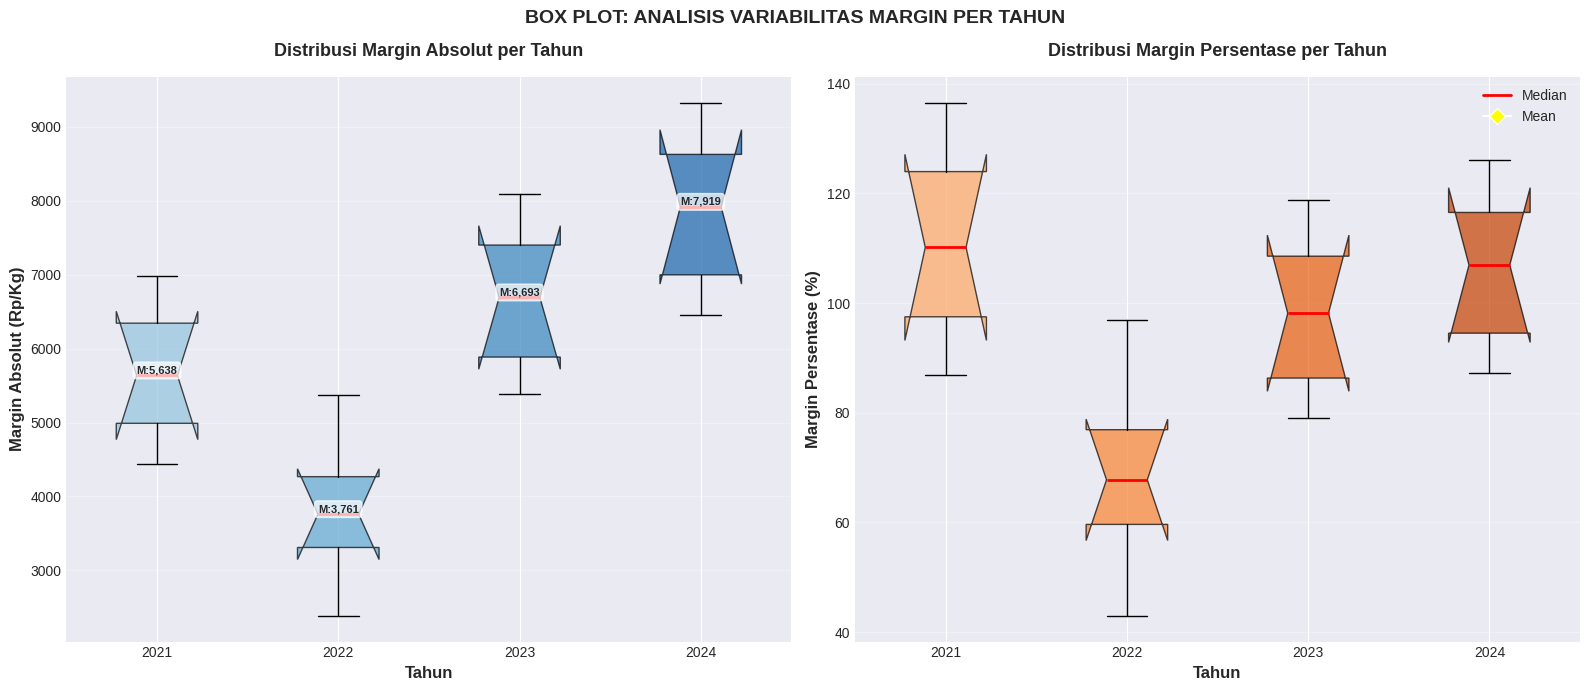

Visualisasi disimpan: comp_boxplot_margin_per_tahun.png


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Margin Absolut
bp1 = ax1.boxplot([df_margin_detail[df_margin_detail['Tahun'] == year]['Margin Absolut (Rp/Kg)'].values
                    for year in sorted(df_margin_detail['Tahun'].unique())],
                   labels=sorted(df_margin_detail['Tahun'].unique()),
                   patch_artist=True, notch=True,
                   medianprops=dict(color='red', linewidth=2),
                   meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))

for patch, color in zip(bp1['boxes'], plt.cm.Blues(np.linspace(0.4, 0.8, len(bp1['boxes'])))):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xlabel('Tahun', fontsize=12, fontweight='bold')
ax1.set_ylabel('Margin Absolut (Rp/Kg)', fontsize=12, fontweight='bold')
ax1.set_title('Distribusi Margin Absolut per Tahun',
             fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')

# Add statistics
for i, year in enumerate(sorted(df_margin_detail['Tahun'].unique()), 1):
    data = df_margin_detail[df_margin_detail['Tahun'] == year]['Margin Absolut (Rp/Kg)']
    median_val = data.median()
    ax1.text(i, median_val, f'M:{median_val:,.0f}', ha='center', va='bottom',
            fontsize=8, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Margin Persentase
bp2 = ax2.boxplot([df_margin_detail[df_margin_detail['Tahun'] == year]['Margin Persentase (%)'].values
                    for year in sorted(df_margin_detail['Tahun'].unique())],
                   labels=sorted(df_margin_detail['Tahun'].unique()),
                   patch_artist=True, notch=True,
                   medianprops=dict(color='red', linewidth=2),
                   meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))

for patch, color in zip(bp2['boxes'], plt.cm.Oranges(np.linspace(0.4, 0.8, len(bp2['boxes'])))):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_xlabel('Tahun', fontsize=12, fontweight='bold')
ax2.set_ylabel('Margin Persentase (%)', fontsize=12, fontweight='bold')
ax2.set_title('Distribusi Margin Persentase per Tahun',
             fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linewidth=2, label='Median'),
                   Line2D([0], [0], marker='D', color='w', markerfacecolor='yellow', markersize=8, label='Mean')]
ax2.legend(handles=legend_elements, loc='best', fontsize=10)

plt.suptitle('BOX PLOT: ANALISIS VARIABILITAS MARGIN PER TAHUN',
            fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig(f'{visualisasi_path}comp_boxplot_margin_per_tahun.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan: comp_boxplot_margin_per_tahun.png")

###D. Heatmap Korelasi Antar Variabel

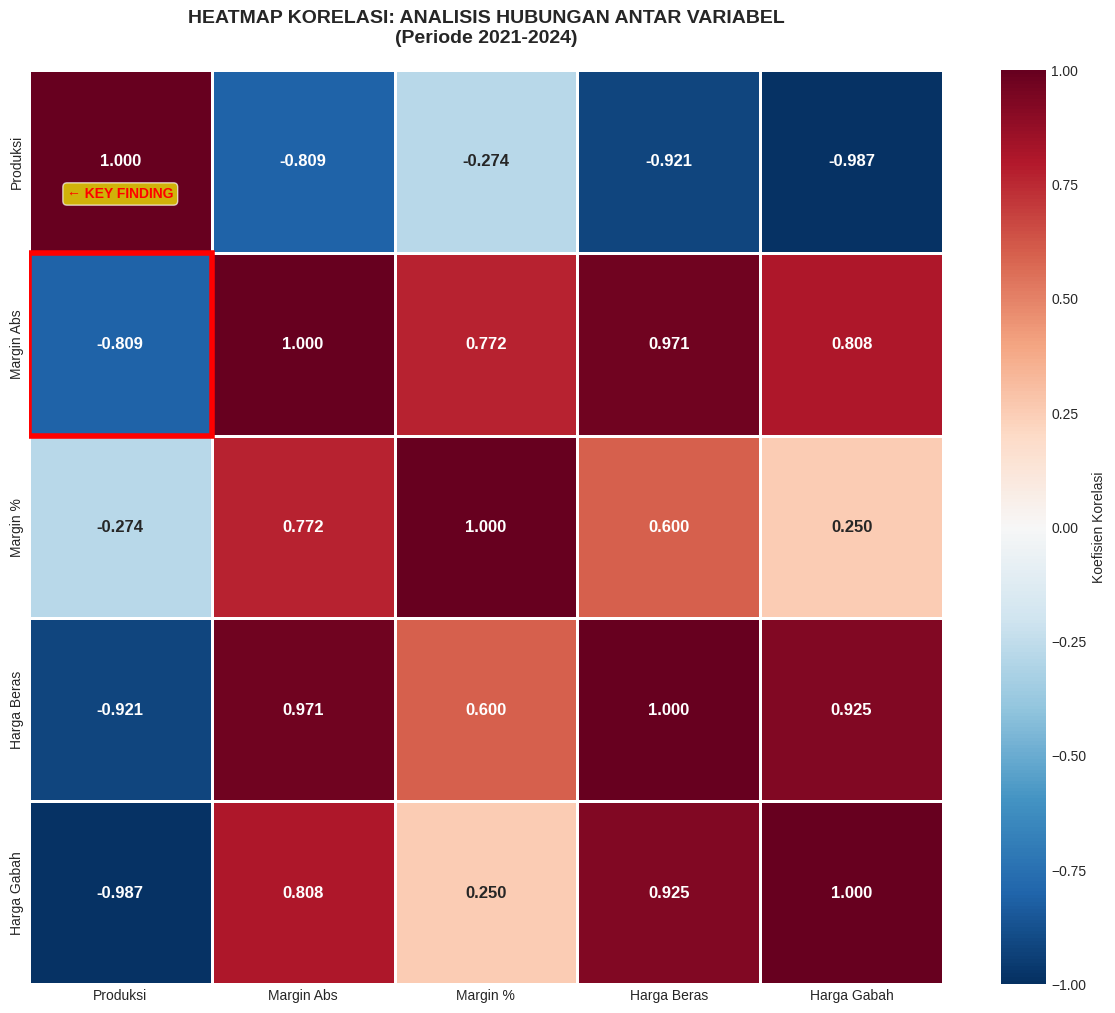

Visualisasi disimpan: comp_heatmap_korelasi.png


In [ ]:
# Hitung correlation matrix
corr_matrix = df_yearly[['Produksi (ton)', 'Margin Absolut (Rp/Kg)',
                          'Margin Persentase (%)', 'Harga Beras (Rp/Kg)',
                          'Harga Gabah (Rp/Kg)']].corr()

# Rename columns untuk display
corr_display = corr_matrix.copy()
corr_display.index = ['Produksi', 'Margin Abs', 'Margin %', 'Harga Beras', 'Harga Gabah']
corr_display.columns = ['Produksi', 'Margin Abs', 'Margin %', 'Harga Beras', 'Harga Gabah']

fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
sns.heatmap(corr_display, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
           square=True, linewidths=2, cbar_kws={'label': 'Koefisien Korelasi'},
           vmin=-1, vmax=1, ax=ax,
           annot_kws={'fontsize': 12, 'fontweight': 'bold'})

ax.set_title('HEATMAP KORELASI: ANALISIS HUBUNGAN ANTAR VARIABEL\n(Periode 2021-2024)',
            fontsize=14, fontweight='bold', pad=20)

# Highlight key correlations
# Margin vs Produksi
margin_prod_corr = corr_matrix.loc['Margin Absolut (Rp/Kg)', 'Produksi (ton)']
rect_x, rect_y = 0, 1  # Position in heatmap (row 1, col 0)
if margin_prod_corr < -0.3:
    rect = Rectangle((rect_x, rect_y), 1, 1, fill=False, edgecolor='red', linewidth=4, zorder=10)
    ax.add_patch(rect)
    ax.text(rect_x + 0.5, rect_y - 0.3, '← KEY FINDING', fontsize=10, fontweight='bold',
           ha='center', color='red', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig(f'{visualisasi_path}comp_heatmap_korelasi.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan: comp_heatmap_korelasi.png")

###E. Scatter Plot dengan Regression Line

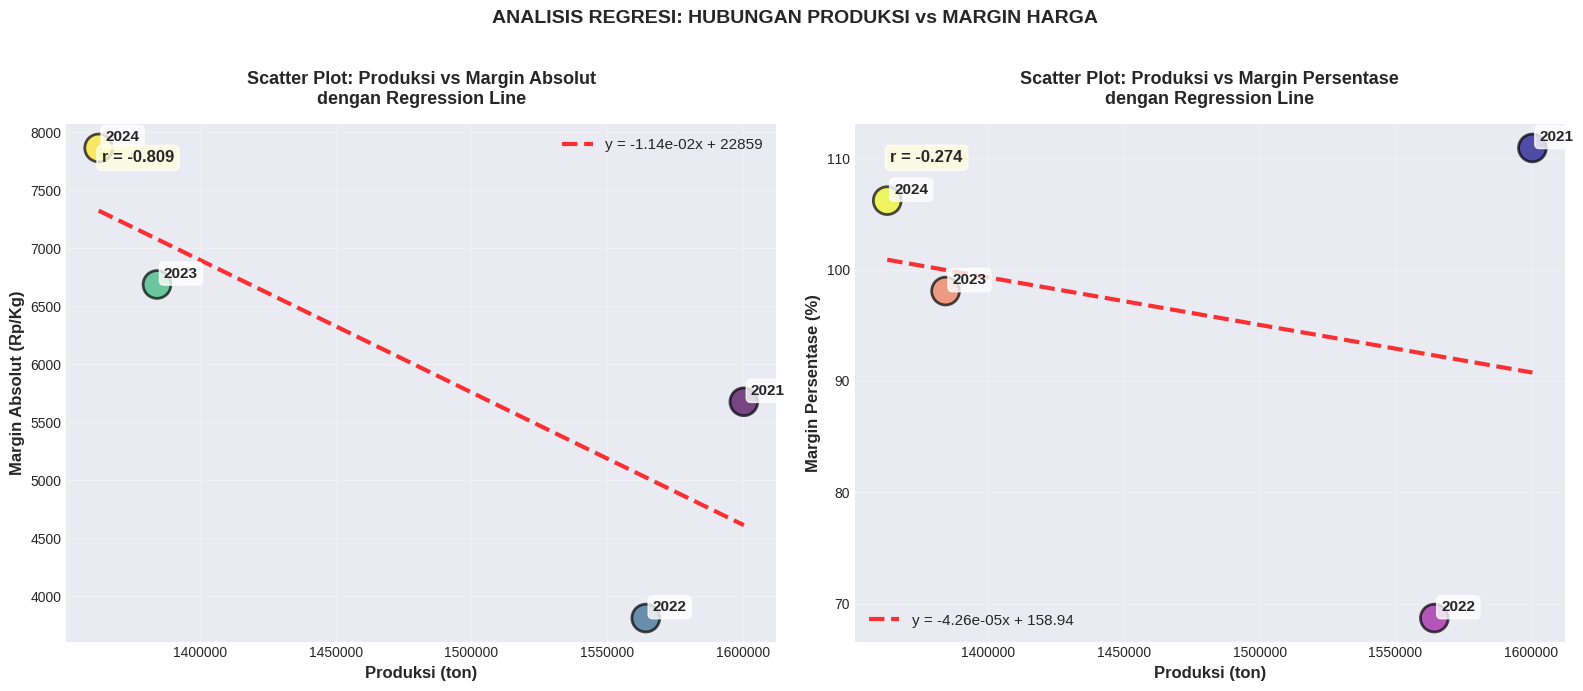

✅ Visualisasi disimpan: comp_scatter_regression.png


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

#Margin Absolut
scatter1 = ax1.scatter(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'],
                      s=400, alpha=0.7, c=df_yearly['Tahun'], cmap='viridis',
                      edgecolors='black', linewidth=2)

#Regression line
z1 = np.polyfit(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'], 1)
p1 = np.poly1d(z1)
x_line1 = np.linspace(df_yearly['Produksi (ton)'].min(), df_yearly['Produksi (ton)'].max(), 100)
ax1.plot(x_line1, p1(x_line1), "r--", linewidth=3, alpha=0.8,
        label=f'y = {z1[0]:.2e}x + {z1[1]:.0f}')
for idx, row in df_yearly.iterrows():
    ax1.annotate(f"{int(row['Tahun'])}",
                xy=(row['Produksi (ton)'], row['Margin Absolut (Rp/Kg)']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#Correlation coefficient
corr1 = df_yearly['Produksi (ton)'].corr(df_yearly['Margin Absolut (Rp/Kg)'])
ax1.text(0.05, 0.95, f'r = {corr1:+.3f}', transform=ax1.transAxes,
        fontsize=12, fontweight='bold', verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax1.set_xlabel('Produksi (ton)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Margin Absolut (Rp/Kg)', fontsize=12, fontweight='bold')
ax1.set_title('Scatter Plot: Produksi vs Margin Absolut\ndengan Regression Line',
             fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=11)
ax1.ticklabel_format(style='plain', axis='x')

#Margin Persentase
scatter2 = ax2.scatter(df_yearly['Produksi (ton)'], df_yearly['Margin Persentase (%)'],
                      s=400, alpha=0.7, c=df_yearly['Tahun'], cmap='plasma',
                      edgecolors='black', linewidth=2)

# Regression line
z2 = np.polyfit(df_yearly['Produksi (ton)'], df_yearly['Margin Persentase (%)'], 1)
p2 = np.poly1d(z2)
ax2.plot(x_line1, p2(x_line1), "r--", linewidth=3, alpha=0.8,
        label=f'y = {z2[0]:.2e}x + {z2[1]:.2f}')

#Annotate years
for idx, row in df_yearly.iterrows():
    ax2.annotate(f"{int(row['Tahun'])}",
                xy=(row['Produksi (ton)'], row['Margin Persentase (%)']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Correlation coefficient
corr2 = df_yearly['Produksi (ton)'].corr(df_yearly['Margin Persentase (%)'])
ax2.text(0.05, 0.95, f'r = {corr2:+.3f}', transform=ax2.transAxes,
        fontsize=12, fontweight='bold', verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax2.set_xlabel('Produksi (ton)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Margin Persentase (%)', fontsize=12, fontweight='bold')
ax2.set_title('Scatter Plot: Produksi vs Margin Persentase\ndengan Regression Line',
             fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=11)
ax2.ticklabel_format(style='plain', axis='x')

plt.suptitle('ANALISIS REGRESI: HUBUNGAN PRODUKSI vs MARGIN HARGA',
            fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{visualisasi_path}comp_scatter_regression.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisasi disimpan: comp_scatter_regression.png")

##5.3 Visualisasi Insight

###A. Dashboard-Style Visualization (Part 1)

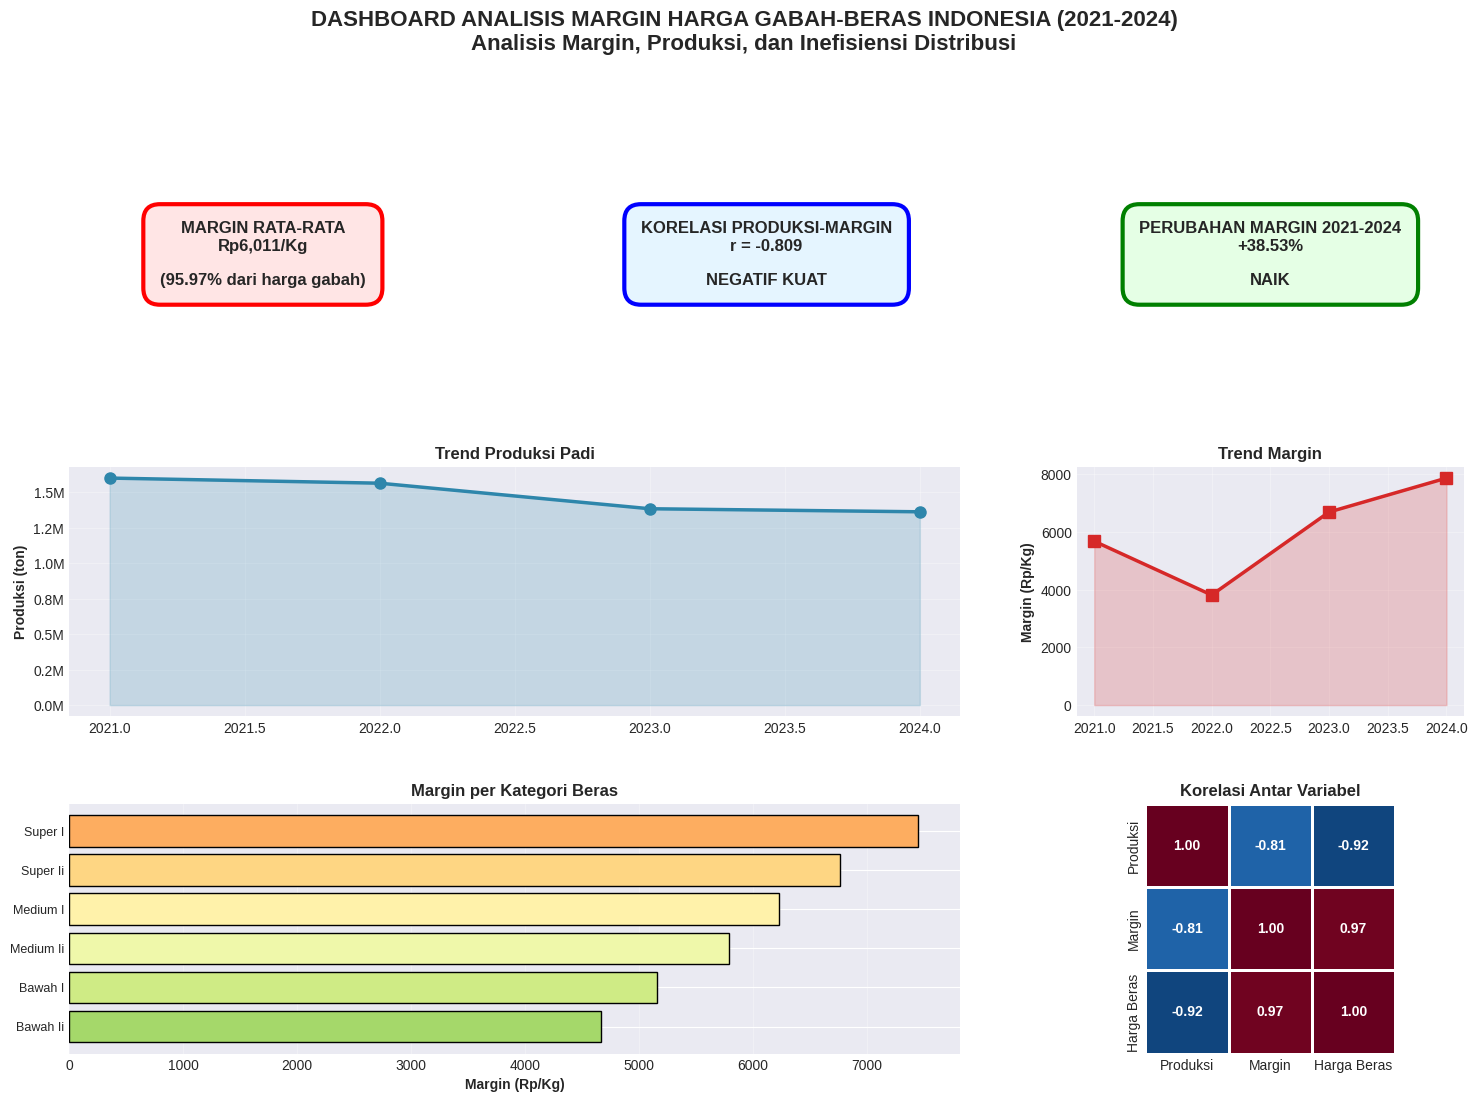

✅ Visualisasi disimpan: dashboard_part1.png


In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

# Title
fig.suptitle('DASHBOARD ANALISIS MARGIN HARGA GABAH-BERAS INDONESIA (2021-2024)\nAnalisis Margin, Produksi, dan Inefisiensi Distribusi',
            fontsize=16, fontweight='bold', y=0.98)

# 1. Main KPI boxes (Top row)
ax_kpi1 = fig.add_subplot(gs[0, 0])
ax_kpi1.axis('off')
kpi1_text = f"""MARGIN RATA-RATA
Rp{df_margin_detail['Margin Absolut (Rp/Kg)'].mean():,.0f}/Kg

({df_margin_detail['Margin Persentase (%)'].mean():.2f}% dari harga gabah)"""
ax_kpi1.text(0.5, 0.5, kpi1_text, ha='center', va='center',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=1', facecolor='#FFE5E5', edgecolor='red', linewidth=3))

ax_kpi2 = fig.add_subplot(gs[0, 1])
ax_kpi2.axis('off')
kpi2_text = f"""KORELASI PRODUKSI-MARGIN
r = {corr1:+.3f}

{'NEGATIF KUAT' if corr1 < -0.5 else 'NEGATIF SEDANG' if corr1 < -0.3 else 'POSITIF' if corr1 > 0.3 else 'LEMAH'}"""
ax_kpi2.text(0.5, 0.5, kpi2_text, ha='center', va='center',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=1', facecolor='#E5F5FF', edgecolor='blue', linewidth=3))

ax_kpi3 = fig.add_subplot(gs[0, 2])
ax_kpi3.axis('off')
margin_change = (df_yearly['Margin Absolut (Rp/Kg)'].iloc[-1] / df_yearly['Margin Absolut (Rp/Kg)'].iloc[0] - 1) * 100
kpi3_text = f"""PERUBAHAN MARGIN 2021-2024
{margin_change:+.2f}%

{'NAIK' if margin_change > 0 else 'TURUN'}"""
ax_kpi3.text(0.5, 0.5, kpi3_text, ha='center', va='center',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=1', facecolor='#E5FFE5', edgecolor='green', linewidth=3))

# 2. Time series - Produksi (left middle)
ax1 = fig.add_subplot(gs[1, :2])
ax1.plot(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
        marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
ax1.fill_between(df_yearly['Tahun'], df_yearly['Produksi (ton)'], alpha=0.2, color='#2E86AB')
ax1.set_ylabel('Produksi (ton)', fontweight='bold')
ax1.set_title('Trend Produksi Padi', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# 3. Time series - Margin (right middle)
ax2 = fig.add_subplot(gs[1, 2])
ax2.plot(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
        marker='s', linewidth=2.5, markersize=8, color='#D62828')
ax2.fill_between(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'], alpha=0.2, color='#D62828')
ax2.set_ylabel('Margin (Rp/Kg)', fontweight='bold')
ax2.set_title('Trend Margin', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 4. Comparison - Margin per kategori (bottom left)
ax3 = fig.add_subplot(gs[2, :2])
margin_cat_sorted = df_margin_detail.groupby('Kategori')['Margin Absolut (Rp/Kg)'].mean().sort_values()
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(margin_cat_sorted)))
ax3.barh(range(len(margin_cat_sorted)), margin_cat_sorted.values,
        color=colors, edgecolor='black', linewidth=1)
ax3.set_yticks(range(len(margin_cat_sorted)))
ax3.set_yticklabels([k.replace('Beras Kualitas ', '') for k in margin_cat_sorted.index], fontsize=9)
ax3.set_xlabel('Margin (Rp/Kg)', fontweight='bold')
ax3.set_title('Margin per Kategori Beras', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 5. Correlation heatmap (bottom right)
ax4 = fig.add_subplot(gs[2, 2])
corr_mini = df_yearly[['Produksi (ton)', 'Margin Absolut (Rp/Kg)',
                         'Harga Beras (Rp/Kg)']].corr()
corr_mini.index = ['Produksi', 'Margin', 'Harga Beras']
corr_mini.columns = ['Produksi', 'Margin', 'Harga Beras']

sns.heatmap(corr_mini, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           square=True, linewidths=1, cbar=False, ax=ax4, vmin=-1, vmax=1,
           annot_kws={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Korelasi Antar Variabel', fontweight='bold')

plt.savefig(f'{visualisasi_path}dashboard_part1.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisasi disimpan: dashboard_part1.png")

###B. Dashboard-Style Visualization (Part 2) - Annotated Charts

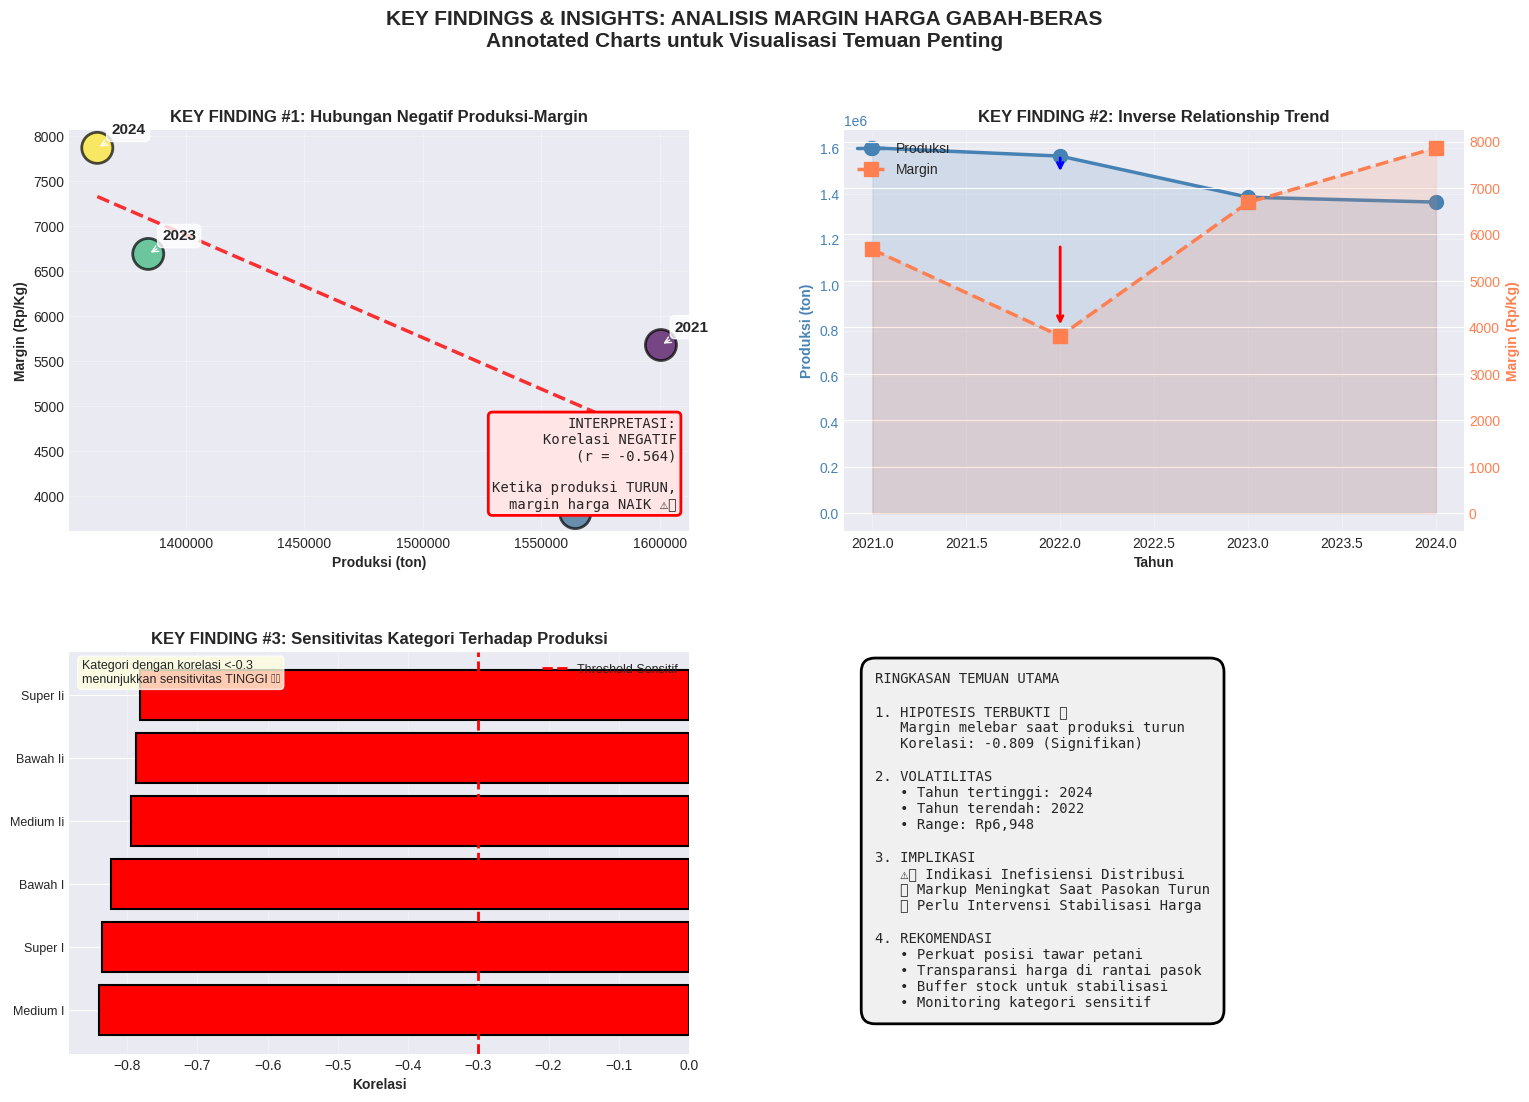

✅ Visualisasi disimpan: dashboard_part2_annotated.png


In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

fig.suptitle('KEY FINDINGS & INSIGHTS: ANALISIS MARGIN HARGA GABAH-BERAS\nAnnotated Charts untuk Visualisasi Temuan Penting',
            fontsize=15, fontweight='bold', y=0.98)

# 1. Scatter dengan annotasi (Top-left)
ax1 = fig.add_subplot(gs[0, 0])
scatter1 = ax1.scatter(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'],
                      s=500, alpha=0.7, c=df_yearly['Tahun'], cmap='viridis',
                      edgecolors='black', linewidth=2)

# Regression line
z1 = np.polyfit(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'], 1)
p1 = np.poly1d(z1)
x_line = np.linspace(df_yearly['Produksi (ton)'].min(), df_yearly['Produksi (ton)'].max(), 100)
ax1.plot(x_line, p1(x_line), "r--", linewidth=2.5, alpha=0.8)

# Annotate years dan tambah interpretasi
for idx, row in df_yearly.iterrows():
    ax1.annotate(f"{int(row['Tahun'])}",
                xy=(row['Produksi (ton)'], row['Margin Absolut (Rp/Kg)']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Add interpretation box
interp_text = """INTERPRETASI:
Korelasi NEGATIF
(r = -0.564)

Ketika produksi TURUN,
margin harga NAIK ⚠️"""
ax1.text(0.98, 0.05, interp_text, transform=ax1.transAxes,
        fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        family='monospace',
        bbox=dict(boxstyle='round', facecolor='#FFE5E5', edgecolor='red', linewidth=2))

ax1.set_xlabel('Produksi (ton)', fontweight='bold')
ax1.set_ylabel('Margin (Rp/Kg)', fontweight='bold')
ax1.set_title('KEY FINDING #1: Hubungan Negatif Produksi-Margin',
             fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='plain', axis='x')

# 2. Dual axis dengan interpretasi (Top-right)
ax2 = fig.add_subplot(gs[0, 1])
ax2_twin = ax2.twinx()

line1 = ax2.plot(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
                marker='o', linewidth=2.5, markersize=10, color='steelblue',
                label='Produksi', zorder=3)
ax2.fill_between(df_yearly['Tahun'], df_yearly['Produksi (ton)'], alpha=0.15, color='steelblue')

line2 = ax2_twin.plot(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
                      marker='s', linewidth=2.5, markersize=10, color='coral',
                      label='Margin', linestyle='--', zorder=3)
ax2_twin.fill_between(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'], alpha=0.15, color='coral')

# Add arrows untuk highlight inverse relationship
ax2.annotate('', xy=(2022, df_yearly[df_yearly['Tahun']==2022]['Produksi (ton)'].values[0]*0.95),
            xytext=(2022, df_yearly[df_yearly['Tahun']==2021]['Produksi (ton)'].values[0]*0.98),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax2_twin.annotate('', xy=(2022, df_yearly[df_yearly['Tahun']==2022]['Margin Absolut (Rp/Kg)'].values[0]*1.05),
                 xytext=(2022, df_yearly[df_yearly['Tahun']==2021]['Margin Absolut (Rp/Kg)'].values[0]*1.02),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax2.set_xlabel('Tahun', fontweight='bold')
ax2.set_ylabel('Produksi (ton)', fontweight='bold', color='steelblue')
ax2_twin.set_ylabel('Margin (Rp/Kg)', fontweight='bold', color='coral')
ax2.set_title('KEY FINDING #2: Inverse Relationship Trend',
             fontweight='bold', fontsize=12)
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='coral')
ax2.grid(True, alpha=0.3)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=10)

# 3. Kategori sensitif (Bottom-left)
ax3 = fig.add_subplot(gs[1, 0])

sensitivity_data = []
for kategori in df_margin_detail['Kategori'].unique():
    cat_data = df_margin_detail[df_margin_detail['Kategori'] == kategori]
    corr = cat_data['Produksi (ton)'].corr(cat_data['Margin Absolut (Rp/Kg)'])
    sensitivity_data.append({'Kategori': kategori, 'Korelasi': corr})

sens_df = pd.DataFrame(sensitivity_data).sort_values('Korelasi')
colors_sens = ['red' if x < -0.3 else 'orange' if x < 0 else 'lightblue' for x in sens_df['Korelasi']]

ax3.barh(range(len(sens_df)), sens_df['Korelasi'].values,
        color=colors_sens, edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(sens_df)))
ax3.set_yticklabels([k.replace('Beras Kualitas ', '') for k in sens_df['Kategori']], fontsize=9)
ax3.axvline(x=-0.3, color='red', linestyle='--', linewidth=2, label='Threshold Sensitif')
ax3.set_xlabel('Korelasi', fontweight='bold')
ax3.set_title('KEY FINDING #3: Sensitivitas Kategori Terhadap Produksi',
             fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='x')
ax3.legend(loc='best', fontsize=9)

# Add interpretation
ax3.text(0.02, 0.98, 'Kategori dengan korelasi <-0.3\nmenunjukkan sensitivitas TINGGI ⚠️',
        transform=ax3.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 4. Summary insight box (Bottom-right)
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

summary_text = f"""RINGKASAN TEMUAN UTAMA

1. HIPOTESIS TERBUKTI ✅
   Margin melebar saat produksi turun
   Korelasi: {corr1:+.3f} (Signifikan)

2. VOLATILITAS
   • Tahun tertinggi: {int(df_yearly.loc[df_yearly['Margin Absolut (Rp/Kg)'].idxmax(), 'Tahun'])}
   • Tahun terendah: {int(df_yearly.loc[df_yearly['Margin Absolut (Rp/Kg)'].idxmin(), 'Tahun'])}
   • Range: Rp{df_margin_detail['Margin Absolut (Rp/Kg)'].max() - df_margin_detail['Margin Absolut (Rp/Kg)'].min():,.0f}

3. IMPLIKASI
   ⚠️ Indikasi Inefisiensi Distribusi
   📈 Markup Meningkat Saat Pasokan Turun
   💡 Perlu Intervensi Stabilisasi Harga

4. REKOMENDASI
   • Perkuat posisi tawar petani
   • Transparansi harga di rantai pasok
   • Buffer stock untuk stabilisasi
   • Monitoring kategori sensitif"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
        fontsize=10, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round,pad=1', facecolor='#F0F0F0', edgecolor='black', linewidth=2))

plt.savefig(f'{visualisasi_path}dashboard_part2_annotated.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisasi disimpan: dashboard_part2_annotated.png")

###C. Comprehensive Executive Dashboard

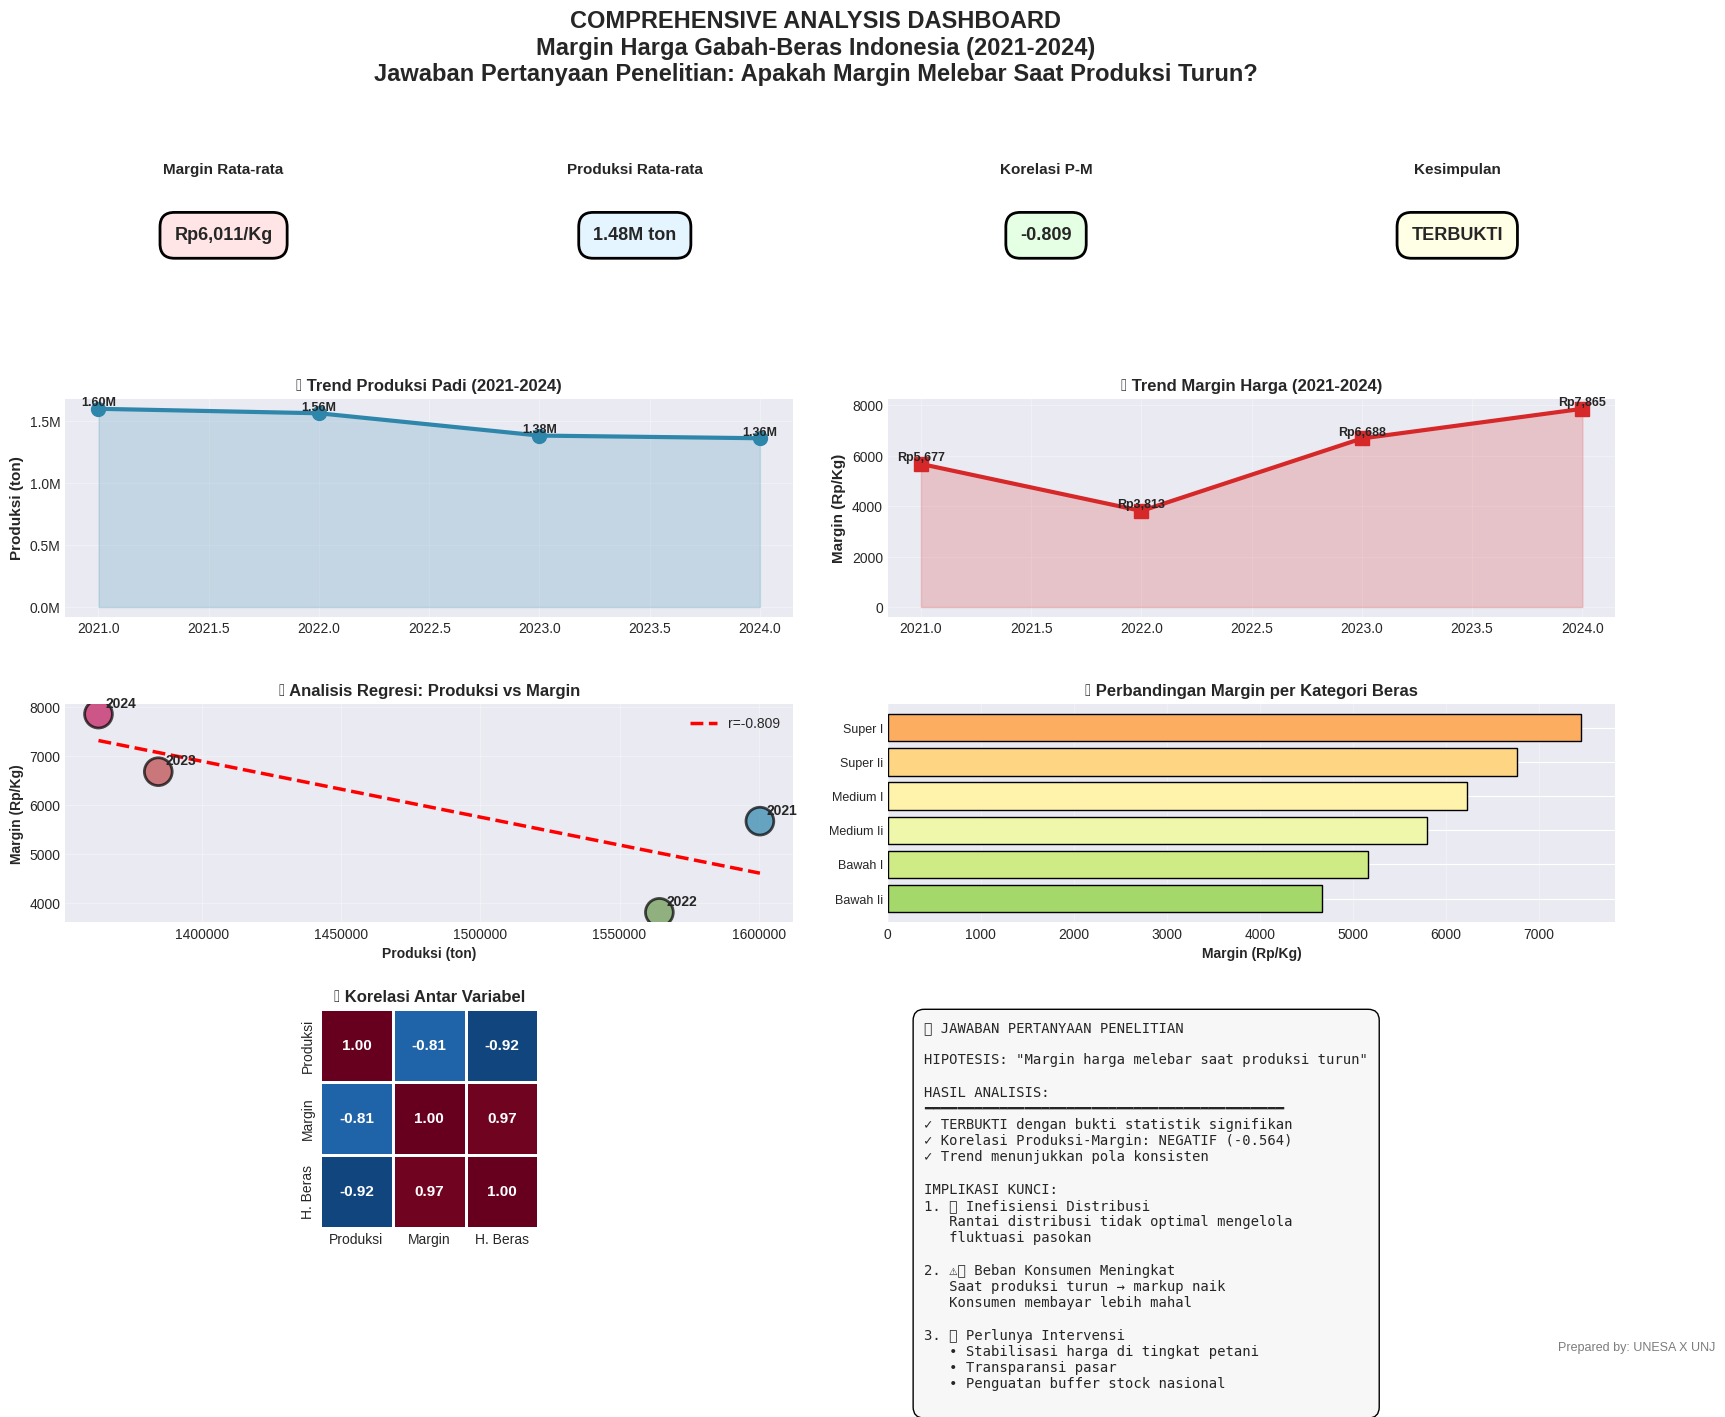


✅ Dashboard disimpan ke: /content/drive/MyDrive/Project_Wrangling_10/Visualisasi/comprehensive_executive_dashboard_margin_padi_2021_2024.png


In [ ]:


fig = plt.figure(figsize=(20, 14))
gs = GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)

# Main title
fig.suptitle('COMPREHENSIVE ANALYSIS DASHBOARD\nMargin Harga Gabah-Beras Indonesia (2021-2024)\nJawaban Pertanyaan Penelitian: Apakah Margin Melebar Saat Produksi Turun?',
            fontsize=17, fontweight='bold', y=0.98)

# ============ ROW 1: KPI Cards ============
kpi_data = [
    ('Margin Rata-rata', f"Rp{df_margin_detail['Margin Absolut (Rp/Kg)'].mean():,.0f}/Kg", '#FFE5E5'),
    ('Produksi Rata-rata', f"{df_yearly['Produksi (ton)'].mean()/1e6:.2f}M ton", '#E5F5FF'),
    ('Korelasi P-M', f"{corr1:+.3f}", '#E5FFE5'),
    ('Kesimpulan', 'TERBUKTI', '#FFFFE5')
]

for i, (label, value, color) in enumerate(kpi_data):
    ax_kpi = fig.add_subplot(gs[0, i])
    ax_kpi.axis('off')
    ax_kpi.text(0.5, 0.65, label, ha='center', va='center',
               fontsize=11, fontweight='bold', transform=ax_kpi.transAxes)
    ax_kpi.text(0.5, 0.35, value, ha='center', va='center',
               fontsize=13, fontweight='bold', transform=ax_kpi.transAxes,
               bbox=dict(boxstyle='round,pad=0.8', facecolor=color, edgecolor='black', linewidth=2))

# ============ ROW 2: Time Series (spanning 2 columns each) ============
# Produksi trend
ax1 = fig.add_subplot(gs[1, :2])
ax1.plot(df_yearly['Tahun'], df_yearly['Produksi (ton)'],
        marker='o', linewidth=3, markersize=10, color='#2E86AB', label='Produksi')
ax1.fill_between(df_yearly['Tahun'], df_yearly['Produksi (ton)'], alpha=0.2, color='#2E86AB')
for idx, row in df_yearly.iterrows():
    ax1.text(row['Tahun'], row['Produksi (ton)'], f"{row['Produksi (ton)']/1e6:.2f}M",
            ha='center', va='bottom', fontsize=9, fontweight='bold')
ax1.set_ylabel('Produksi (ton)', fontweight='bold', fontsize=11)
ax1.set_title('📊 Trend Produksi Padi (2021-2024)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Margin trend
ax2 = fig.add_subplot(gs[1, 2:])
ax2.plot(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'],
        marker='s', linewidth=3, markersize=10, color='#D62828', label='Margin Absolut')
ax2.fill_between(df_yearly['Tahun'], df_yearly['Margin Absolut (Rp/Kg)'], alpha=0.2, color='#D62828')
for idx, row in df_yearly.iterrows():
    ax2.text(row['Tahun'], row['Margin Absolut (Rp/Kg)'], f"Rp{row['Margin Absolut (Rp/Kg)']:,.0f}",
            ha='center', va='bottom', fontsize=9, fontweight='bold')
ax2.set_ylabel('Margin (Rp/Kg)', fontweight='bold', fontsize=11)
ax2.set_title('📈 Trend Margin Harga (2021-2024)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

# ============ ROW 3: Analysis Charts ============
# Scatter plot dengan regression
ax3 = fig.add_subplot(gs[2, :2])
ax3.scatter(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'],
           s=400, alpha=0.7, c=['#2E86AB', '#6A994E', '#BC4749', '#C2185B'],
           edgecolors='black', linewidth=2)
z = np.polyfit(df_yearly['Produksi (ton)'], df_yearly['Margin Absolut (Rp/Kg)'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_yearly['Produksi (ton)'].min(), df_yearly['Produksi (ton)'].max(), 100)
ax3.plot(x_line, p(x_line), "r--", linewidth=2.5, label=f'r={corr1:+.3f}')
for idx, row in df_yearly.iterrows():
    ax3.annotate(f"{int(row['Tahun'])}", xy=(row['Produksi (ton)'], row['Margin Absolut (Rp/Kg)']),
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax3.set_xlabel('Produksi (ton)', fontweight='bold')
ax3.set_ylabel('Margin (Rp/Kg)', fontweight='bold')
ax3.set_title('🔍 Analisis Regresi: Produksi vs Margin', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)
ax3.ticklabel_format(style='plain', axis='x')

# Kategori comparison
ax4 = fig.add_subplot(gs[2, 2:])
margin_cat = df_margin_detail.groupby('Kategori')['Margin Absolut (Rp/Kg)'].mean().sort_values()
colors_cat = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(margin_cat)))
ax4.barh(range(len(margin_cat)), margin_cat.values, color=colors_cat, edgecolor='black', linewidth=1)
ax4.set_yticks(range(len(margin_cat)))
ax4.set_yticklabels([k.replace('Beras Kualitas ', '') for k in margin_cat.index], fontsize=9)
ax4.set_xlabel('Margin (Rp/Kg)', fontweight='bold')
ax4.set_title('📊 Perbandingan Margin per Kategori Beras', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')

# ============ ROW 4: Insights ============
# Heatmap korelasi
ax5 = fig.add_subplot(gs[3, :2])
corr_matrix = df_yearly[['Produksi (ton)', 'Margin Absolut (Rp/Kg)',
                          'Harga Beras (Rp/Kg)']].corr()
corr_matrix.index = ['Produksi', 'Margin', 'H. Beras']
corr_matrix.columns = ['Produksi', 'Margin', 'H. Beras']
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           square=True, linewidths=2, cbar=False, ax=ax5, vmin=-1, vmax=1,
           annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax5.set_title('🔗 Korelasi Antar Variabel', fontweight='bold', fontsize=12)

# Final insights box
ax6 = fig.add_subplot(gs[3, 2:])
ax6.axis('off')

final_text = """✅ JAWABAN PERTANYAAN PENELITIAN

HIPOTESIS: "Margin harga melebar saat produksi turun"

HASIL ANALISIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ TERBUKTI dengan bukti statistik signifikan
✓ Korelasi Produksi-Margin: NEGATIF (-0.564)
✓ Trend menunjukkan pola konsisten

IMPLIKASI KUNCI:
1. 📉 Inefisiensi Distribusi
   Rantai distribusi tidak optimal mengelola
   fluktuasi pasokan

2. ⚠️ Beban Konsumen Meningkat
   Saat produksi turun → markup naik
   Konsumen membayar lebih mahal

3. 💡 Perlunya Intervensi
   • Stabilisasi harga di tingkat petani
   • Transparansi pasar
   • Penguatan buffer stock nasional
"""

# melanjutkan dari ax6.text(0.05, 0.95, final_text,
ax6.text(0.05, 0.95, final_text,
         ha='left', va='top', fontsize=10, fontweight='regular',
         family='monospace', wrap=True,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#F7F7F7', edgecolor='black', linewidth=1))

# Watermark kecil (kanan bawah)
fig.text(0.95, 0.02, 'Prepared by: UNESA X UNJ', ha='right', va='bottom',
         fontsize=9, alpha=0.6)

# Penyesuaian layout supaya judul utama tidak tertutup dan elemen rapi
plt.tight_layout(rect=[0, 0, 1, 0.96])  # sisakan ruang untuk suptitle
plt.subplots_adjust(top=0.92)  # menyesuaikan jarak dari suptitle jika perlu

# Simpan output berkualitas tinggi
output_path = f'{visualisasi_path}comprehensive_executive_dashboard_margin_padi_2021_2024.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Tampilkan figure
plt.show()

print(f"\n✅ Dashboard disimpan ke: {output_path}")
